# Notes
* Feature Engineering & Visualisation, modelling with RandomForest, XGBoost, and Support Vector classifiers

As a beginner in this competition, I created a notebook that I found to be the most enjoyable to work on. It includes data visualization using Mathplot and Seaborn, feature engineering, and modelling using the RandomForest, XGBoost, and Support Vector classification algorithms, along with a simple stacking step. I relied heavily on sklearn and mlxtend for feature selection and modelling. My final submission used the Support Vector classifier, which returned the highest leader score. As a beginner, I struggled with tuning the models while avoiding overfitting the training data. However, I managed to strike a good balance and successfully adjust the modelling process. I hope this notebook will be useful for other beginners. Please note that running the whole notebook may be time-consuming, but the complete workflow is available and easy to follow. I am sharing this notebook publicly to learn from the community, so please feel free to leave a comment if you see any faults or areas for improvement. Your feedback is greatly appreciated, and please rate if you find this helpful.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scipy
import math
from collections import OrderedDict

from sklearn import metrics
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.metrics import balanced_accuracy_score ,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn_pandas import DataFrameMapper

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.impute import KNNImputer , SimpleImputer
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, OrdinalEncoder, OneHotEncoder

from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer , FunctionTransformer
from sklearn.compose import ColumnTransformer

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import ColumnSelector

from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier, plot_tree
import xgboost as xgb
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,mutual_info_classif ,chi2 

from sklearn.tree import export_graphviz
from sklearn import tree

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import auc, roc_curve
import time

# Data Understanding

In [3]:
df=pd.read_csv('train.csv')

In [4]:
df_test=pd.read_csv('test.csv')

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
display(df.head(5))
display(df.shape)
display(df.info())
display(df.nunique())
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(keep=False)].shape[0])

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

(891, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

Number of duplicate rows (including first) in the table is: 0


In [7]:
#Starting manupulating dataframe
dfv01=df.copy()

In [8]:
"""Converting features into appropriate data types """
dfv01['PassengerId'] = dfv01['PassengerId'].astype('object')
dfv01['Sex'] = dfv01['Sex'].astype('category')
dfv01['Embarked'] = dfv01['Embarked'].astype('category')
display(dfv01.dtypes)

PassengerId      object
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [9]:
# Descriptive stats for categorical features only.
category_columns = dfv01.select_dtypes(['category']).columns
dfv01[category_columns].describe().T

count unique   top freq
Sex        891      2  male  577
Embarked   889      3     S  644

In [10]:
#Fixing "nan" in Embarked with most common location
dfv01['Embarked']=dfv01['Embarked'].fillna('S')

In [11]:
def show_values(plot):
    for ax in plot.axes.ravel():
        # add annotations
        for c in ax.containers:
            # custom label calculates percent and add an empty string so 0 value bars don't have a number
            labels = [f'{w:0.0f}' if (w := v.get_height()) > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=0, padding=2)
        ax.margins(y=0.2)

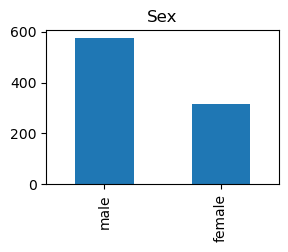

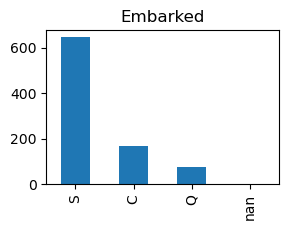

In [12]:
for column in category_columns:
    f = df[column].value_counts(dropna=False).plot(kind='bar', figsize=(3,2), title=column)
    plt.show()

In [13]:
dfv01.describe().T

count       mean        std   min      25%      50%   75%       max
Survived  891.0   0.383838   0.486592  0.00   0.0000   0.0000   1.0    1.0000
Pclass    891.0   2.308642   0.836071  1.00   2.0000   3.0000   3.0    3.0000
Age       714.0  29.699118  14.526497  0.42  20.1250  28.0000  38.0   80.0000
SibSp     891.0   0.523008   1.102743  0.00   0.0000   0.0000   1.0    8.0000
Parch     891.0   0.381594   0.806057  0.00   0.0000   0.0000   0.0    6.0000
Fare      891.0  32.204208  49.693429  0.00   7.9104  14.4542  31.0  512.3292

In [14]:
print(f"Pclass\n{dfv01['Pclass'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print(f"Embarked\n{dfv01['Embarked'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")

Pclass
3    55.1%
1    24.2%
2    20.7%
Name: Pclass, dtype: object
Embarked
S    72.5%
C    18.9%
Q     8.6%
Name: Embarked, dtype: object


#### checking distribution of numeric data

In [15]:
print("Kurtosis value of the Fare attribute",kurtosis(dfv01.Fare, axis=0, bias=True))
print("Skewness value of the Fare attribute",skew(dfv01.Fare, axis=0, bias=True))

Kurtosis value of the Fare attribute 33.20428925264474
Skewness value of the Fare attribute 4.7792532923723545


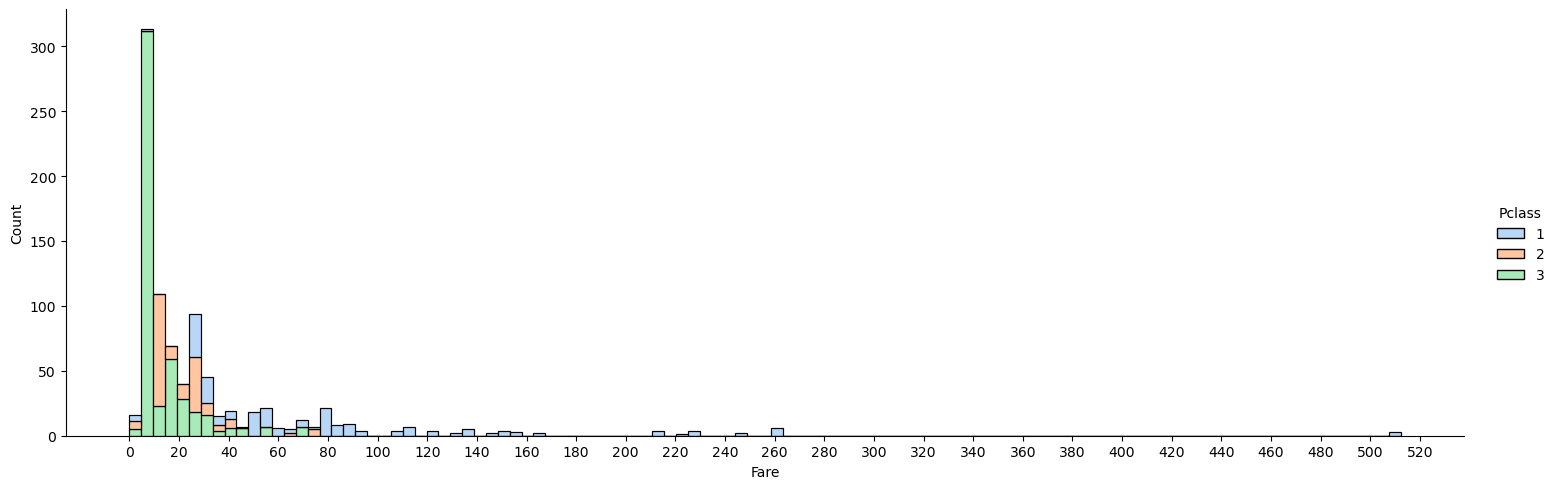

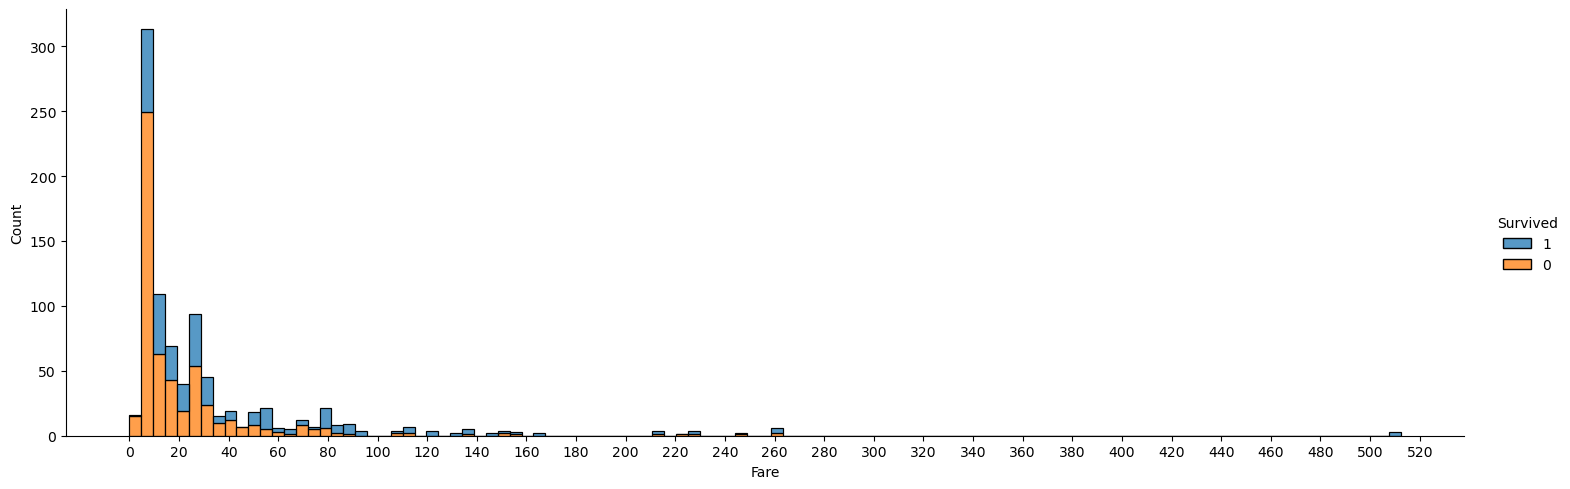

In [16]:
sns.displot(data=dfv01,  x='Fare', hue='Pclass',multiple="stack", aspect=3, 
            palette=sns.color_palette("pastel",3)).set_titles("all")
plt.xticks([x for x in range(0,540,20)])

sns.displot(data=dfv01,  x='Fare', hue='Survived',multiple="stack", aspect=3,hue_order= [1, 0],
            palette=sns.color_palette()).set_titles("survived")
plt.xticks([x for x in range(0,540,20)])
plt.show()

    Insights from the graph
* Distribution of numeric data is non gaussian therefore nonparametric models will better suit this classification task. 
* There are huge outliers in fare attribute
* Pclass don't have strict dependence on fare.

#### Investigating the trends in data

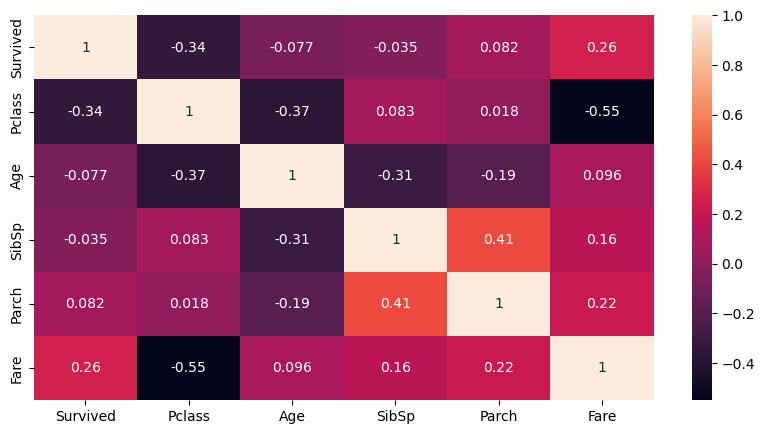

In [17]:
fig, ax = plt.subplots(figsize=(10,5)) 
dataplot = sns.heatmap(dfv01.corr(), ax=ax,annot=True)
plt.show()

    Insights from the graph
* Survived and Pclass have high negative correlation: class 1 and class 2 should have higher survival rate then class 3
* Age and Fare are moderately correlated to survival
* While Plass don't have strict dependence on fare, Fare and Pclass is highly correlated
* Pclass have high negative correlationcorrelation with age

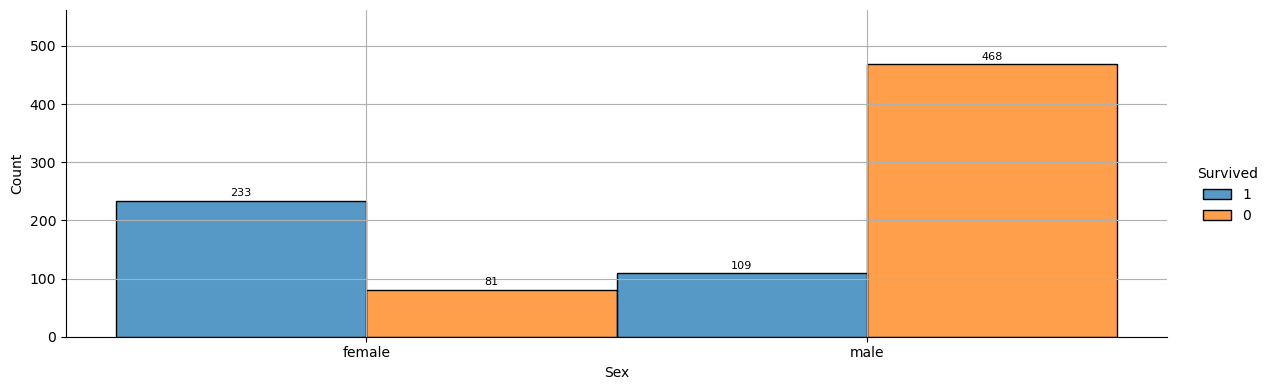

In [18]:
ax=sns.displot( dfv01 , x = 'Sex', hue='Survived' , hue_order= [1, 0],
               multiple="dodge",height=4, aspect=3)

plt.grid() 
show_values(ax)

* Females had higher survival rates then males

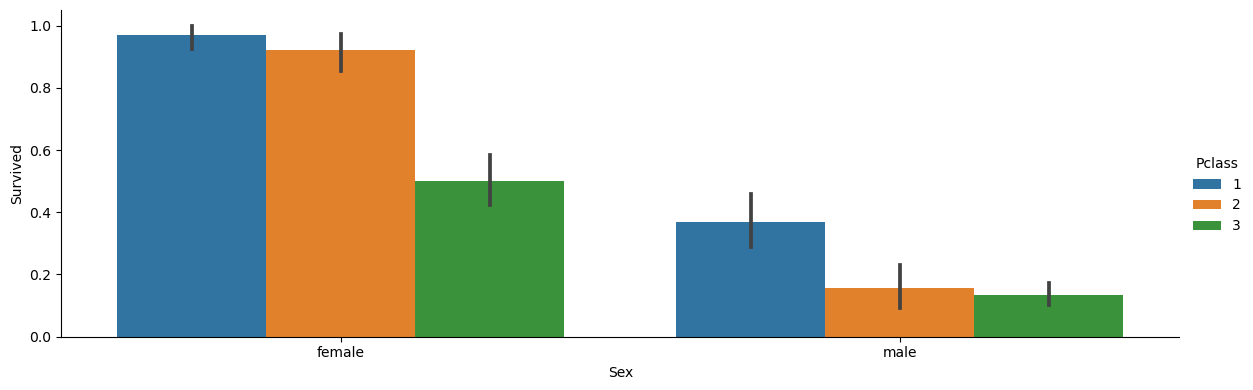

In [19]:
sns.catplot(data=dfv01, x="Sex", y="Survived", hue="Pclass", kind="bar",height=4, aspect=3)

    Insights from the graph
* Seems like women given priorty for rescue with more emphasis then Pclass

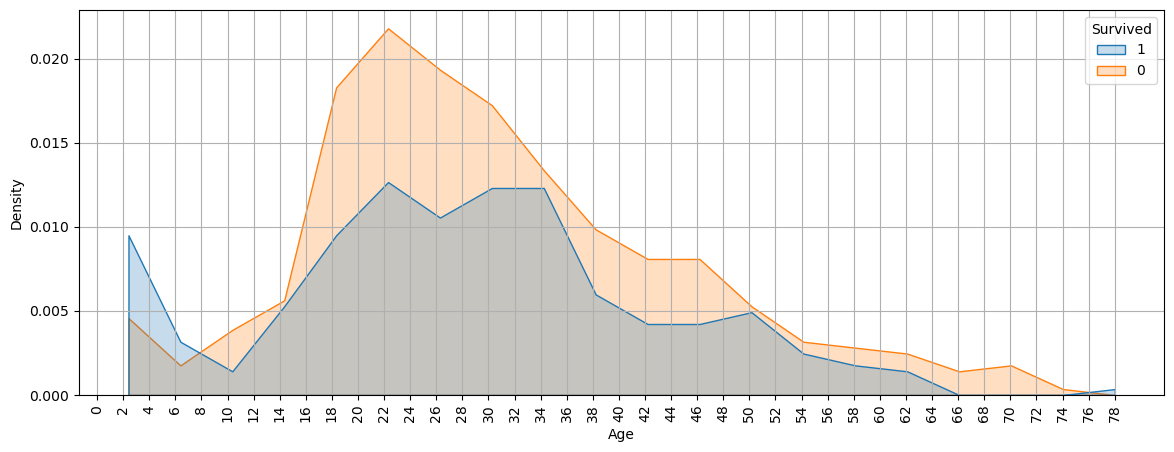

In [20]:
fig, ax = plt.subplots(figsize=(14,5)) 
sns.histplot(data=dfv01,  x='Age', hue='Survived',hue_order= [1, 0], element="poly",
    stat="density", palette=sns.color_palette())
ax.set(xticks=[x for x in range(int(dfv01['Age'].min()),int(dfv01['Age'].max()),2)])
plt.xticks(rotation=90)
plt.grid() 
plt.show()

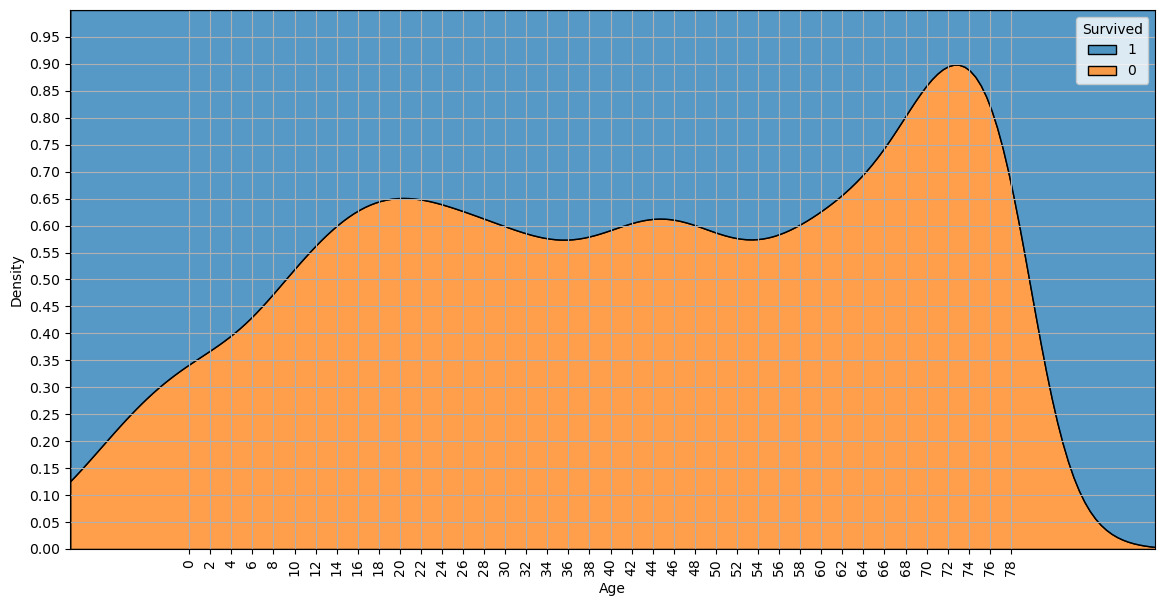

In [21]:
fig, ax = plt.subplots(figsize=(14,7)) 
sns.kdeplot(data=dfv01, x="Age", hue="Survived",hue_order= [1, 0], multiple="fill")
ax.set(xticks=[x for x in range(int(dfv01['Age'].min()),int(dfv01['Age'].max()),2)])
ax.set(yticks=[x/100 for x in range(0,100,5)])
plt.xticks(rotation=90)
plt.grid() 
plt.show()

    Insights from the graphs
* based on survival denisity per age & histogram I will divide age in to 13 group
    * [0,4]infant
    * [5,8]yound_child
    * [9,12]old_child
    * [13,15]early_teen
    * [16-19] late_teen
    * [20-27] yound adult
    * [28-35] adult_s1
    * [36,44] adult_s2
    * [45,53] adult_s3
    * [54,58] adult_late
    * [59,61] senior
    * [62,72] elderly
    * [73,inf] gray
 * result for adult group quite similar. But adult segments have highest of population density, to capture slight variance to differentiate among them, I divide adult population into sub-segments.

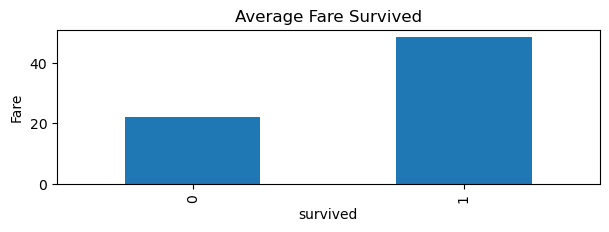

In [22]:
fig, ax = plt.subplots(figsize=(7, 2))
pclass_fare = dfv01.groupby(["Survived"]).mean()["Fare"]
pclass_fare.plot.bar(ax=ax)
_ = ax.set(
    title="Average Fare Survived",
    xlabel="survived",
    ylabel="Fare",
)

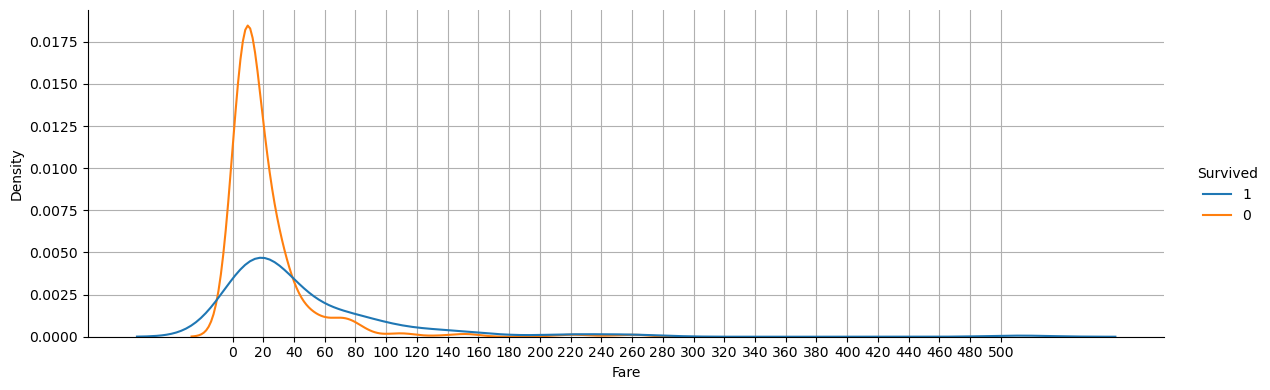

In [23]:
ax=sns.displot( dfv01 , x = 'Fare', hue='Survived' ,hue_order= [1, 0], kind = 'kde',height=4, aspect=3)
ax.set(xticks=[x for x in range(int(dfv01['Fare'].min()),int(dfv01['Fare'].max()),20)])
plt.grid() 
plt.show()

    Insights from the graph
* People who paid more survived more so average fare of survivors double the average fare of ppl lost 
* After Fare= 40 survival rate is higher then rate of death

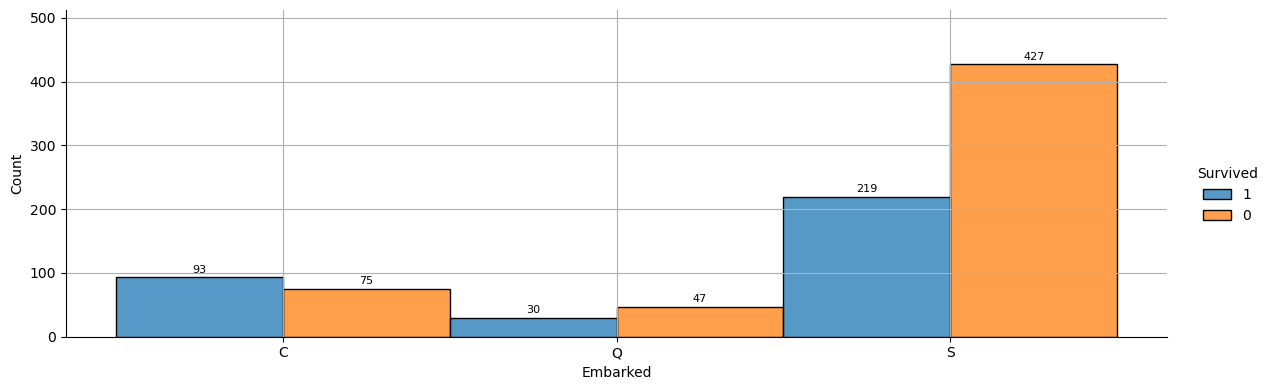

In [24]:
ax=sns.displot( dfv01 , x = 'Embarked', hue='Survived' , multiple="dodge",hue_order= [1, 0],height=4, aspect=3)

plt.grid() 
show_values(ax)

    Insights from the graph
* Embarked is less correlated with survival and C & Q have higher survival rate then S

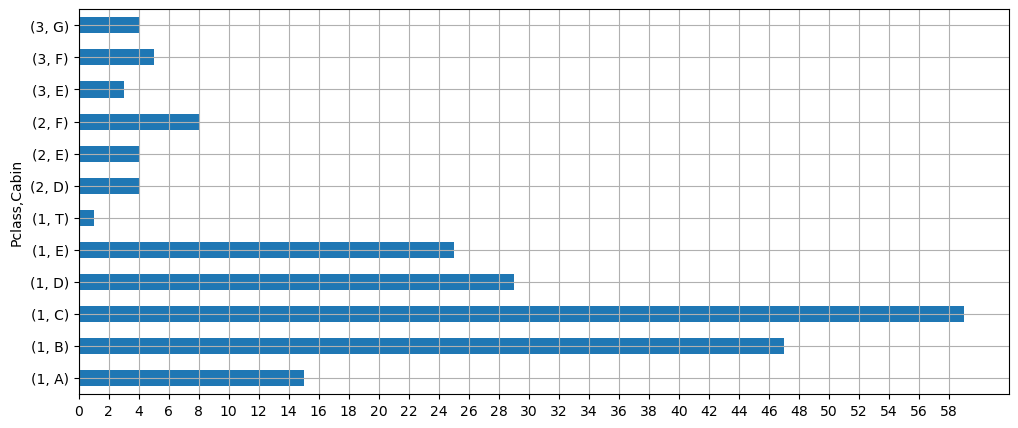

In [25]:
Deck=dfv01['Cabin'].str[0]
fig, ax = plt.subplots(figsize=(12, 5))
dfv01.groupby(['Pclass',Deck]).count()["PassengerId"].plot.barh()
plt.xticks([x for x in range(0,60,2)])
plt.grid() 

## Data Quality Plan
* Fix problem with empty values/outliers in cabin, extract first letter to represent deck and mark unknown to encode as accordingly. 
* Derive title from name then categorize in to more general segments
* Derive a new feature "alt_sex" which have female, male, female_kid, male_kid, adult male with kid and adult female with kid classes. 
* Derive feature "group size" and "Max group size"
* Derive fare per person fix skewness.
* Impute fare & age
* Derive total number of adult male, adult female and children in group and add them as feature.
* categorise age 
* bin fare 

# Feature Engineering

In [26]:
dfv01.shape

(891, 12)

In [27]:
dfv02=dfv01.copy()

In [28]:
dfv02=dfv02.loc[:, dfv02.columns != 'Survived']

In [29]:
df_test=pd.read_csv('test.csv')

In [30]:
"""Converting features into appropriate data types """
df_test['PassengerId'] = df_test['PassengerId'].astype('object')
df_test['Sex'] = df_test['Sex'].astype('category')
df_test['Embarked'] = df_test['Embarked'].astype('category')

In [31]:
df_full=pd.concat([df_test,dfv02]).reset_index()
df_full.drop('index', axis=1, inplace=True)

In [32]:
Ticket_dict=df_full.groupby('Ticket')['Ticket'].agg('count').to_dict()

In [33]:
#derive Surname & families 
df_full['Surname']=df_full['Name'].str.split(', ').str[0]
Surname_dict_full=df_full.groupby('Surname')['Surname'].agg('count').to_dict()
Surname_dict_full_fam={key:val for key, val in Surname_dict_full.items() if val != 1}

dfv01['Surname']=dfv01['Name'].str.split(', ').str[0]
Surname_dict_dfv01=dfv01.groupby('Surname')['Surname'].agg('count').to_dict()
Surname_dict_dfv01_fam={}
for key, val in Surname_dict_dfv01.items():
    if key in Surname_dict_full_fam.keys():
        Surname_dict_dfv01_fam[key]=val

In [34]:
df_stable=df_full.copy()

In [35]:
df_deriv=df_full.copy()
df_deriv['Surname']=df_deriv['Name'].str.split(', ').str[0]
df_deriv.loc[df_deriv['Age']<9,'Sex_new']='children'
df_deriv['Sex_new']=df_deriv['Sex_new'].fillna(df_deriv['Sex'])
df_deriv['Sex_new'] = df_deriv['Sex_new'].astype('object')
df_deriv['Sex'] = df_deriv['Sex'].astype('object')
df_deriv['alt_sex']=np.where(df_deriv['Sex_new']=='children',
                             df_deriv['Sex_new']+'_'+df_deriv['Sex'],df_deriv['Sex_new'])

In [36]:
sex_count_df=(df_deriv.groupby(['Surname','alt_sex'])).agg(Count=('alt_sex','size')).reset_index()
table=pd.pivot_table(sex_count_df,values='Count',index='Surname',columns=['alt_sex'])
table.fillna(0)
surname_children_female_dict=table.groupby(['Surname'])['children_female'].sum().to_dict()
surname_children_male_dict=table.groupby(['Surname'])['children_male'].sum().to_dict()
surname_female_dict=table.groupby(['Surname'])['female'].sum().to_dict()
surname_male_dict=table.groupby(['Surname'])['male'].sum().to_dict()

In [37]:
def new_features(X,Ticket_dict,df_stable):
     

    #fixing cabin converting to deck
    X['Cabin'] = X['Cabin'].fillna('Unknown')
    X['Deck'] = X['Cabin'].str[0]
    X.drop('Cabin', axis=1, inplace=True)
    X['Deck'] = X['Deck'].replace(['T'], 'A')
    X['Deck'] = X['Deck'].astype('category')

    #deriving title from name
    def title_categorizer(X):
        title = [i.split(',')[1].split('.')[0].strip() for i in X['Name']]
        X['Title'] = pd.Series(title)
        X['Title']=np.where((X['Sex']=='female')& (X['Title']=='Dr'),'DrLady',X['Title'])
        X['Title'] = X['Title'].replace(['Ms'], 'Miss')
        X['Title'] = X['Title'].replace(['Dona'], 'the Countess')
        X['Title'] = X['Title'].replace(['DrLady'], 'NobleLady')
        X['Title'] = X['Title'].replace(['Lady'], 'NobleLady')
        X['Title'] = X['Title'].replace(['Mlle'], 'NobleLady')
        X['Title'] = X['Title'].replace(['Mme'], 'NobleLady')
        X['Title'] = X['Title'].replace(['the Countess'], 'NobleLady')
        X['Title'] = X['Title'].replace(['Sir'], 'NobleMan')
        X['Title'] = X['Title'].replace(['Col'], 'NobleMan')
        X['Title'] = X['Title'].replace(['Major'], 'NobleMan')
        X['Title'] = X['Title'].replace(['Don'], 'NobleMan')
        X['Title'] = X['Title'].replace(['Jonkheer'], 'NobleMan')
        X['Title'] = X['Title'].replace(['Dr'], 'Mr')
        X['Title'] = X['Title'].replace(['Capt'], 'Mr')
        X['Title'] = X['Title'].replace(['Rev'], 'Mr')
        X['Title'] = X['Title'].astype('category')  
        return X
    X=title_categorizer(X)
  
    
    #Impute Age
    df_stable=title_categorizer(df_stable)
    agedict=df_stable.groupby(['Title'])['Age'].agg('mean').to_dict()
    X['Age']=np.where(X['Age'].isna(),X['Title'].map(agedict), X['Age'])
    
    #Impute Fare
    faredict=df_stable.groupby(['Title'])['Fare'].agg('mean').to_dict()
    X['Fare']=np.where(X['Fare'].isna(),X['Title'].map(faredict), X['Fare'])

    
    #derive a new feature to clasify male female or children
    X.loc[X['Age']<9,'Sex_new']='children'
    X['Sex_new']=X['Sex_new'].fillna(X['Sex'])
    X['Sex_new'] = X['Sex_new'].astype('object')
    X['Sex'] = X['Sex'].astype('object')
    X['alt_sex']=np.where(X['Sex_new']=='children',X['Sex_new']+'_'+X['Sex'],X['Sex_new'])
    
    
    #Derive a feature "groupsize"
    X['groupsize'] = X['SibSp'] + X['Parch'] + 1
    
    #deriving ticket frequency
    #this should be dervied on whole dataset then appended to input dataset
    X['Ticket_Frequency']=X['Ticket'].map(Ticket_dict)
    
    #deriving surname frequency
    #this should be dervied on whole dataset then appended to input dataset
    X['Surname']=X['Name'].str.split(', ').str[0]
    X['Surname_Frequency']=X['Surname'].map(Surname_dict_full)
 
    #adjusted group size
    X['GS_Max']=X[['groupsize','Ticket_Frequency', 'Surname_Frequency']].max(axis=1)    
    
    #Derive a feature "Fare_Per_Person"
    X['Fare_Per_Person']=X['Fare']/(X['groupsize'])
    
    #Adding transformation to dataset to fix its skewed distribution 
    X["Fare_Log"] = X["Fare_Per_Person"].map(lambda i: np.log(i) if i > 0 else 0)
    
    #number of females in group for surname count >1
    X['Fem_num']=np.where(X['Surname'].isin(list(Surname_dict_full_fam.keys())),
                         X['Surname'].map(surname_female_dict),0)
    
    #number of males in group for surname count >1
    X['Mal_num']=np.where(X['Surname'].isin(list(Surname_dict_full_fam.keys())),
                         X['Surname'].map(surname_male_dict),0)
    
    X['F_kid_num']=np.where(X['Surname'].isin(list(Surname_dict_full_fam.keys())),
                     X['Surname'].map(surname_children_female_dict),0)
    
    X['M_kid_num']=np.where(X['Surname'].isin(list(Surname_dict_full_fam.keys())),
                 X['Surname'].map(surname_children_male_dict),0)
    
    X['C_total']=X['M_kid_num']+X['F_kid_num']
    
    # Deriving age groups according to graph insight
#[0,4]infant
#[5,8]yound_child
#[9,12]old_child
#[13,15]early_teen
#[16-19] late_teen
#[20-27] young adult
#[28-35] adult_s1
#[36,44] adult_s2
#[45,53] adult_s3
#[54,58] adult_late
#[59,61] senior
#[62,72] elderly
#[73,inf] gray
    X['Age_group']= np.where(X['Age']<5, 'infant',
                    np.where(X['Age']<9,'yound_child',
                    np.where(X['Age']<12,'old_child',
                    np.where(X['Age']<16,'early_teen',
                    np.where(X['Age']<20,'late_teen',
                    np.where(X['Age']<28,'young adult',
                    np.where(X['Age']<36, 'adult1',
                    np.where(X['Age']<45, 'adult2',
                    np.where(X['Age']<54, 'adult3',
                    np.where(X['Age']<59, 'adult_late',
                    np.where(X['Age']<62, 'senior',
                    np.where(X['Age']<72, 'elderly',
                    'gray'))))))))))))

    #Derive a feature, "caretaker" to mark adults(age>15) with traveling with children(age<9)
    X['caretaker']=np.where((X['Age']>15) & (X['C_total']>0),1,0)
    
    X['alt_sex']=np.where((X['alt_sex']=='female') & (X['caretaker']==1),'female_w_c',
                         np.where((X['alt_sex']=='male') & (X['caretaker']==1),'male_w_c',X['alt_sex']))
                         
    X['alt_sex'] = X['alt_sex'].astype('category')
    X['Age_group'] = X['Age_group'].astype('category')
    X['Sex'] = X['Sex'].astype('category')
    return X

In [38]:
dfv01=new_features(dfv01,Ticket_dict,df_stable)
print(dfv01.columns)
dfv01.head(2)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Surname', 'Deck', 'Title',
       'Sex_new', 'alt_sex', 'groupsize', 'Ticket_Frequency',
       'Surname_Frequency', 'GS_Max', 'Fare_Per_Person', 'Fare_Log', 'Fem_num',
       'Mal_num', 'F_kid_num', 'M_kid_num', 'C_total', 'Age_group',
       'caretaker'],
      dtype='object')


PassengerId  Survived  Pclass  \
0           1         0       3   
1           2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare  ... GS_Max Fare_Per_Person  Fare_Log Fem_num  \
0      0  A/5 21171   7.2500  ...      2         3.62500  1.287854     0.0   
1      0   PC 17599  71.2833  ...      2        35.64165  3.573515     1.0   

  Mal_num F_kid_num  M_kid_num  C_total    Age_group  caretaker  
0     2.0       0.0        0.0      0.0  young adult          0  
1     1.0       0.0        0.0      0.0       adult2          0  

[2 rows x 29 columns]

In [39]:
df_full=new_features(df_full,Ticket_dict,df_stable)

In [40]:
features_init=['Survived','Pclass','Age_group','Embarked','Deck','alt_sex', 'C_total','groupsize',
          'Title','Fare_Log','GS_Max','Fem_num', 'Mal_num','Sex','Age']#'solotraveler'
dfv01=dfv01[features_init]
display(dfv01.head(2))
display(dfv01.shape)

Survived  Pclass    Age_group Embarked Deck alt_sex  C_total  groupsize  \
0         0       3  young adult        S    U    male      0.0          2   
1         1       1       adult2        C    C  female      0.0          2   

  Title  Fare_Log  GS_Max  Fem_num  Mal_num     Sex   Age  
0    Mr  1.287854       2      0.0      2.0    male  22.0  
1   Mrs  3.573515       2      1.0      1.0  female  38.0

(891, 15)

In [41]:
df_full_features=['Pclass','Age_group','Embarked','Deck','alt_sex', 'C_total','groupsize',
          'Title','Fare_Log', 'GS_Max','Fem_num', 'Mal_num','Sex','Age']
df_full=df_full[df_full_features]
df_full['Title'] = df_full['Title'].astype('category')

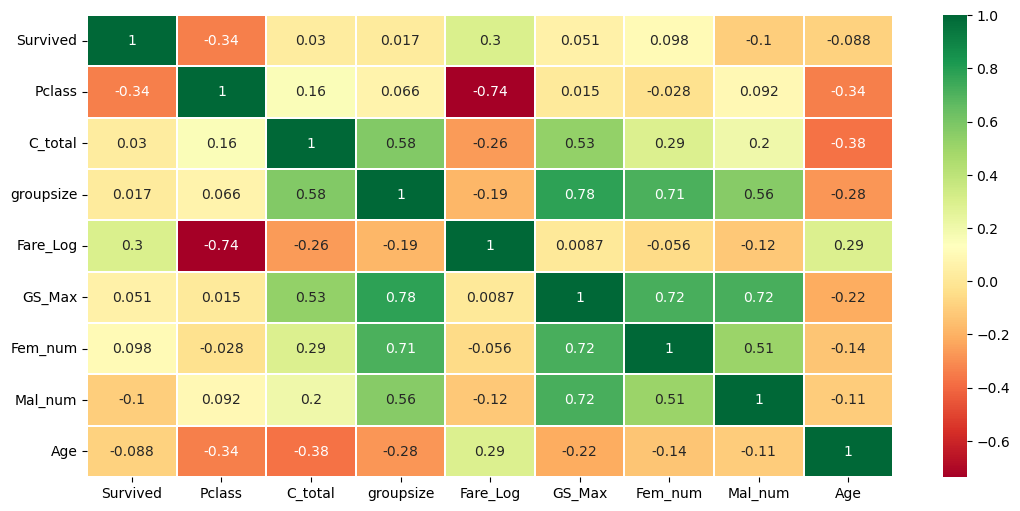

In [42]:
fig, ax = plt.subplots(figsize=(13,6) )
dataplot = sns.heatmap(dfv01.corr(), ax=ax,annot=True,cmap='RdYlGn',linewidths=0.1)
plt.show()

<Axes: xlabel='C_total', ylabel='count'>

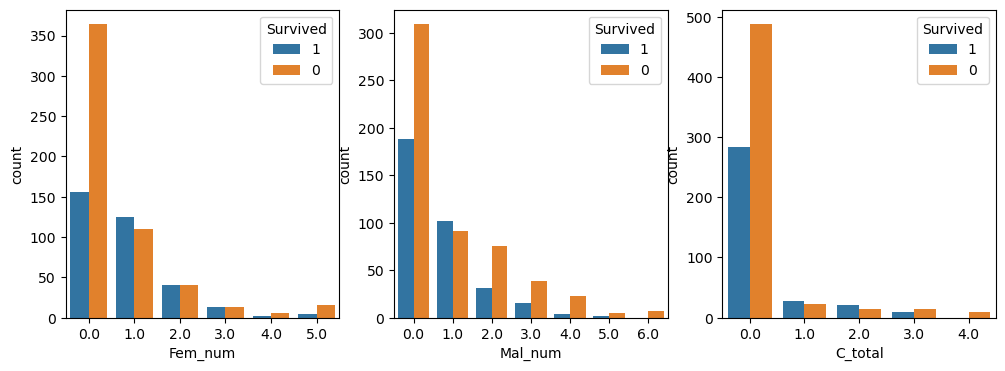

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
sns.countplot(data=dfv01,x="Fem_num", hue="Survived", hue_order= [1, 0], ax=axes[0])
sns.countplot(data=dfv01, x="Mal_num", hue="Survived",hue_order= [1, 0],  ax=axes[1])
sns.countplot(data=dfv01, x="C_total", hue="Survived",hue_order= [1, 0],  ax=axes[2])

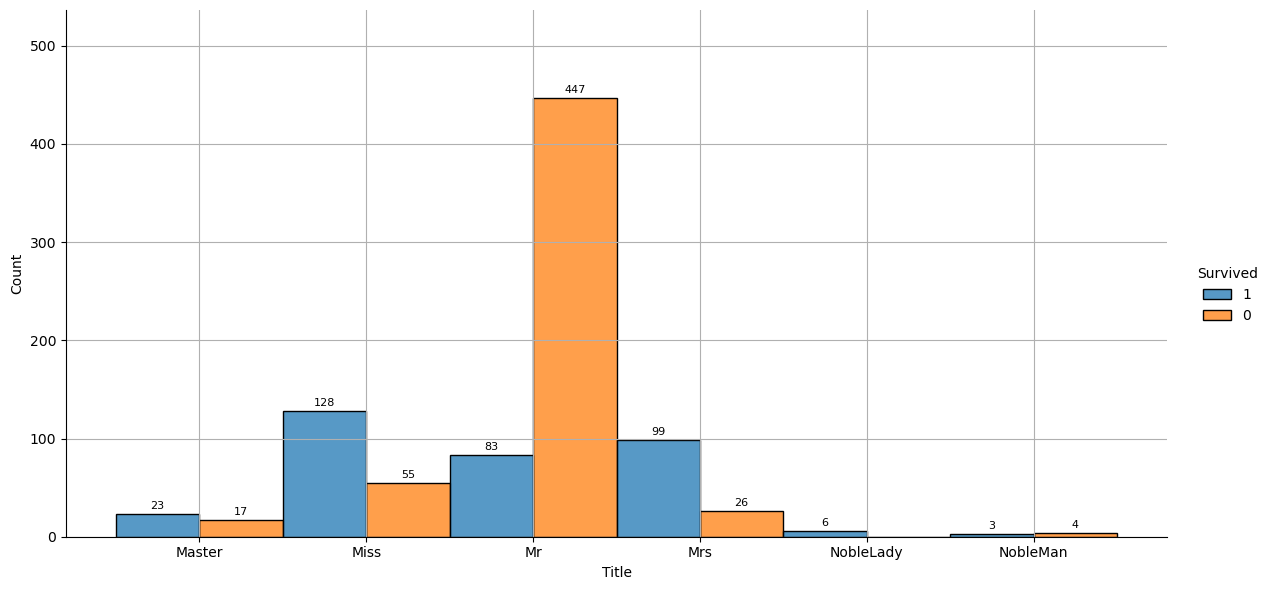

In [44]:
ax=sns.displot( dfv01 , x = 'Title', hue='Survived' , height=6, multiple="dodge", aspect=2,hue_order= [1, 0])

plt.grid() 
show_values(ax)

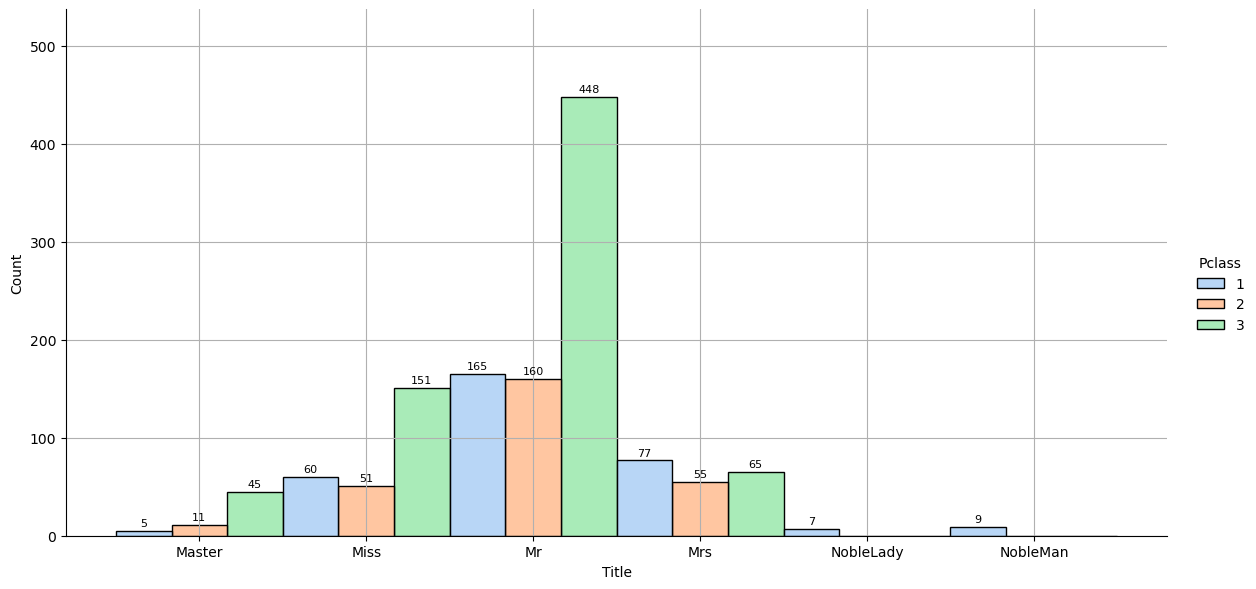

In [45]:
ax=sns.displot( df_full , x = 'Title', hue='Pclass' , palette=sns.color_palette("pastel",3),
               height=6, multiple="dodge", aspect=2 )

plt.grid() 
show_values(ax)

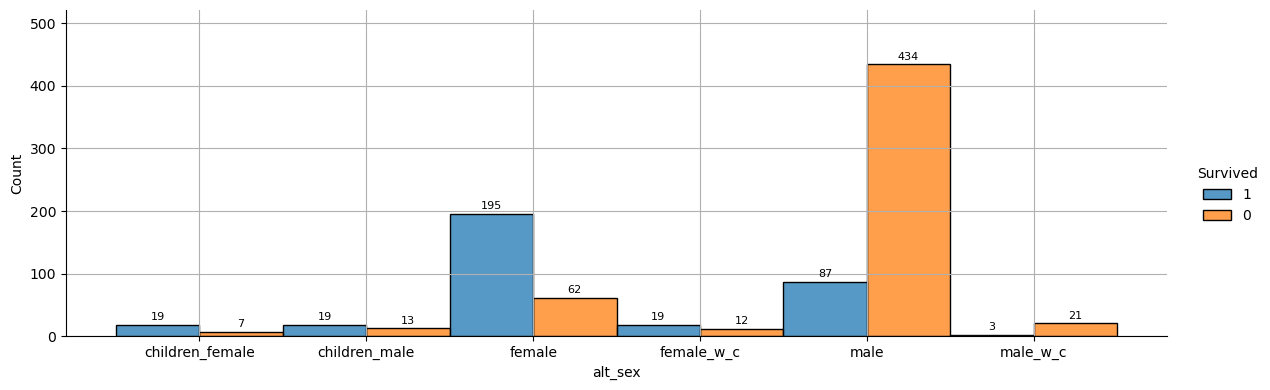

In [46]:
ax=sns.displot( dfv01 , x = 'alt_sex', hue='Survived' , multiple="dodge", height=4, aspect=3,hue_order= [1, 0])

plt.grid() 
show_values(ax)

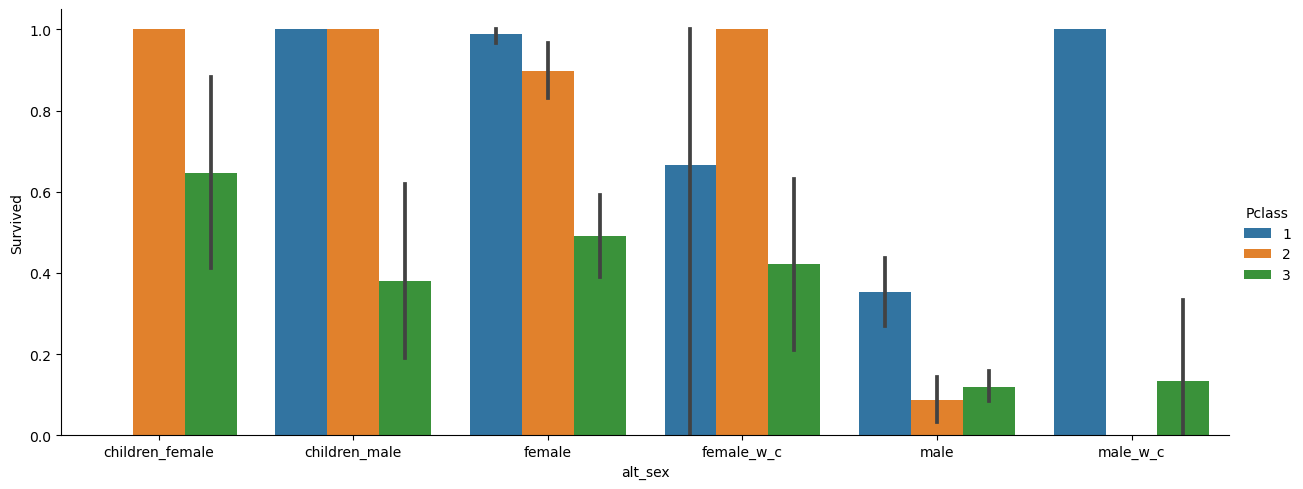

In [47]:
sns.catplot(data=dfv01, x="alt_sex", y="Survived", hue="Pclass", kind="bar",aspect=2.5)

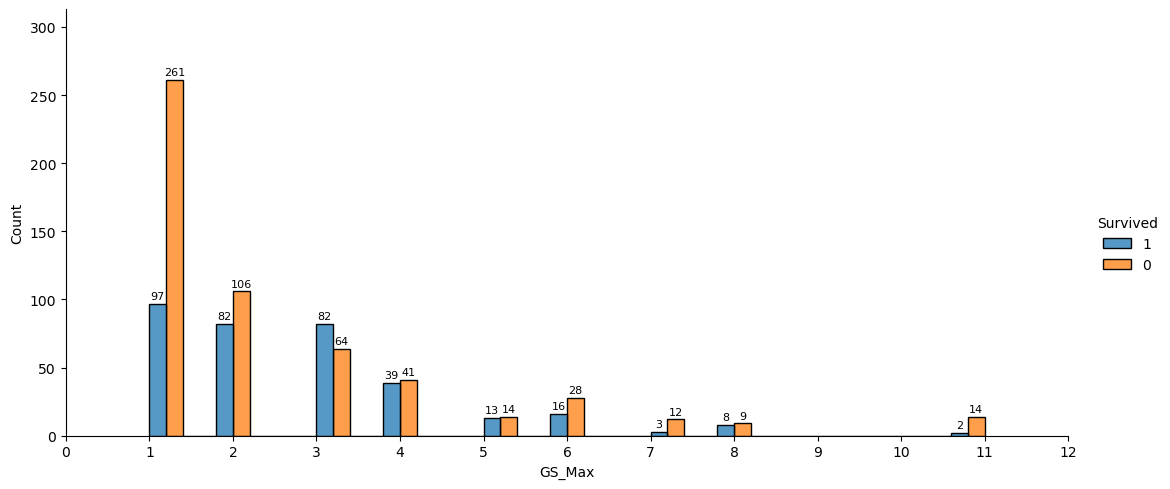

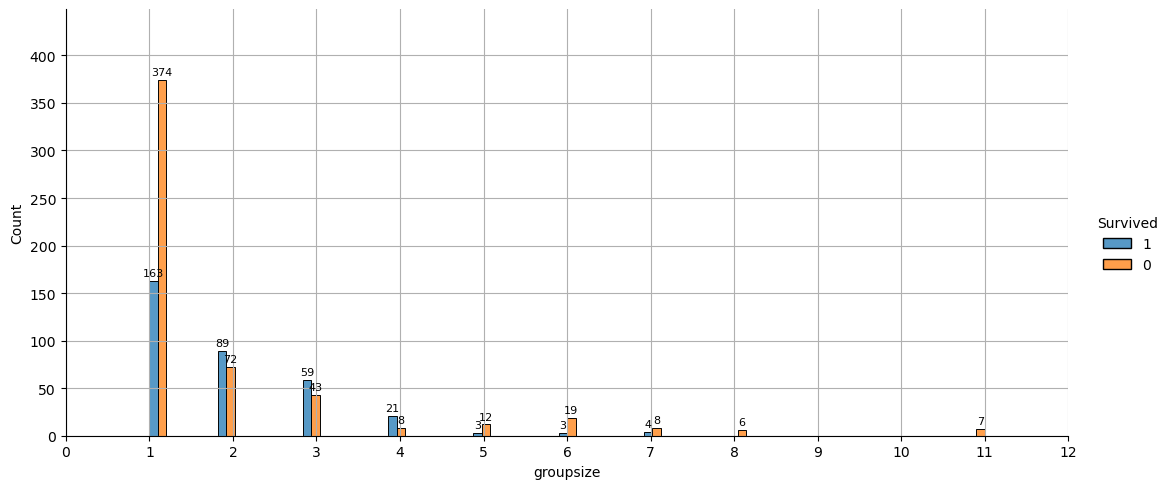

In [48]:
ax=sns.displot( dfv01 , x = 'GS_Max', hue='Survived' ,multiple="dodge", hue_order= [1, 0],
              height=5, aspect=2.2)
ax.set(xticks=[x for x in range(int(dfv01['GS_Max'].min())-1,int(dfv01['GS_Max'].max())+2,1)])

ax2=sns.displot( dfv01 , x = 'groupsize', hue='Survived' ,multiple="dodge", hue_order= [1, 0],
              height=5, aspect=2.2)
ax2.set(xticks=[x for x in range(int(dfv01['GS_Max'].min())-1,int(dfv01['GS_Max'].max())+2,1)])

plt.grid() 
show_values(ax)
show_values(ax2)

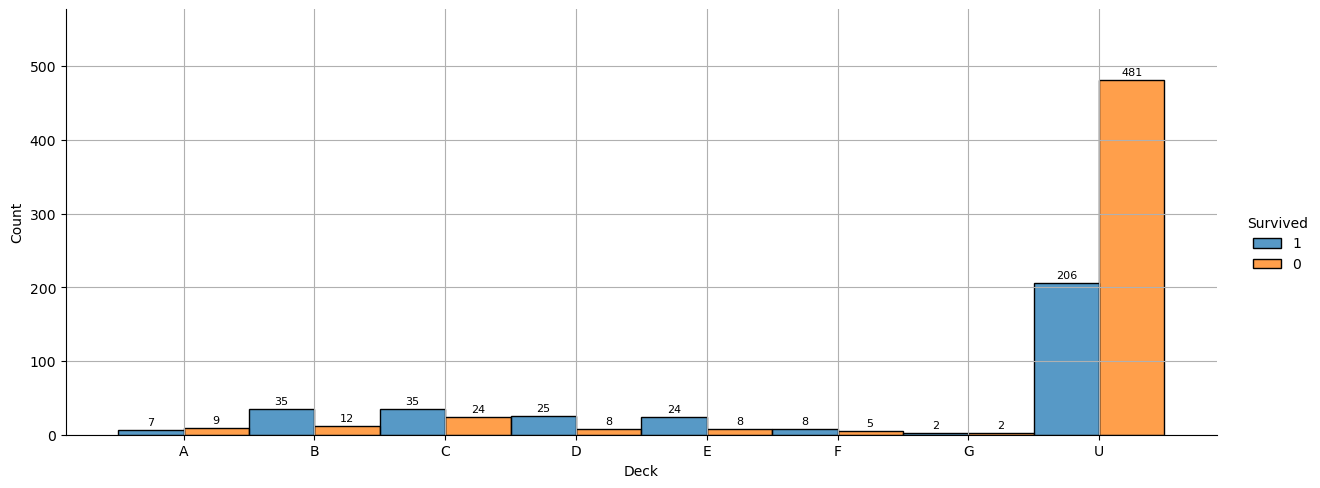

In [49]:
ax=sns.displot( dfv01 , x = 'Deck', hue='Survived' ,multiple="dodge", hue_order= [1, 0],
              height=5, aspect=2.5)

plt.grid() 
show_values(ax)

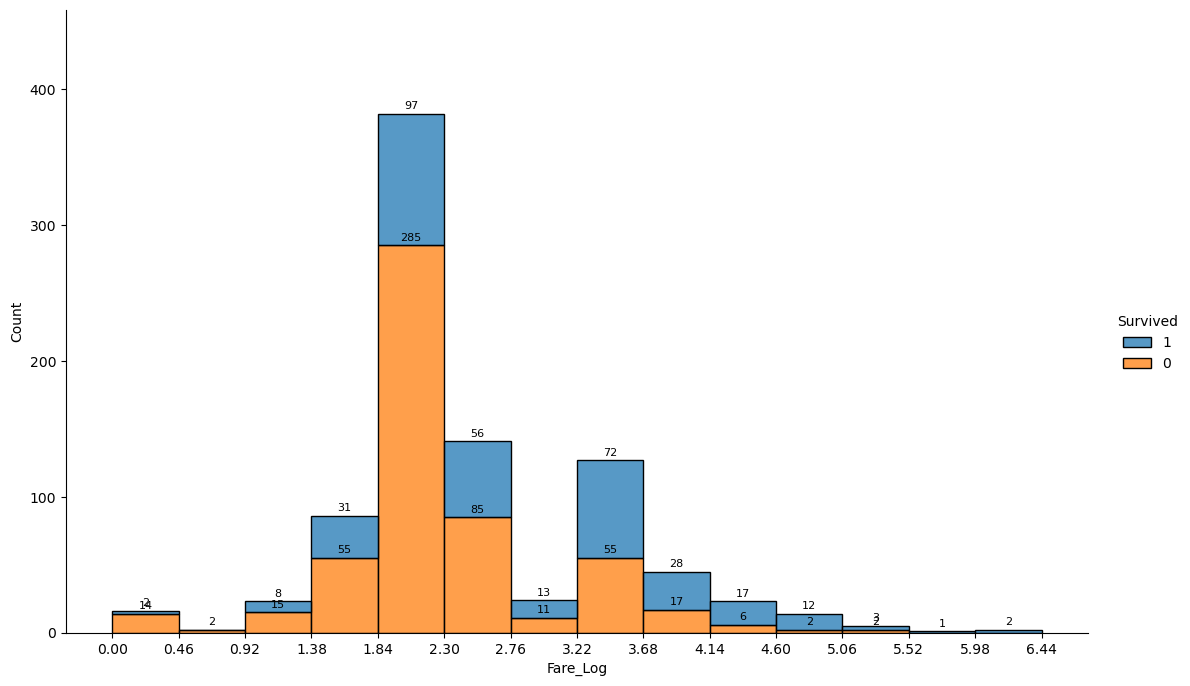

In [50]:
ax=sns.displot(data=dfv01,  x='Fare_Log',bins=[x/100 for x in range(0,650,46)],
            hue='Survived',multiple="stack",hue_order= [1, 0],  height=7, aspect=1.6,
             palette=sns.color_palette()).set_titles("survived")
plt.xticks([x/100 for x in range(0,650,46)])

show_values(ax)

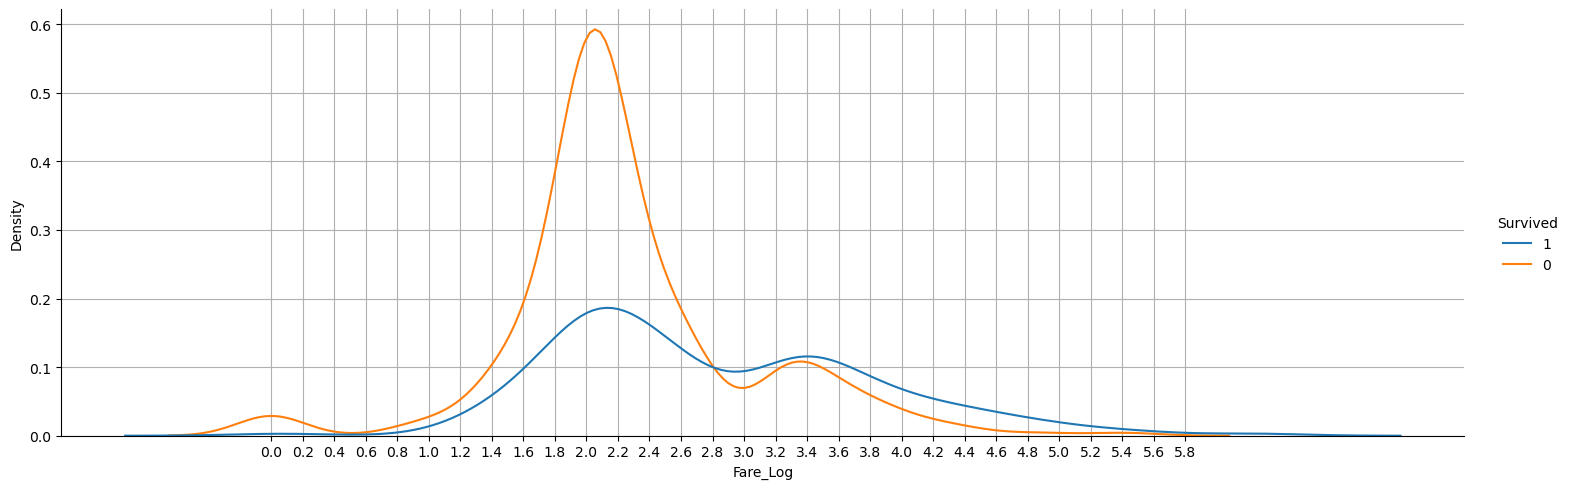

In [51]:
ax=sns.displot( dfv01 , x = 'Fare_Log', hue='Survived' ,hue_order= [1, 0], kind = 'kde',aspect=3)
ax.set(xticks=[x/10 for x in range(int(dfv01['Fare_Log'].min())*10,int(dfv01['Fare_Log'].max())*10,2)])
plt.grid() 
plt.show()

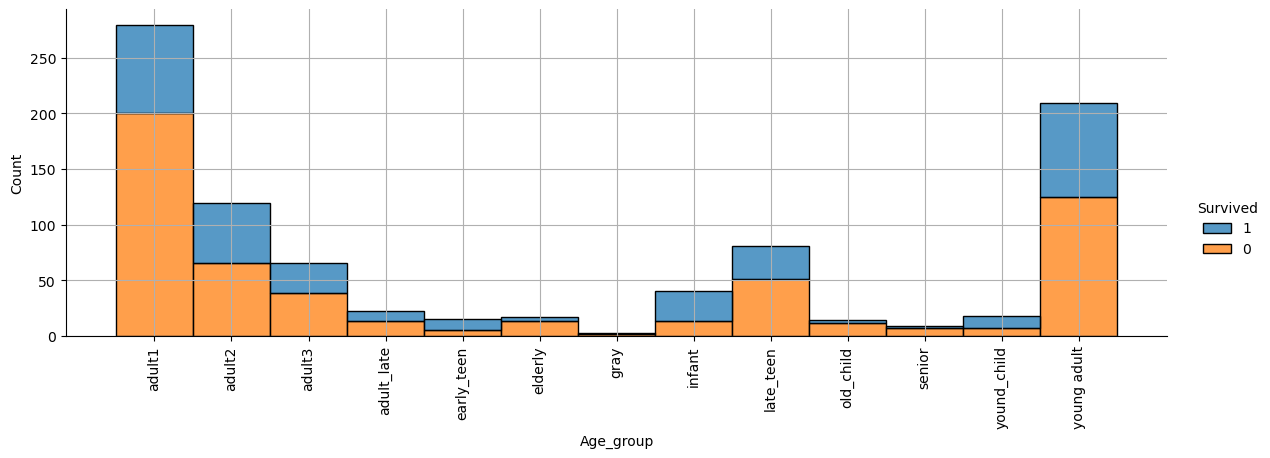

In [52]:
ax=sns.displot( dfv01 , x = 'Age_group', hue='Survived' ,height=4, aspect=3, multiple='stack',hue_order= [1, 0])
plt.xticks(rotation=90)
plt.grid() 
plt.show()

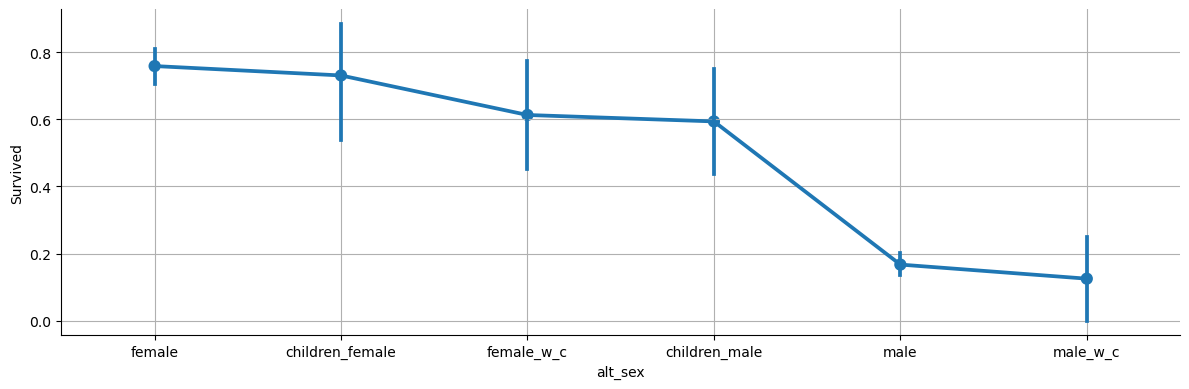

In [53]:
sns.catplot( dfv01 , x = 'alt_sex', y='Survived' , kind = 'point',height=4, aspect=3,
           order=[ 'female','children_female', 'female_w_c','children_male', 'male', 'male_w_c'])
plt.grid() 
plt.show()

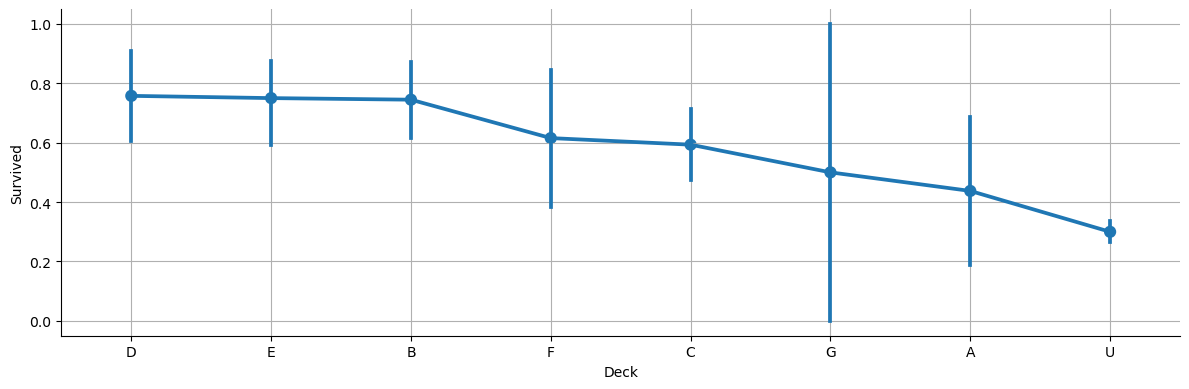

In [54]:
sns.catplot( dfv01 , x = 'Deck', y='Survived' , kind = 'point',aspect=3,height=4,
           order=['D','E','B','F','C','G','A','U'])
plt.grid() 
plt.show()

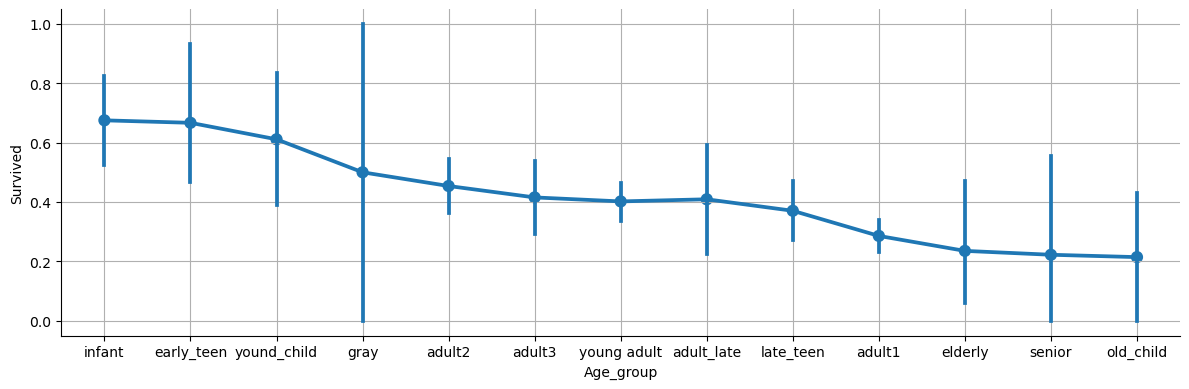

In [55]:
sns.catplot( dfv01 , x = 'Age_group', y='Survived' , kind = 'point',aspect=3,height=4,
           order=['infant','early_teen','yound_child','gray','adult2','adult3','young adult',
                    'adult_late','late_teen','adult1','elderly','senior','old_child'])
plt.grid() 
plt.show()

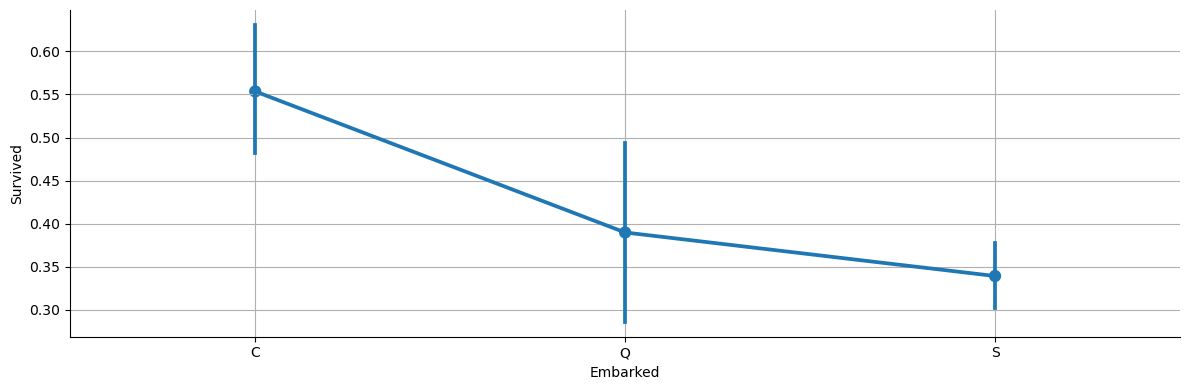

In [56]:
sns.catplot( dfv01 , x = 'Embarked', y='Survived' , kind = 'point',aspect=3,height=4,
           order=['C', 'Q','S'])
plt.grid() 
plt.show()

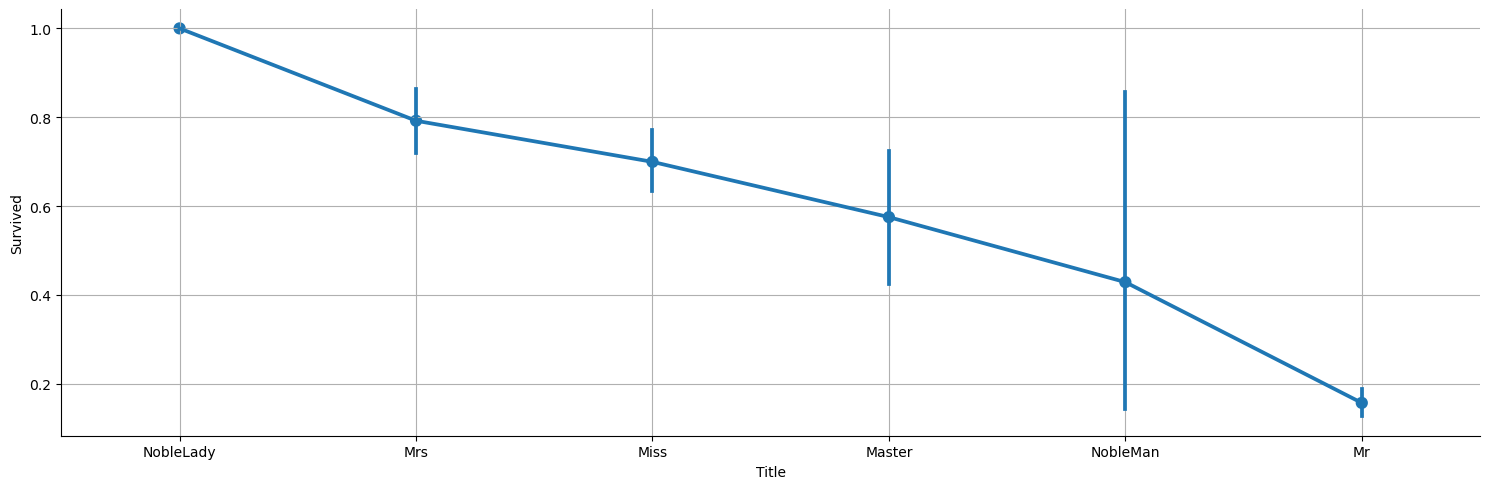

In [57]:
sns.catplot( dfv01 , x = 'Title', y='Survived' , kind = 'point',aspect=3,
           order=['NobleLady','Mrs','Miss','Master','NobleMan','Mr'])
plt.grid() 
plt.show()

In [58]:
dfv01_unencoded=dfv01.copy()

#### encoding category columns

In [59]:
class ordinal:
    "takes dataframe and list of features to be encoded and onehot encode"
    def __init__(self,X, category_columns_X):
        self.X=X
        self.category_columns_X=category_columns_X
        self.Age_group=['infant','early_teen','yound_child','gray','adult2','adult3','young adult',
        'adult_late','late_teen','adult1','elderly','senior','old_child']
        self.Embarked=['C', 'Q','S',]
        self.Deck=['D','E','B','F','C','G','A','U']
        self.Title=['NobleLady','Mrs','Miss','Master','NobleMan','Mr']
        self.Sex=['female','male']
        self.alt_sex=['female','children_female', 'female_w_c','children_male', 'male', 'male_w_c']
        self.column_to_cat = {
            "Age_group":self.Age_group,
            "Embarked": self.Embarked,
            "Deck": self.Deck,
            "Title": self.Title,
            "Sex":self.Sex,
            "alt_sex":self.alt_sex
            }
        
        self.mapper_df = DataFrameMapper(
            [
             ([col], 
                  OrdinalEncoder(categories = [cat], dtype=np.int8)) for col, cat in self.column_to_cat.items()
            ],
            df_out=True
        )
        self.mapper_df.fit(self.X[self.category_columns_X])
        
    def encode(self,X):

        X[["Age_group","Embarked","Deck",
           "Title","Sex","alt_sex"]]=self.mapper_df.transform(X[self.category_columns_X])
        
        return X

In [60]:
category_columns_X = dfv01.select_dtypes(['category']).columns
encoder=ordinal(df_full,category_columns_X)

dfv01=encoder.encode(dfv01)
display(dfv01.head(2))
display(dfv01.shape)

Survived  Pclass  Age_group  Embarked  Deck  alt_sex  C_total  groupsize  \
0         0       3          6         2     7        4      0.0          2   
1         1       1          4         0     4        0      0.0          2   

   Title  Fare_Log  GS_Max  Fem_num  Mal_num  Sex   Age  
0      5  1.287854       2      0.0      2.0    1  22.0  
1      1  3.573515       2      1.0      1.0    0  38.0

(891, 15)

In [61]:
encoder.mapper_df.transformed_names_

['Age_group', 'Embarked', 'Deck', 'Title', 'Sex', 'alt_sex']

In [62]:
for name in encoder.mapper_df.transformed_names_:
    print(f"{name},{dfv01[name].unique()}")

Age_group,[ 6  4  9  7  0  1  2  8 10  5 12 11  3]
Embarked,[2 0 1]
Deck,[7 4 1 5 0 6 2 3]
Title,[5 1 2 3 4 0]
Sex,[1 0]
alt_sex,[4 0 3 2 1 5]


In [63]:
df_full=encoder.encode(df_full)

In [64]:
class binning:
    def __init__(self,X, feature, bins):
        self.X=X
        self.feature=feature
        self.bins=bins
        
        self.kbin = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
        self.kbin_category_  = self.kbin.fit(self.X[[self.feature]])
        self.bin_edges_=self.kbin_category_.bin_edges_
        
    
    def bin_quantile(self, X):
        kbin_category_data=self.kbin_category_.transform(X[[self.feature]])
        binned_column='binned_'+self.feature
        X=X.join(pd.DataFrame(kbin_category_data, columns=[binned_column]))
        return X

In [65]:
display(dfv01.info())
#dfv01=bin_maker.bin(dfv01)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Age_group  891 non-null    int8   
 3   Embarked   891 non-null    int8   
 4   Deck       891 non-null    int8   
 5   alt_sex    891 non-null    int8   
 6   C_total    891 non-null    float64
 7   groupsize  891 non-null    int64  
 8   Title      891 non-null    int8   
 9   Fare_Log   891 non-null    float64
 10  GS_Max     891 non-null    int64  
 11  Fem_num    891 non-null    float64
 12  Mal_num    891 non-null    float64
 13  Sex        891 non-null    int8   
 14  Age        891 non-null    float64
dtypes: float64(5), int64(4), int8(6)
memory usage: 68.0 KB


None

In [66]:
#seeking for bins that have breaking points at around 2.9 as rate of survival > rate of death after this point
for i in range (2,30):
    bin_maker_fare=binning(df_full, 'Fare_Log', i)
    print(f"{i}, bins: {bin_maker_fare.bin_edges_}")

2, bins: [array([0.        , 2.89480364, 6.23896739])]
3, bins: [array([0.        , 2.45933054, 3.63319718, 6.23896739])]
4, bins: [array([0.        , 1.72400808, 2.82521002, 4.10358243, 6.23896739])]
5, bins: [array([0.        , 1.20853762, 2.22761539, 3.00298275, 4.11307651,
        6.23896739])                                               ]
6, bins: [array([0.        , 1.20853762, 2.224891  , 2.95838709, 3.80814722,
        4.73614121, 6.23896739])                                   ]
7, bins: [array([0.        , 0.7743174 , 1.8410566 , 2.69232873, 3.50031162,
        4.1308304 , 4.94829012, 6.23896739])                       ]
8, bins: [array([0.        , 0.75396175, 1.75843576, 2.2909695 , 2.94993482,
        3.68675803, 4.38209546, 5.14967998, 6.23896739])           ]
9, bins: [array([0.        , 0.75396175, 1.75822612, 2.2884773 , 2.92038984,
        3.55215507, 4.102177  , 4.76589635, 5.45487576, 6.23896739])]
10, bins: [array([0.        , 0.57158607, 1.34278022, 1.81351243, 2.

In [67]:
bin_maker_fare=binning(df_full, 'Fare_Log', 13)

In [68]:
dfv01=bin_maker_fare.bin_quantile(dfv01)
display(dfv01.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Pclass           891 non-null    int64  
 2   Age_group        891 non-null    int8   
 3   Embarked         891 non-null    int8   
 4   Deck             891 non-null    int8   
 5   alt_sex          891 non-null    int8   
 6   C_total          891 non-null    float64
 7   groupsize        891 non-null    int64  
 8   Title            891 non-null    int8   
 9   Fare_Log         891 non-null    float64
 10  GS_Max           891 non-null    int64  
 11  Fem_num          891 non-null    float64
 12  Mal_num          891 non-null    float64
 13  Sex              891 non-null    int8   
 14  Age              891 non-null    float64
 15  binned_Fare_Log  891 non-null    float64
dtypes: float64(6), int64(4), int8(6)
memory usage: 75.0 KB


None

In [69]:
df_full=bin_maker_fare.bin_quantile(df_full)

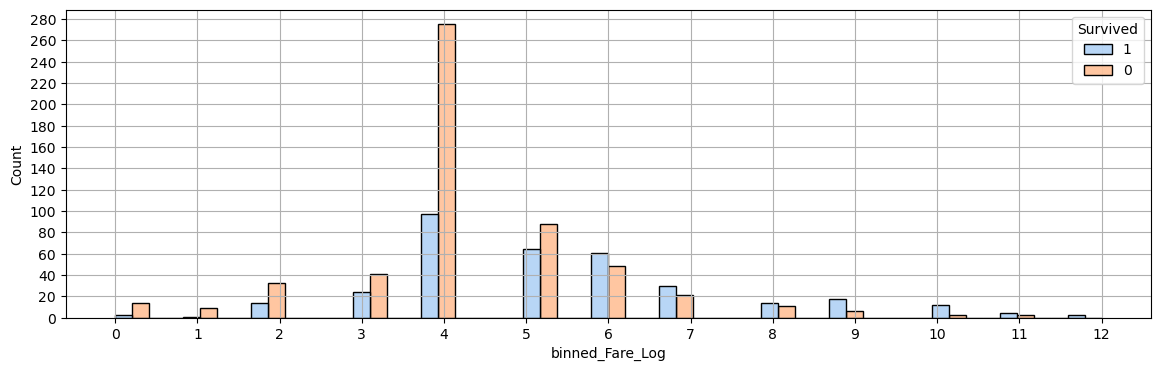

In [70]:
fig, axes = plt.subplots(figsize=(14,4))
ax=sns.histplot(data=dfv01, x='binned_Fare_Log', hue='Survived',multiple="dodge", hue_order= [1, 0],
               palette=sns.color_palette("pastel",3))
plt.yticks([x for x in range(0,300,20)])
plt.xticks(dfv01['binned_Fare_Log'].unique())
plt.grid()

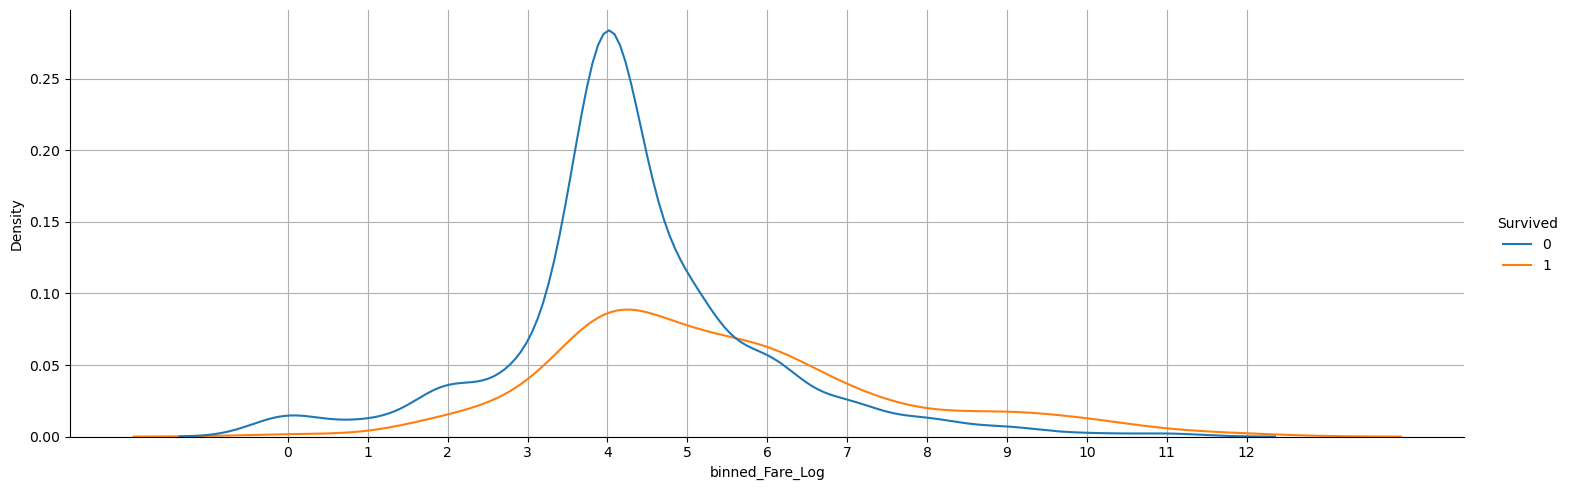

In [71]:
ax=sns.displot(data=dfv01, x = 'binned_Fare_Log', 
               hue='Survived' , kind = 'kde',aspect=3,palette=sns.color_palette())
ax.set(xticks=dfv01['binned_Fare_Log'].unique())
plt.grid() 
plt.show()

In [72]:
display(dfv01.isnull().values.any())

False

In [73]:
dfv01.columns

Index(['Survived', 'Pclass', 'Age_group', 'Embarked', 'Deck', 'alt_sex',
       'C_total', 'groupsize', 'Title', 'Fare_Log', 'GS_Max', 'Fem_num',
       'Mal_num', 'Sex', 'Age', 'binned_Fare_Log'],
      dtype='object')

#### Creating feature and target dataframes

In [74]:
dfv01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Pclass           891 non-null    int64  
 2   Age_group        891 non-null    int8   
 3   Embarked         891 non-null    int8   
 4   Deck             891 non-null    int8   
 5   alt_sex          891 non-null    int8   
 6   C_total          891 non-null    float64
 7   groupsize        891 non-null    int64  
 8   Title            891 non-null    int8   
 9   Fare_Log         891 non-null    float64
 10  GS_Max           891 non-null    int64  
 11  Fem_num          891 non-null    float64
 12  Mal_num          891 non-null    float64
 13  Sex              891 non-null    int8   
 14  Age              891 non-null    float64
 15  binned_Fare_Log  891 non-null    float64
dtypes: float64(6), int64(4), int8(6)
memory usage: 75.0 KB


In [75]:
features_f=['Pclass', 'Embarked', 'Deck', 'alt_sex','Fare_Log','groupsize','C_total', 'Title',
            'GS_Max', 'Fem_num', 'Mal_num', 'Age_group', 'binned_Fare_Log','Sex','Age'] # 'binned_Age',

y = dfv01[["Survived"]]
X = dfv01[features_f]
display(X.shape)
display(y.shape)

(891, 15)

(891, 1)

In [76]:
df_full=df_full[features_f]

#### Performing splits

In [77]:
#valid dataset is only for xgboost/catboost early stop overfit detectors so will make it small
X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                  y,
                                                  test_size=0.30,
                                                  random_state=2,
                                                  shuffle=True,
                                                  stratify=y
                                                  )
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,
                                                    y_rem,
                                                    test_size=0.67,
                                                    random_state=2,
                                                    shuffle=True,
                                                    stratify=y_rem
                                                    )
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
None

(623, 15) (623, 1)
(88, 15) (88, 1)
(180, 15) (180, 1)


In [78]:
print(X_train.info())
print(X_valid.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 111 to 424
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pclass           623 non-null    int64  
 1   Embarked         623 non-null    int8   
 2   Deck             623 non-null    int8   
 3   alt_sex          623 non-null    int8   
 4   Fare_Log         623 non-null    float64
 5   groupsize        623 non-null    int64  
 6   C_total          623 non-null    float64
 7   Title            623 non-null    int8   
 8   GS_Max           623 non-null    int64  
 9   Fem_num          623 non-null    float64
 10  Mal_num          623 non-null    float64
 11  Age_group        623 non-null    int8   
 12  binned_Fare_Log  623 non-null    float64
 13  Sex              623 non-null    int8   
 14  Age              623 non-null    float64
dtypes: float64(6), int64(3), int8(6)
memory usage: 52.3 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Ind

In [79]:
scaler=MinMaxScaler()
scaler_fitted=scaler.fit(df_full)
Xt_train = pd.DataFrame(scaler_fitted.transform(X_train), columns = X_train.columns)
Xt_valid= pd.DataFrame(scaler_fitted.transform(X_valid), columns = X_valid.columns)
Xt_test = pd.DataFrame(scaler_fitted.transform(X_test), columns = X_test.columns)

In [80]:
Xt_train.head(2)

Pclass  Embarked  Deck  alt_sex  Fare_Log  groupsize  C_total  Title  \
0     1.0       0.0   1.0      0.0  0.317014        0.1      0.0    0.4   
1     0.5       1.0   1.0      0.8  0.411118        0.0      0.0    1.0   

   GS_Max  Fem_num  Mal_num  Age_group  binned_Fare_Log  Sex       Age  
0     0.1      0.4      0.0   0.083333         0.333333  0.0  0.179506  
1     0.0      0.0      0.0   0.750000         0.416667  1.0  0.423776

In [81]:
print(Xt_train.isnull().values.any(), Xt_test.isnull().values.any(), Xt_valid.isnull().values.any())
print(Xt_train.shape, Xt_test.shape, Xt_valid.shape)

False False False
(623, 15) (180, 15) (88, 15)


# Feature Evaluation & Selection

|Models to test and fine tune and stack:|Approach|
|:-|:-|
|Random Forest Classifier ,<br />XGBoost Classifier,<br /> Support Vector Classifier | * Run chi2, mutual info gain and check pearson correlation matrix to look for redundant features, <br /> * Run exhaustive feature search with gridsearchcv for semi tunning and model base feature selection <br />  * Do final tunning with selected feature set, <br /> * Stack all models, submit individual & stacked model results. |

#### I will combine train+valid set and train with cv. 

In [82]:
X_train_whole=pd.concat([Xt_train,Xt_valid],ignore_index=True, sort=False)

In [83]:
y_train_whole=pd.concat([y_train,y_valid],ignore_index=True, sort=False)

In [84]:
print(X_train_whole.columns, len(X_train_whole.columns))

Index(['Pclass', 'Embarked', 'Deck', 'alt_sex', 'Fare_Log', 'groupsize',
       'C_total', 'Title', 'GS_Max', 'Fem_num', 'Mal_num', 'Age_group',
       'binned_Fare_Log', 'Sex', 'Age'],
      dtype='object') 15


In [85]:
dfv01_unencoded.describe(include='all').T

count unique     top freq       mean        std   min        25%  \
Survived   891.0    NaN     NaN  NaN   0.383838   0.486592   0.0        0.0   
Pclass     891.0    NaN     NaN  NaN   2.308642   0.836071   1.0        2.0   
Age_group    891     13  adult1  280        NaN        NaN   NaN        NaN   
Embarked     891      3       S  646        NaN        NaN   NaN        NaN   
Deck         891      8       U  687        NaN        NaN   NaN        NaN   
alt_sex      891      6    male  521        NaN        NaN   NaN        NaN   
C_total    891.0    NaN     NaN  NaN   0.255892   0.740222   0.0        0.0   
groupsize  891.0    NaN     NaN  NaN   1.904602   1.613459   1.0        1.0   
Title        891      6      Mr  530        NaN        NaN   NaN        NaN   
Fare_Log   891.0    NaN     NaN  NaN   2.467325   0.901662   0.0   1.981001   
GS_Max     891.0    NaN     NaN  NaN   2.590348   2.050891   1.0        1.0   
Fem_num    891.0    NaN     NaN  NaN   0.683502   1.064624   0.0        0.0   
Mal_num    891.0    NaN     NaN  NaN   0.843996   1.221215   0.0        0.0   
Sex          891      2    male  577        NaN        NaN   NaN        NaN   
Age        891.0    NaN     NaN  NaN  29.793343  13.278035  0.42  21.803744   

                50%       75%       max  
Survived        0.0       1.0       1.0  
Pclass          3.0       3.0       3.0  
Age_group       NaN       NaN       NaN  
Embarked        NaN       NaN       NaN  
Deck            NaN       NaN       NaN  
alt_sex         NaN       NaN       NaN  
C_total         0.0       0.0       4.0  
groupsize       1.0       2.0      11.0  
Title           NaN       NaN       NaN  
Fare_Log   2.116256  3.164068  6.238967  
GS_Max          2.0       3.0      11.0  
Fem_num         0.0       1.0       5.0  
Mal_num         0.0       1.0       6.0  
Sex             NaN       NaN       NaN  
Age            30.0      36.0      80.0

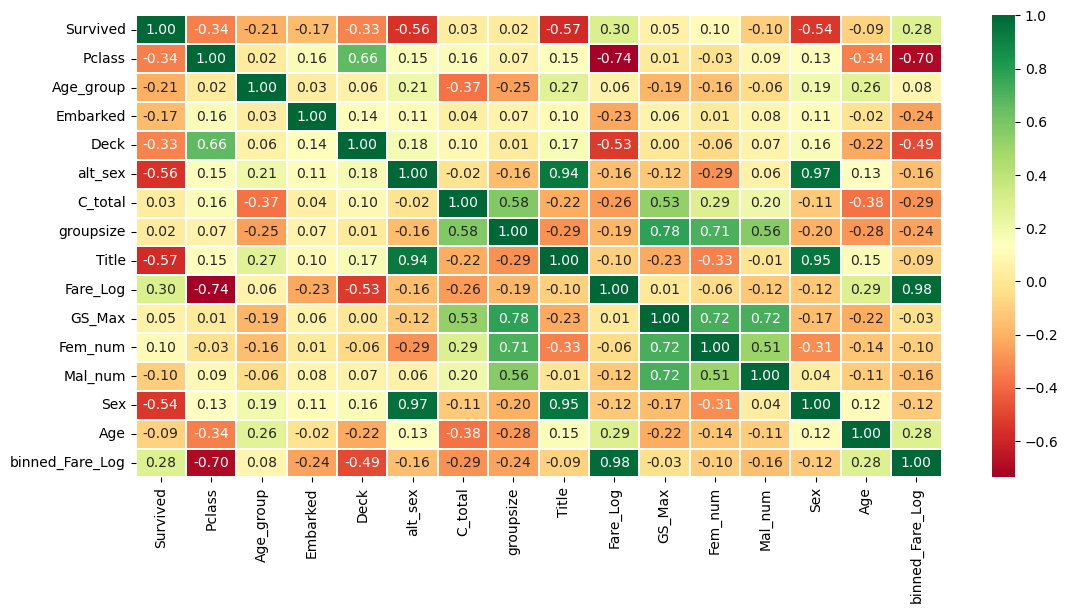

In [86]:
fig, ax = plt.subplots(figsize=(13,6) )
cormat=dfv01.corr()
dataplot = sns.heatmap(cormat, ax=ax,annot=True,cmap='RdYlGn',linewidths=0.1,fmt='.2f')
plt.show()

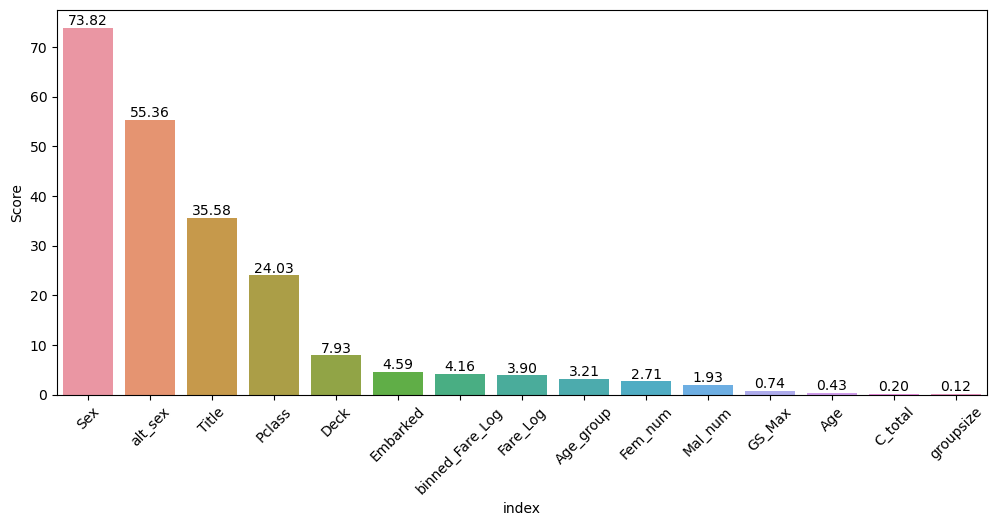

In [87]:
chi2test=SelectKBest(chi2, k='all').fit(X_train_whole, y_train_whole.values.ravel())
chi2test_vals={}
for i in range(len(chi2test.scores_)):
    chi2test_vals[chi2test.feature_names_in_[i]]=chi2test.scores_[i]
chi2test_vals_df=pd.DataFrame.from_dict(chi2test_vals, orient='index',columns=['Score'])
chi2test_vals_df=chi2test_vals_df.sort_values('Score',ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
chi2test_vals_chart=sns.barplot(data=chi2test_vals_df,x='index',y='Score')
chi2test_vals_chart.bar_label(ax.containers[0],fmt='%.2f')
for item in chi2test_vals_chart.get_xticklabels():
    item.set_rotation(45)


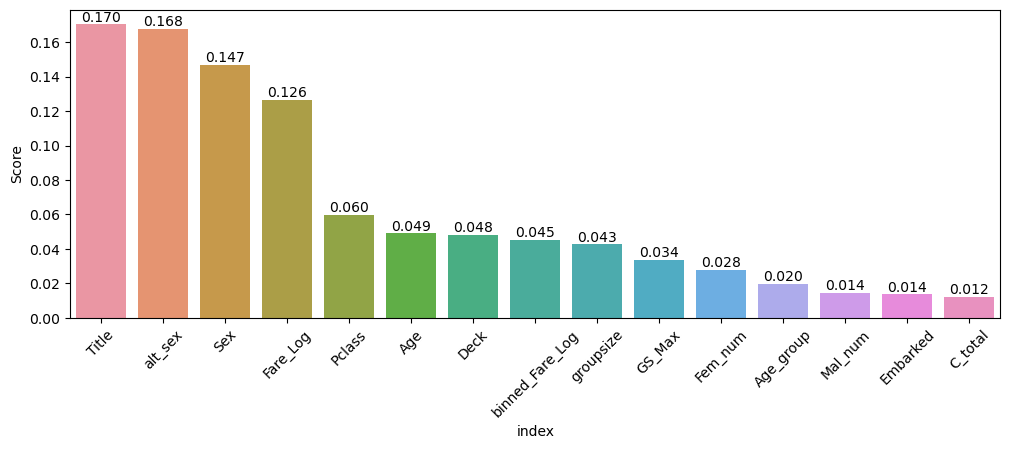

In [88]:
def mutual_info_mean(n_iter):
    info_df=pd.DataFrame(None)
    for i in range(0,n_iter):
        kbest=SelectKBest(mutual_info_classif, k="all").fit(X_train_whole, y_train_whole.values.ravel())
        kbest_vals={}
        for i in range(len(kbest.scores_)):
            kbest_vals[kbest.feature_names_in_[i]]=kbest.scores_[i]
        kbest_vals_df=pd.DataFrame.from_dict(kbest_vals, orient='index',columns=['Score'])
        info_df=info_df.append(kbest_vals_df)
    
    return info_df.reset_index().groupby(['index'])['Score'].mean().reset_index()
#taking mean value of multiple runs for better consistency
kbest_vals_df=mutual_info_mean(50)
kbest_vals_df=kbest_vals_df.sort_values('Score',ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(12, 4))
kbest_vals_chart=sns.barplot(data=kbest_vals_df,x='index',y='Score')
kbest_vals_chart.bar_label(ax.containers[0],fmt='%.3f')
for item in kbest_vals_chart.get_xticklabels():
    item.set_rotation(45)

#### Evaluation for low info gain features & choisng between alternative feature transformations.

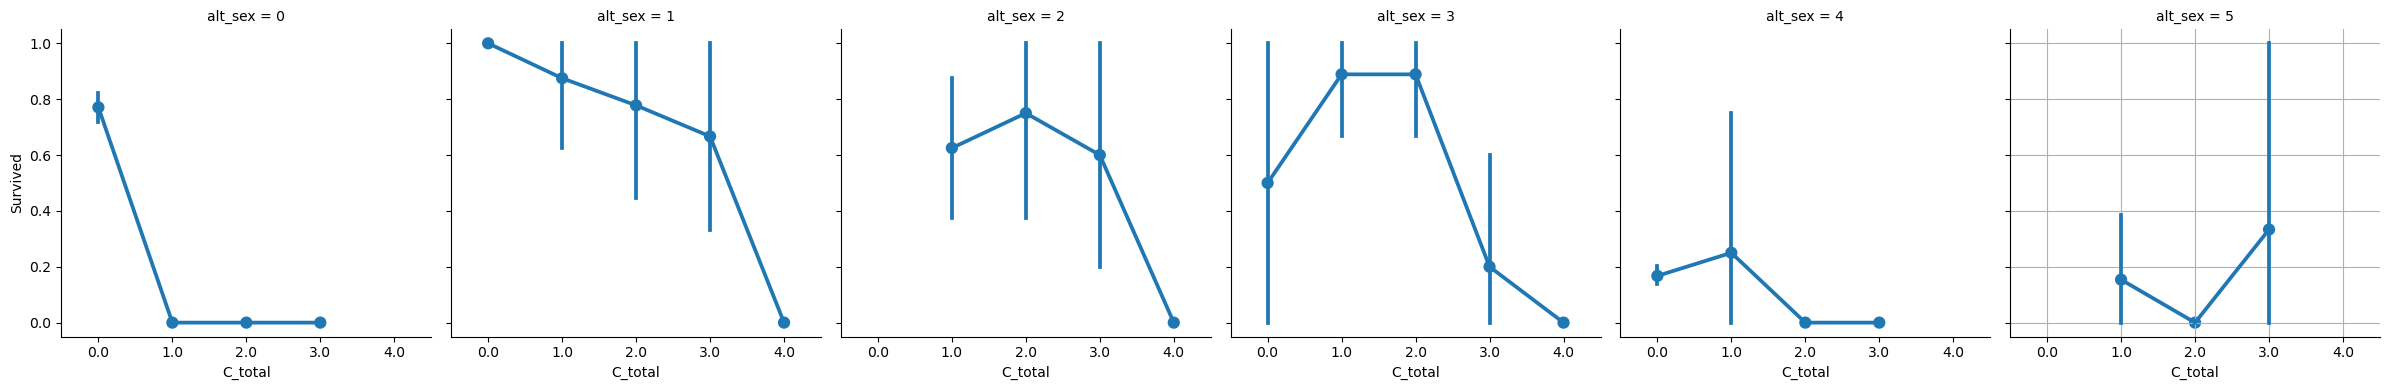

In [89]:
#Encoding order: ['female','children_female', 'female_w_c','children_male', 'male', 'male_w_c']
sns.catplot( dfv01 , x = 'C_total', y='Survived' , kind = 'point',height=4, col='alt_sex')
plt.grid() 
plt.show()

C_total: wheather or not a given male or female have a kid encoded in alt sex so no need this feature to mark caretakers. my assumption for keeping having more kid means can create more burden means lower self survival rate for adults with kid, also a kid have a sibling means parents attention is divided therefore there could be lesser survival for chance for kids with siblings. graphs doesn't show justification and chi & mutual info low. how ever if alt_sex is eleminated as the result of exhaustive feature search then this is the only indicator whether person travelling with a children.

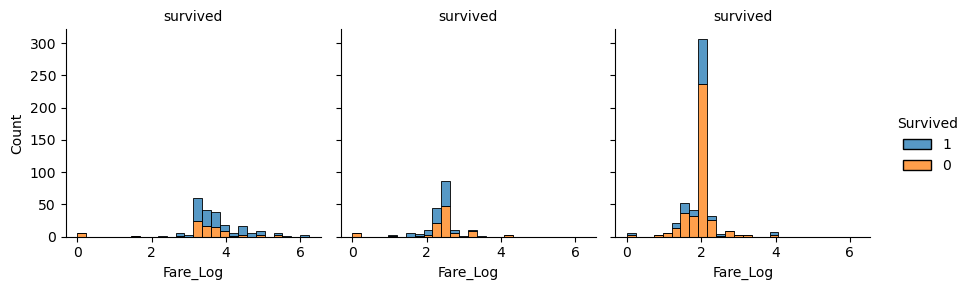

In [90]:
sns.displot(data=dfv01,  x='Fare_Log', hue='Survived',multiple="stack",  hue_order= [1, 0],
            col='Pclass',height=3,palette=sns.color_palette()).set_titles("survived")
plt.show()

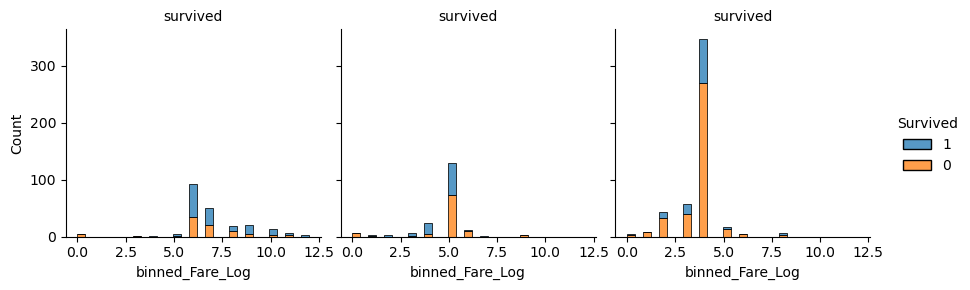

In [91]:
sns.displot(data=dfv01,  x='binned_Fare_Log', hue='Survived',multiple="stack",  hue_order= [1, 0],
            col='Pclass',height=3,palette=sns.color_palette()).set_titles("survived")
plt.show()

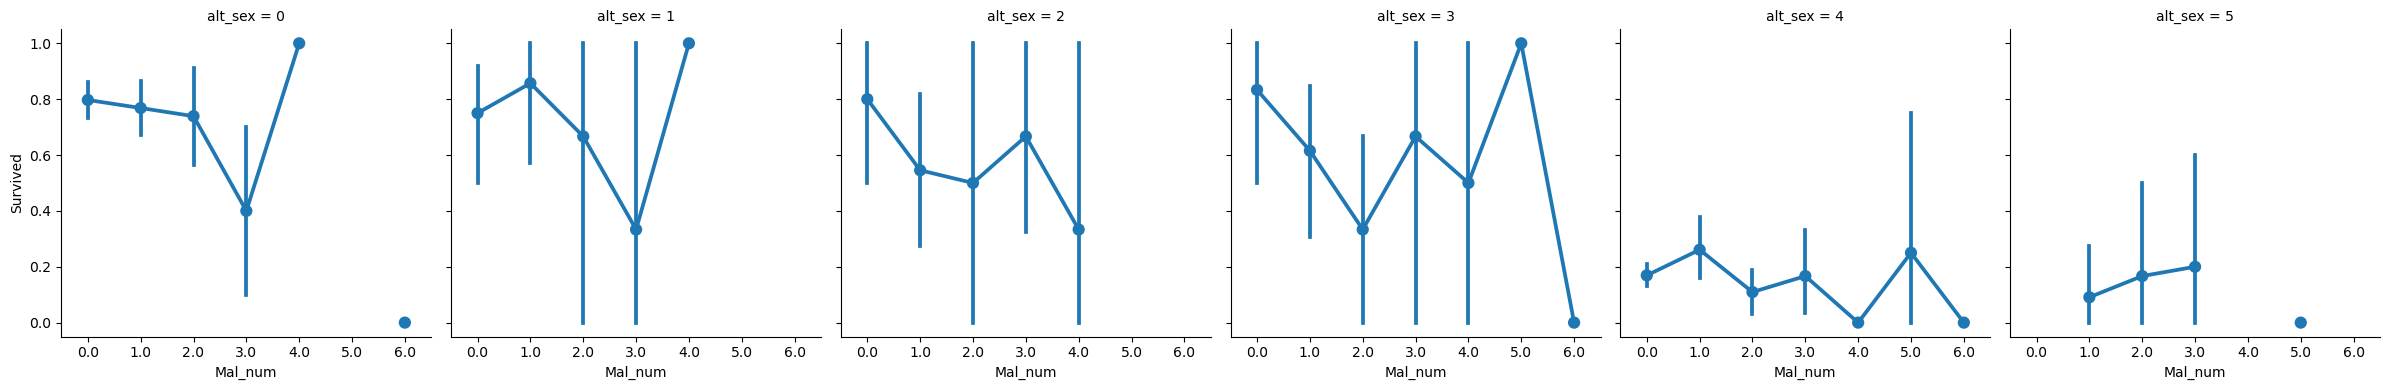

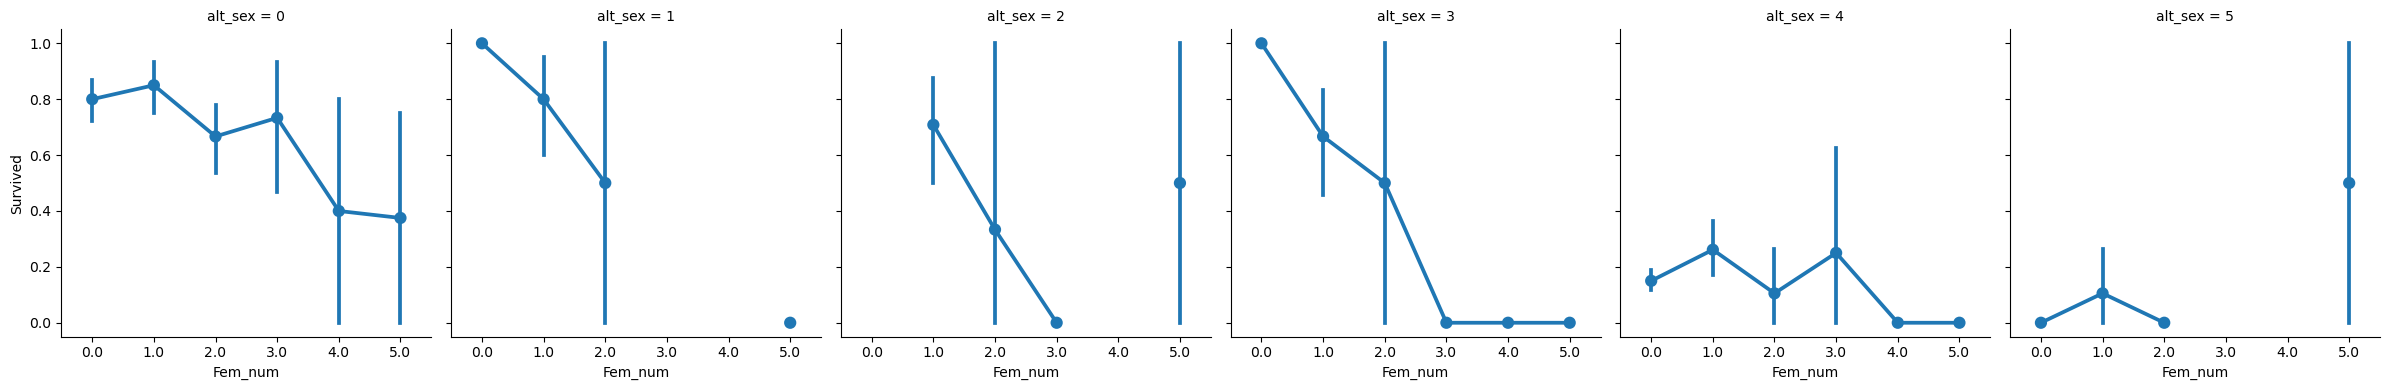

In [92]:
sns.catplot( dfv01 , x = 'Mal_num', y='Survived' , kind = 'point',height=4, col='alt_sex')
sns.catplot( dfv01 , x = 'Fem_num', y='Survived' , kind = 'point',height=4, col='alt_sex')

Fem_num, Mal_num: Above graphs shows high variance, unfixed

Selection between age and age group: the reason why I grouped age then ordinal encode by ordering groups according to graphically seen mean surivival rates was because in tree models due to its non linearity and certain splits would wield no gain where is if categorise similars I could ensure good again. whereas for SVM binning continious variables isn't advised, I am losing reasonable amount of information, so for trees I will use age groups, and for svm I will use age. 

Selection between Fare_log and binned fare, I already fixed skewness issue with log transforming fare. The reason why I binned fare is because I didn't want it to dominate over other features such that to capture relevant info from continous feature, I might need longer tunning and maybe deeper trees but this is hard to contrıl for overfitting, chi2 test says I captured good amount of linear relation in bins but looking at mutual info chart, seems like I missed alot of non-linear info. for trees I will use binned fare, and for svm I will use fare_log.

Selection between Sex and alt_sex: I will set both unfixed

#### Setting common training params & making a prediction with a base estimator

In [156]:
X_train_whole.columns

Index(['Pclass', 'Embarked', 'Deck', 'alt_sex', 'Fare_Log', 'Title',
       'groupsize', 'C_total', 'GS_Max', 'Fem_num', 'Mal_num', 'Age_group',
       'binned_Fare_Log', 'Sex', 'Age'],
      dtype='object')

In [157]:
feature_groups=['Pclass', 'Embarked', 'Deck', 'alt_sex', 'Fare_Log', 'Title','groupsize','C_total',
               'GS_Max', 'Fem_num','Mal_num','Age_group','binned_Fare_Log', 'Sex', 'Age']

In [158]:
Xt_train = Xt_train[feature_groups]
Xt_valid= Xt_valid[feature_groups]
Xt_test = Xt_test[feature_groups]
X_train_whole=X_train_whole[feature_groups]

In [159]:
tree_feature_s1=['Pclass', 'Embarked', 'Deck', 'alt_sex', 'Title','groupsize','C_total',
                'GS_Max', 'Fem_num','Mal_num','Age_group','binned_Fare_Log', 'Sex']
best_dt_features=tree_feature_s1
fixed_tree_features=['Pclass', 'Embarked', 'Deck', 'Title','groupsize',
                    'GS_Max', 'Age_group','binned_Fare_Log']

In [160]:
#Initializing feature sets to all 
svm_features_s1=['Pclass', 'Embarked', 'Deck', 'alt_sex','Title','groupsize',
                'GS_Max', 'Fem_num','Mal_num','Age', 'Fare_Log', 'Sex']
best_svc_features=svm_features_s1
fixed_svm_features=['Pclass', 'Embarked', 'Deck', 'Title','groupsize',
                    'GS_Max', 'Age','Fare_Log']

In [161]:
xgb_feature_s1=['Pclass', 'Embarked', 'Deck', 'alt_sex', 'Title','groupsize','C_total',
                'GS_Max', 'Fem_num','Mal_num','Age_group','binned_Fare_Log', 'Sex']
best_xgb_features=xgb_feature_s1

In [162]:
rfc_feature_s1=['Pclass', 'Embarked', 'Deck', 'alt_sex', 'Title','groupsize',
                'GS_Max', 'Fem_num','Mal_num','Age_group','binned_Fare_Log', 'Sex']
best_rfc_features=rfc_feature_s1

In [163]:
#checking n_unique of groups in features
for col in tree_feature_s1:
    print(X_train_whole[col].value_counts())

1.0    387
0.0    181
0.5    143
Name: Pclass, dtype: int64
1.0    510
0.0    139
0.5     62
Name: Embarked, dtype: int64
1.000000    541
0.571429     49
0.285714     40
0.142857     29
0.000000     27
0.857143     12
0.428571     10
0.714286      3
Name: Deck, dtype: int64
0.8    413
0.0    207
0.4     27
0.6     27
1.0     20
0.2     17
Name: alt_sex, dtype: int64
1.0    421
0.4    144
0.2    102
0.6     34
0.8      5
0.0      5
Name: Title, dtype: int64
0.0    426
0.1    130
0.2     79
0.3     23
0.5     19
0.6     12
0.4     11
0.7      6
1.0      5
Name: groupsize, dtype: int64
0.00    614
0.25     40
0.50     28
0.75     22
1.00      7
Name: C_total, dtype: int64
0.0    279
0.1    154
0.2    115
0.3     62
0.5     36
0.4     22
0.7     17
1.0     14
0.6     12
Name: GS_Max, dtype: int64
0.0    407
0.2    189
0.4     69
0.6     22
1.0     18
0.8      6
Name: Fem_num, dtype: int64
0.000000    399
0.166667    152
0.333333     88
0.500000     40
0.666667     21
0.833333      6
1.0000

There is mild class imbalance such survivors(1) less then death(0) in dataset at around 30% ratio. I am less interested in the skill of the model at predicting class 0 correctly. But since the imbalanced isn't extreme, I still need to care about negatives as well so I can't use F1 score as it don't care about negatives at all so I will choise balanced accuracy for evaluation. 

In [164]:
scoring='balanced_accuracy'

In [165]:
cv_folds=RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = 0 )

In [166]:
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train_whole[best_dt_features], y_train_whole.values.ravel())
y_pred_dt=model.predict(Xt_test[best_dt_features])
cv_results = cross_validate(model, X_train_whole[best_dt_features],
                                                    y_train_whole.values.ravel(), cv=cv_folds,scoring=scoring)
print(f"Mean cv test score for train data {cv_results['test_score'].mean()}")

Mean cv test score for train data 0.7787706522590244


Accuracy: 0.7520564042303173
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       111
           1       0.80      0.59      0.68        69

    accuracy                           0.79       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.79      0.78       180

Confusion Matrix


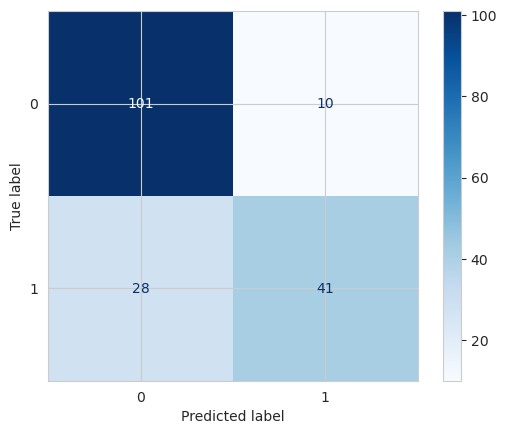

In [167]:
# Print performance details
accuracy = balanced_accuracy_score(y_test, y_pred_dt) 
print("Accuracy: " +  str(accuracy))
print(classification_report(y_test, y_pred_dt))

# Print confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap = 'Blues')
None

Text(0.5, 0, 'Relative Importance')

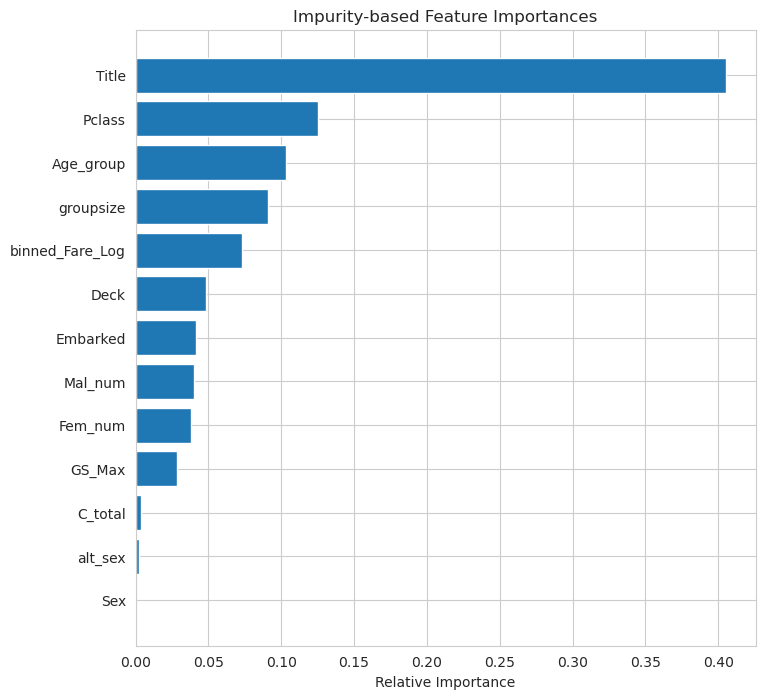

In [168]:
features=X_train_whole[best_dt_features].columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(1,figsize=(8,8))
plt.title('Impurity-based Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [169]:
print('Feature importance based on feature permutation:')
r_dt = permutation_importance(model, X_train_whole[best_dt_features], y_train_whole.values.ravel(),
                           n_repeats=30,
                           random_state=0)

for i in r_dt.importances_mean.argsort()[::-1]:
    print(f"""{X_train_whole[best_dt_features].columns[i]:<25}: {r_dt.importances_mean[i]:.3f} ,\
    +/- {r_dt.importances_std[i]:.3f}""")
None

Feature importance based on feature permutation:
Title                    : 0.268 ,    +/- 0.014
binned_Fare_Log          : 0.098 ,    +/- 0.008
Pclass                   : 0.094 ,    +/- 0.008
Deck                     : 0.079 ,    +/- 0.008
Age_group                : 0.078 ,    +/- 0.008
groupsize                : 0.078 ,    +/- 0.006
GS_Max                   : 0.057 ,    +/- 0.007
Embarked                 : 0.045 ,    +/- 0.005
Fem_num                  : 0.041 ,    +/- 0.004
Mal_num                  : 0.036 ,    +/- 0.005
C_total                  : 0.007 ,    +/- 0.003
alt_sex                  : 0.007 ,    +/- 0.002
Sex                      : 0.000 ,    +/- 0.000


# Modelling

## Testing different ensemble models

In [170]:
metrics_to_check = {"BAccuracy": "balanced_accuracy", "F1": "f1","Recall":"recall"}

In [171]:
# Initializing dictionary to store model performance parameters for comparison
model_test_accuracy_comparisons = dict()

In [172]:
# Initializing dataframe to store feature importances across different models
ImportantFeatures=pd.DataFrame(data=None, columns=['Model']+list(X_train_whole.columns))

In [173]:
#efs with gridsearch is highly time consuming so reducing cv folds and removing repeat
cv_folds_efs=StratifiedKFold(n_splits=5, shuffle=True, random_state = 0 )

In [174]:
def print_cv(cv_result):
    print(f"""\
     Balanced_Accuracy: {cv_result['test_BAccuracy'].mean():.5f}, \
    std: {cv_result['test_BAccuracy'].std():.5f} \n \
    F1               : {cv_result['test_F1'].mean():.5f}, \
    std: {cv_result['test_F1'].std():.5f} \n \
    Recall           : {cv_result['test_Recall'].mean():.5f}, \
    std: {cv_result['test_Recall'].std():.5f} """)

In [175]:
def print_gridsearchcv(gscv_result):
    print("\Best parameters set found on development set:")
    print(gscv_result.best_params_)
    print(f"""\
     Balanced_Accuracy: {gscv_result.best_score_:.5f}, \
    std: {gscv_result.cv_results_['std_test_BAccuracy'][gscv_result.best_index_]:.5f} \n \
    F1               : {gscv_result.cv_results_['mean_test_F1'][gscv_result.best_index_]:.5f}, \
    std: {gscv_result.cv_results_['std_test_F1'][gscv_result.best_index_]:.5f} \n \
    Recall           : {gscv_result.cv_results_['mean_test_Recall'][gscv_result.best_index_]:.5f}, \
    std: {gscv_result.cv_results_['std_test_Recall'][gscv_result.best_index_]:.5f} """)

# Random Forest Classifier

Aspects & trade-offs to watchout when tunning: More trees you have = the less variance. Decreasing any of the max* parameters and increasing any of the min* parameters will increase regularization; such that,max depth & features increase variance and decrease bias, min samples leaf & split decrease variance and increase bias.

In [176]:
my_rfc_pipe = make_pipeline(ColumnSelector(cols=best_rfc_features),
                      RandomForestClassifier(random_state=0,verbose = 0))

my_rfc_pipe.fit(X_train_whole, y_train_whole.values.ravel())
my_rfc_cv_results = cross_validate(my_rfc_pipe, X_train_whole, y_train_whole.values.ravel(), 
                                    cv=cv_folds, scoring=metrics_to_check,n_jobs = -1)
print_cv(my_rfc_cv_results)

     Balanced_Accuracy: 0.81257,     std: 0.04171 
     F1               : 0.76860,     std: 0.05379 
     Recall           : 0.73566,     std: 0.07005 


0.7765374069721895

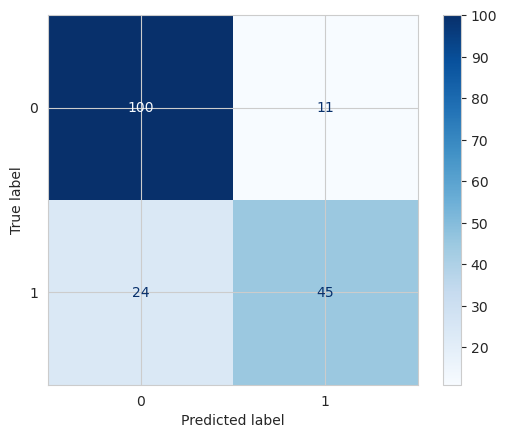

In [177]:
y_test_rfr=my_rfc_pipe.predict(Xt_test)
display(balanced_accuracy_score(y_test, y_test_rfr))
ConfusionMatrixDisplay.from_predictions(y_test,y_test_rfr, cmap = 'Blues')

In [178]:
param_grid_RFC_V0 = {
    'randomforestclassifier__n_estimators': [x for x in range(100,2501,100)],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_features':  ['log2','sqrt'],
    'randomforestclassifier__oob_score':[False],
    'randomforestclassifier__max_depth':[4,5,6], 
    'randomforestclassifier__random_state':[0]
    }

rfc_pipe = make_pipeline(ColumnSelector(cols=best_rfc_features),
                      RandomForestClassifier(verbose = 0))
# Perform the search
my_tuned_rfcv0 = GridSearchCV(rfc_pipe, param_grid=param_grid_RFC_V0, 
                              cv=StratifiedKFold(n_splits=10, shuffle=True, random_state = 0 ),
                              verbose = 0, n_jobs = -1, scoring=metrics_to_check, refit="BAccuracy")
my_tuned_rfcv0.fit(X_train_whole, y_train_whole.values.ravel())
print_gridsearchcv(my_tuned_rfcv0)

\Best parameters set found on development set:
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__oob_score': False, 'randomforestclassifier__random_state': 0}
     Balanced_Accuracy: 0.82228,     std: 0.02292 
     F1               : 0.78107,     std: 0.02803 
     Recall           : 0.74735,     std: 0.05992 


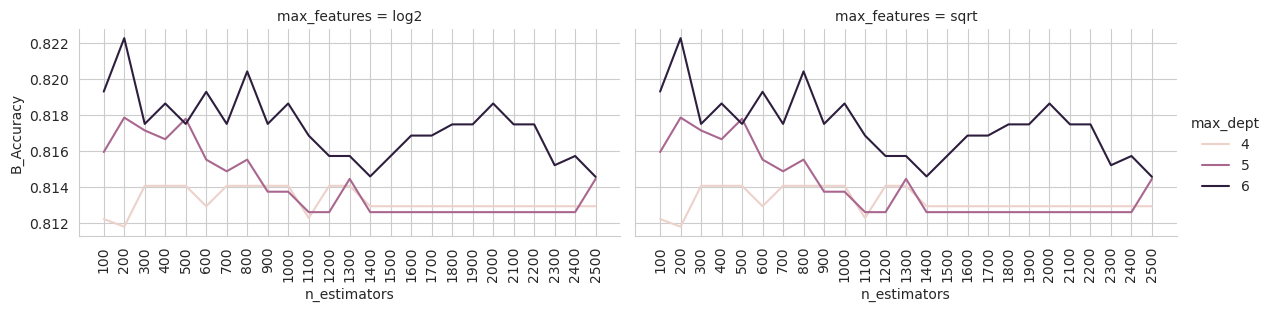

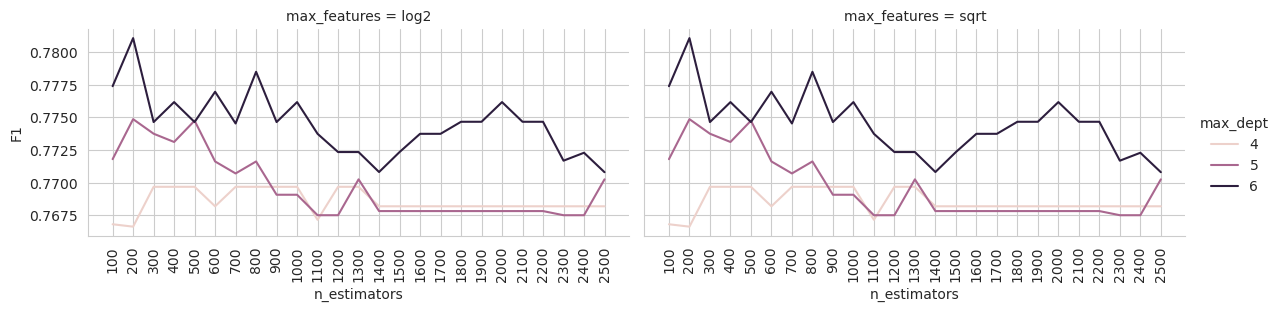

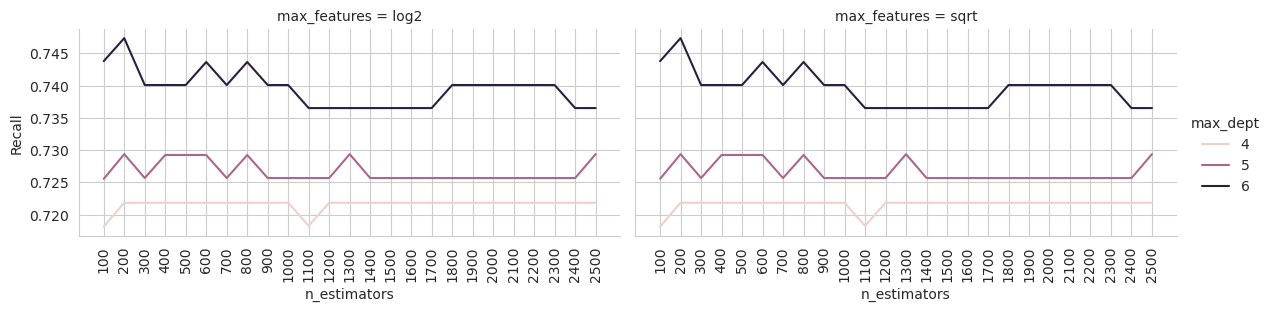

In [179]:
df_grid_results=pd.DataFrame({'n_estimators':np.array(my_tuned_rfcv0.cv_results_['param_randomforestclassifier__n_estimators']),
                             'max_dept':np.array(my_tuned_rfcv0.cv_results_['param_randomforestclassifier__max_depth']),
                             'max_features':np.array(my_tuned_rfcv0.cv_results_['param_randomforestclassifier__max_features']),
                             'B_Accuracy':np.array(my_tuned_rfcv0.cv_results_['mean_test_BAccuracy']),
                             'F1':np.array(my_tuned_rfcv0.cv_results_['mean_test_F1']),
                             'Recall':np.array(my_tuned_rfcv0.cv_results_['mean_test_Recall'])})
sns.set_style("whitegrid")

sns.relplot(data=df_grid_results, x='n_estimators', y='B_Accuracy', kind="line", height=3, aspect=2,
hue= 'max_dept',col='max_features', ).set(xticks=[x for x in range(100,2501,100)]).set_xticklabels(rotation=90)
sns.relplot(data=df_grid_results, x='n_estimators', y='F1', kind="line",height=3, aspect=2,
hue= 'max_dept',col='max_features').set(xticks=[x for x in range(100,2501,100)]).set_xticklabels(rotation=90)
sns.relplot(data=df_grid_results, x='n_estimators', y='Recall', kind="line",height=3, aspect=2,
hue= 'max_dept',col='max_features').set(xticks=[x for x in range(100,2501,100)]).set_xticklabels(rotation=90)
plt.show()

In [182]:
t1 = time.time()

In [183]:
rfc=RandomForestClassifier(verbose = 0,random_state = 0 )

efs_forward_rfc = EFS(estimator=rfc, 
                  min_features=len(best_rfc_features)-3,
                  max_features=len(best_rfc_features),
                  fixed_features=fixed_tree_features,
                  print_progress=False,
                  clone_estimator=False,
                  scoring=scoring,
                  cv=cv_folds_efs, 
                  n_jobs = -1)

rfc_efs_pipe=make_pipeline(efs_forward_rfc,rfc)

param_grid_RFC = {
    'exhaustivefeatureselector__estimator__n_estimators':[800],
    'exhaustivefeatureselector__estimator__criterion': ['gini'],
    'exhaustivefeatureselector__estimator__max_features': ['sqrt'],
    'exhaustivefeatureselector__estimator__oob_score':[False],
    'exhaustivefeatureselector__estimator__max_depth': [5,6], 
    'exhaustivefeatureselector__estimator__random_state':[0]
    }

my_tuned_rfc = GridSearchCV(estimator=rfc_efs_pipe, param_grid=param_grid_RFC, refit=True,
                                cv=cv_folds_efs, verbose = 0, n_jobs = -1, scoring=scoring)
my_tuned_rfc.fit(X_train_whole[best_rfc_features], y_train_whole.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('exhaustivefeatureselector',
                                        ExhaustiveFeatureSelector(clone_estimator=False,
                                                                  cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                                                                  estimator=RandomForestClassifier(random_state=0),
                                                                  fixed_features=['Pclass',
                                                                                  'Embarked',
                                                                                  'Deck',
                                                                                  'Title',
                                                                                  'groupsize',
                                                                                  'GS_...
             param_grid={'exhaustivefeatureselector__estimator__criterion': ['gini'],
                         'exhaustivefeatureselector__estimator__max_depth': [5,
                                                                             6],
                         'exhaustivefeatureselector__estimator__max_features': ['sqrt'],
                         'exhaustivefeatureselector__estimator__n_estimators': [800],
                         'exhaustivefeatureselector__estimator__oob_score': [False],
                         'exhaustivefeatureselector__estimator__random_state': [0]},
             scoring='balanced_accuracy')

In [184]:
print("Time:", int(time.time()-t1))

Time: 238


In [185]:
print('Best features:', my_tuned_rfc.best_estimator_.steps[0][1].best_feature_names_)

Best features: ('Pclass', 'Embarked', 'Deck', 'alt_sex', 'Title', 'groupsize', 'GS_Max', 'Fem_num', 'Age_group', 'binned_Fare_Log')


In [186]:
print(my_tuned_rfc.best_params_)
print(f"Score:{my_tuned_rfc.best_score_}, std:{my_tuned_rfc.cv_results_['std_test_score'][my_tuned_rfc.best_index_]}")

{'exhaustivefeatureselector__estimator__criterion': 'gini', 'exhaustivefeatureselector__estimator__max_depth': 6, 'exhaustivefeatureselector__estimator__max_features': 'sqrt', 'exhaustivefeatureselector__estimator__n_estimators': 800, 'exhaustivefeatureselector__estimator__oob_score': False, 'exhaustivefeatureselector__estimator__random_state': 0}
Score:0.806027516544758, std:0.021922384161921802


In [187]:
best_rfc_features=list(my_tuned_rfc.best_estimator_.steps[0][1].best_feature_names_)
print('Best subset (corresponding names):', best_rfc_features, 
      'number of selected features are ', len(best_rfc_features),' out of ', len(X_train_whole.columns))
print(f"Features not selected are:{[x for x in feature_groups if x not in best_rfc_features]}")
None

Best subset (corresponding names): ['Pclass', 'Embarked', 'Deck', 'alt_sex', 'Title', 'groupsize', 'GS_Max', 'Fem_num', 'Age_group', 'binned_Fare_Log'] number of selected features are  10  out of  15
Features not selected are:['Fare_Log', 'C_total', 'Mal_num', 'Sex', 'Age']


In [190]:
my_rfc_pipe_v1 = make_pipeline(ColumnSelector(cols=best_rfc_features),
                      RandomForestClassifier(   verbose = 0,
                                                criterion= 'gini',
                                                max_depth= 6,
                                                max_features='sqrt',
                                                random_state = 0 ,
                                                n_estimators= 800,
                                                oob_score=False))

my_tuned_rfc_v1_cv = cross_validate(my_rfc_pipe_v1, X_train_whole, y_train_whole.values.ravel(), 
                                            cv=cv_folds, scoring=metrics_to_check, n_jobs = -1)
print_cv(my_tuned_rfc_v1_cv)

     Balanced_Accuracy: 0.82033,     std: 0.03863 
     F1               : 0.77773,     std: 0.05074 
     Recall           : 0.73929,     std: 0.08077 


In [191]:
param_grid_RFC1 = {
    'randomforestclassifier__n_estimators':  [800],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_features': ['sqrt'],
    'randomforestclassifier__oob_score':[False],
    'randomforestclassifier__max_depth': [6],  
    'randomforestclassifier__min_samples_split': [x for x in range(1,30,1)], 
    'randomforestclassifier__random_state':[0]
    }

rfc_pipe = make_pipeline(ColumnSelector(cols=best_rfc_features),
                      RandomForestClassifier(verbose = 0))
# Perform the search
my_tuned_rfcv2 = GridSearchCV(rfc_pipe, param_grid=param_grid_RFC1, cv=cv_folds, verbose = 0,
                              n_jobs = -1, scoring=metrics_to_check, refit="BAccuracy")
my_tuned_rfcv2.fit(X_train_whole, y_train_whole.values.ravel())
print_gridsearchcv(my_tuned_rfcv2)

\Best parameters set found on development set:
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 800, 'randomforestclassifier__oob_score': False, 'randomforestclassifier__random_state': 0}
     Balanced_Accuracy: 0.82033,     std: 0.03863 
     F1               : 0.77773,     std: 0.05074 
     Recall           : 0.73929,     std: 0.08077 


<Figure size 640x480 with 0 Axes>

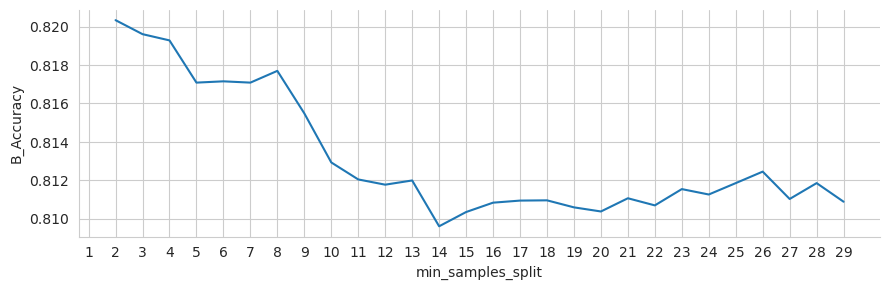

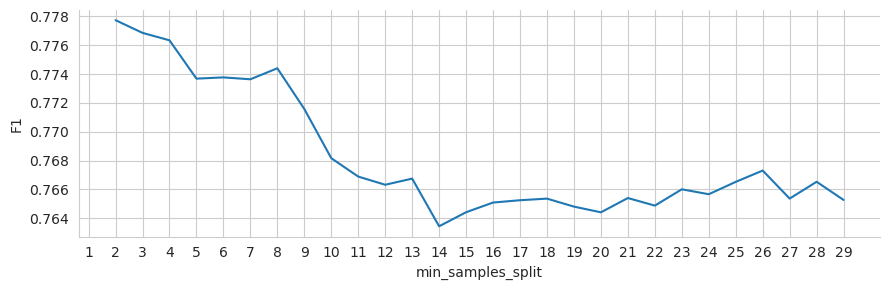

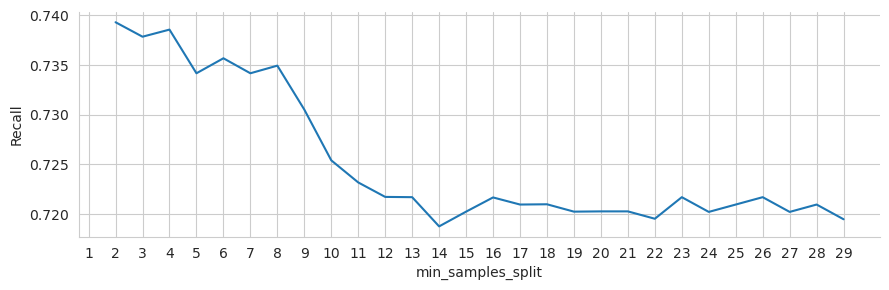

In [192]:
df_grid_results=pd.DataFrame({'min_samples_split':np.array(my_tuned_rfcv2.cv_results_['param_randomforestclassifier__min_samples_split']),
                             'B_Accuracy':np.array(my_tuned_rfcv2.cv_results_['mean_test_BAccuracy']),
                             'F1':np.array(my_tuned_rfcv2.cv_results_['mean_test_F1']),
                             'Recall':np.array(my_tuned_rfcv2.cv_results_['mean_test_Recall'])})
plt.figure()
sns.relplot(data=df_grid_results, x='min_samples_split', y='B_Accuracy', 
            kind="line", height=3, aspect=3).set(xticks=[x for x in range(1,30,1)])
sns.relplot(data=df_grid_results, x='min_samples_split', y='F1', 
            kind="line",height=3, aspect=3).set(xticks=[x for x in range(1,30,1)])
sns.relplot(data=df_grid_results, x='min_samples_split', y='Recall', 
            kind="line",height=3, aspect=3).set(xticks=[x for x in range(1,30,1)])
plt.show()

In [193]:
param_grid_RFC1 = {
    'randomforestclassifier__n_estimators':  [800],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_features': ['sqrt'],
    'randomforestclassifier__oob_score':[False],
    'randomforestclassifier__max_depth': [6], 
    'randomforestclassifier__min_samples_leaf': [x for x in range(1,30,1)], 
    'randomforestclassifier__min_samples_split': [8], 
    'randomforestclassifier__random_state':[0]
    }

rfc_pipe = make_pipeline(ColumnSelector(cols=best_rfc_features),
                      RandomForestClassifier(verbose = 0))
# Perform the search
my_tuned_rfcv2 = GridSearchCV(rfc_pipe, param_grid=param_grid_RFC1, cv=cv_folds, verbose = 0,
                              n_jobs = -1, scoring=metrics_to_check, refit="BAccuracy")
my_tuned_rfcv2.fit(X_train_whole, y_train_whole.values.ravel())
print_gridsearchcv(my_tuned_rfcv2)

\Best parameters set found on development set:
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 800, 'randomforestclassifier__oob_score': False, 'randomforestclassifier__random_state': 0}
     Balanced_Accuracy: 0.81769,     std: 0.03753 
     F1               : 0.77439,     std: 0.04945 
     Recall           : 0.73492,     std: 0.07787 


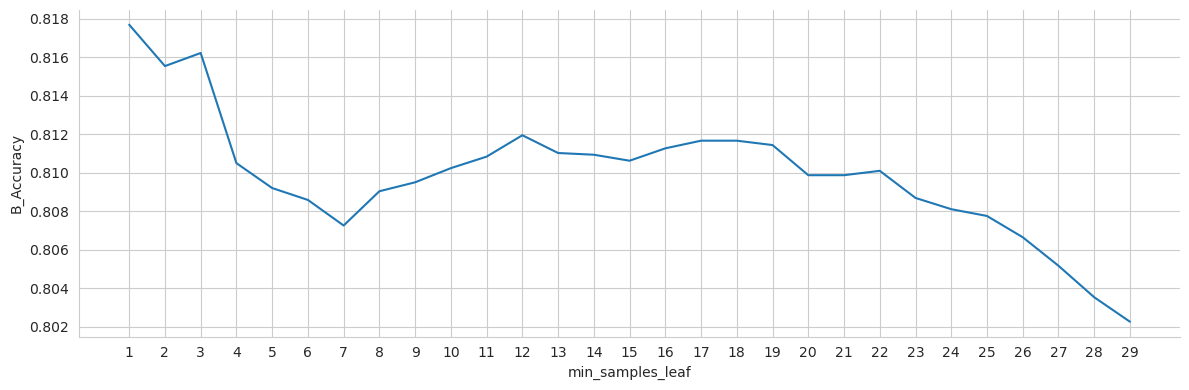

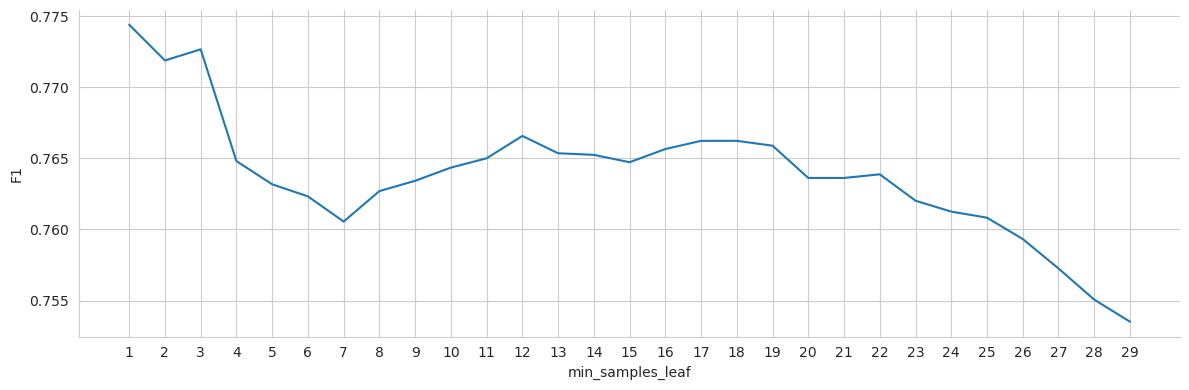

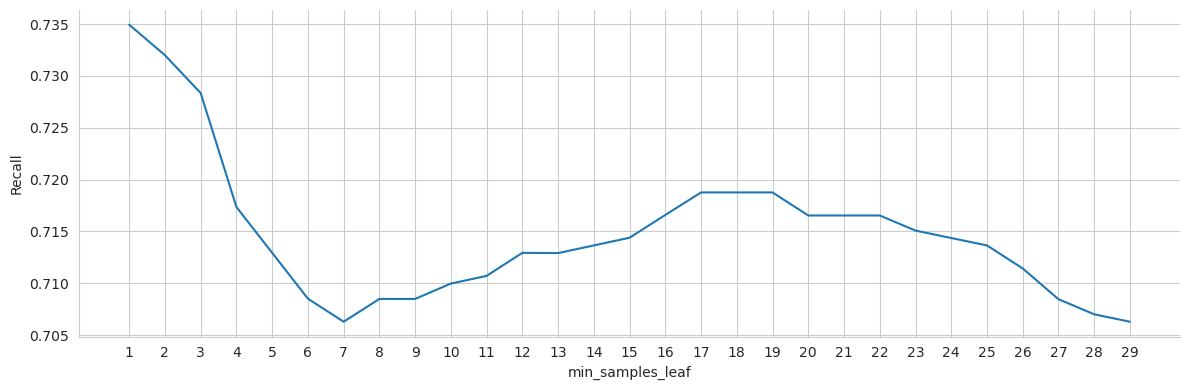

In [194]:
df_grid_results=pd.DataFrame({'min_samples_leaf':np.array(my_tuned_rfcv2.cv_results_['param_randomforestclassifier__min_samples_leaf']),
                             'B_Accuracy':np.array(my_tuned_rfcv2.cv_results_['mean_test_BAccuracy']),
                             'F1':np.array(my_tuned_rfcv2.cv_results_['mean_test_F1']),
                             'Recall':np.array(my_tuned_rfcv2.cv_results_['mean_test_Recall'])})

sns.relplot(data=df_grid_results, x='min_samples_leaf', y='B_Accuracy', kind="line", 
            height=4, aspect=3  ).set(xticks=[x for x in range(1,30,1)])
sns.relplot(data=df_grid_results, x='min_samples_leaf', y='F1', kind="line",
            height=4,  aspect=3 ).set(xticks=[x for x in range(1,30,1)])
sns.relplot(data=df_grid_results, x='min_samples_leaf', y='Recall', kind="line",
            height=4, aspect=3  ).set(xticks=[x for x in range(1,30,1)])
plt.show()

In [196]:
param_grid_RFC1 = {
    'randomforestclassifier__n_estimators':  [x for x in range(100,2501,100)],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_features': ['sqrt'],
    'randomforestclassifier__oob_score':[False],
    'randomforestclassifier__max_depth': [6], 
    'randomforestclassifier__min_samples_leaf': [17], 
    'randomforestclassifier__min_samples_split': [8], 
    'randomforestclassifier__random_state':[0]
    }

rfc_pipe = make_pipeline(ColumnSelector(cols=best_rfc_features),
                      RandomForestClassifier(verbose = 0))
# Perform the search
my_tuned_rfcv2 = GridSearchCV(rfc_pipe, param_grid=param_grid_RFC1, cv=cv_folds, verbose = 0,
                              n_jobs = -1, scoring=metrics_to_check, refit="BAccuracy")
my_tuned_rfcv2.fit(X_train_whole, y_train_whole.values.ravel())
print_gridsearchcv(my_tuned_rfcv2)

\Best parameters set found on development set:
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 17, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__oob_score': False, 'randomforestclassifier__random_state': 0}
     Balanced_Accuracy: 0.81217,     std: 0.04543 
     F1               : 0.76696,     std: 0.05994 
     Recall           : 0.72021,     std: 0.08405 


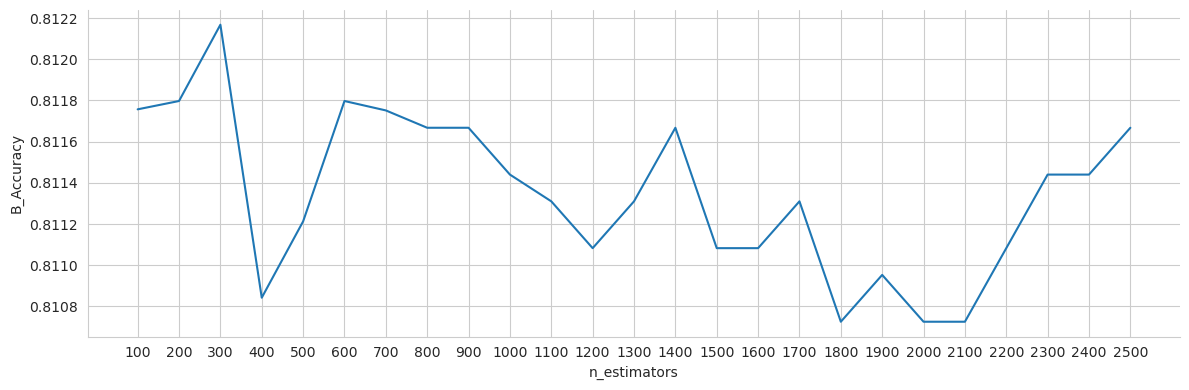

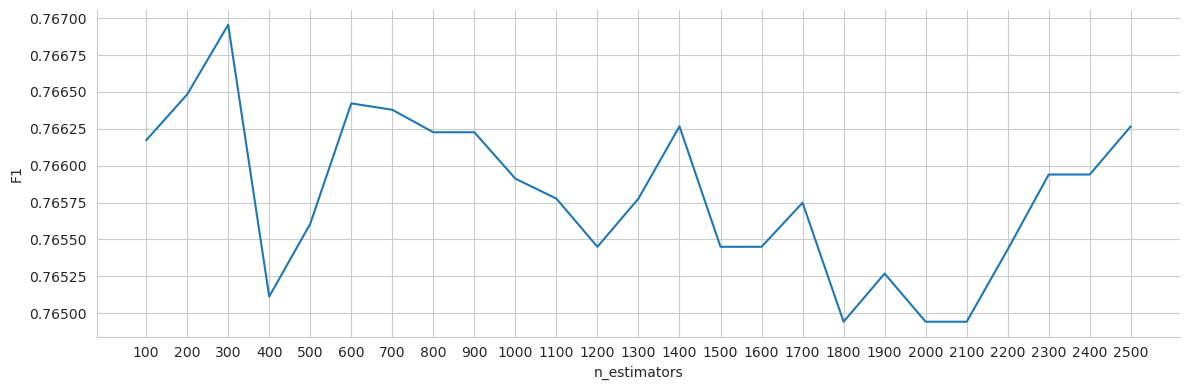

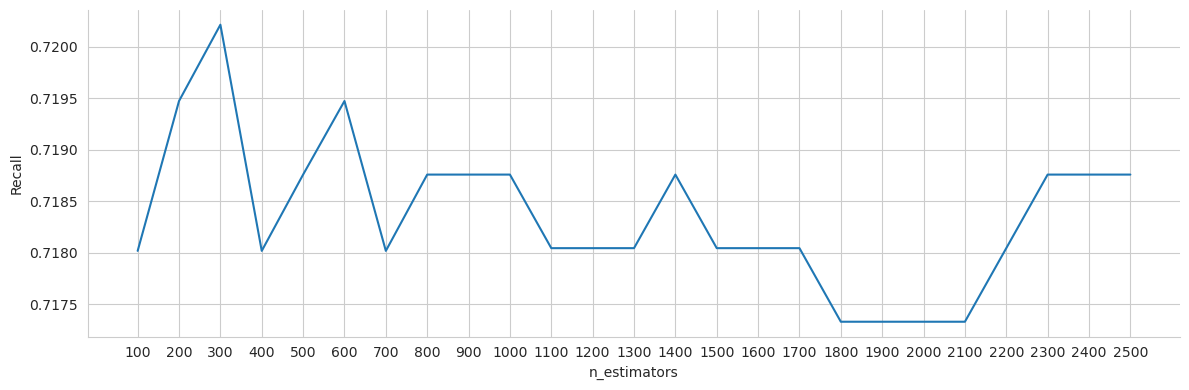

In [197]:
df_grid_results=pd.DataFrame({'n_estimators':np.array(my_tuned_rfcv2.cv_results_['param_randomforestclassifier__n_estimators']),
                             'B_Accuracy':np.array(my_tuned_rfcv2.cv_results_['mean_test_BAccuracy']),
                             'F1':np.array(my_tuned_rfcv2.cv_results_['mean_test_F1']),
                             'Recall':np.array(my_tuned_rfcv2.cv_results_['mean_test_Recall'])})

sns.relplot(data=df_grid_results, x='n_estimators', y='B_Accuracy', kind="line", 
            height=4, aspect=3  ).set(xticks=[x for x in range(100,2501,100)])
sns.relplot(data=df_grid_results, x='n_estimators', y='F1', kind="line",
            height=4,  aspect=3 ).set(xticks=[x for x in range(100,2501,100)])
sns.relplot(data=df_grid_results, x='n_estimators', y='Recall', kind="line",
            height=4, aspect=3  ).set(xticks=[x for x in range(100,2501,100)])
plt.show()

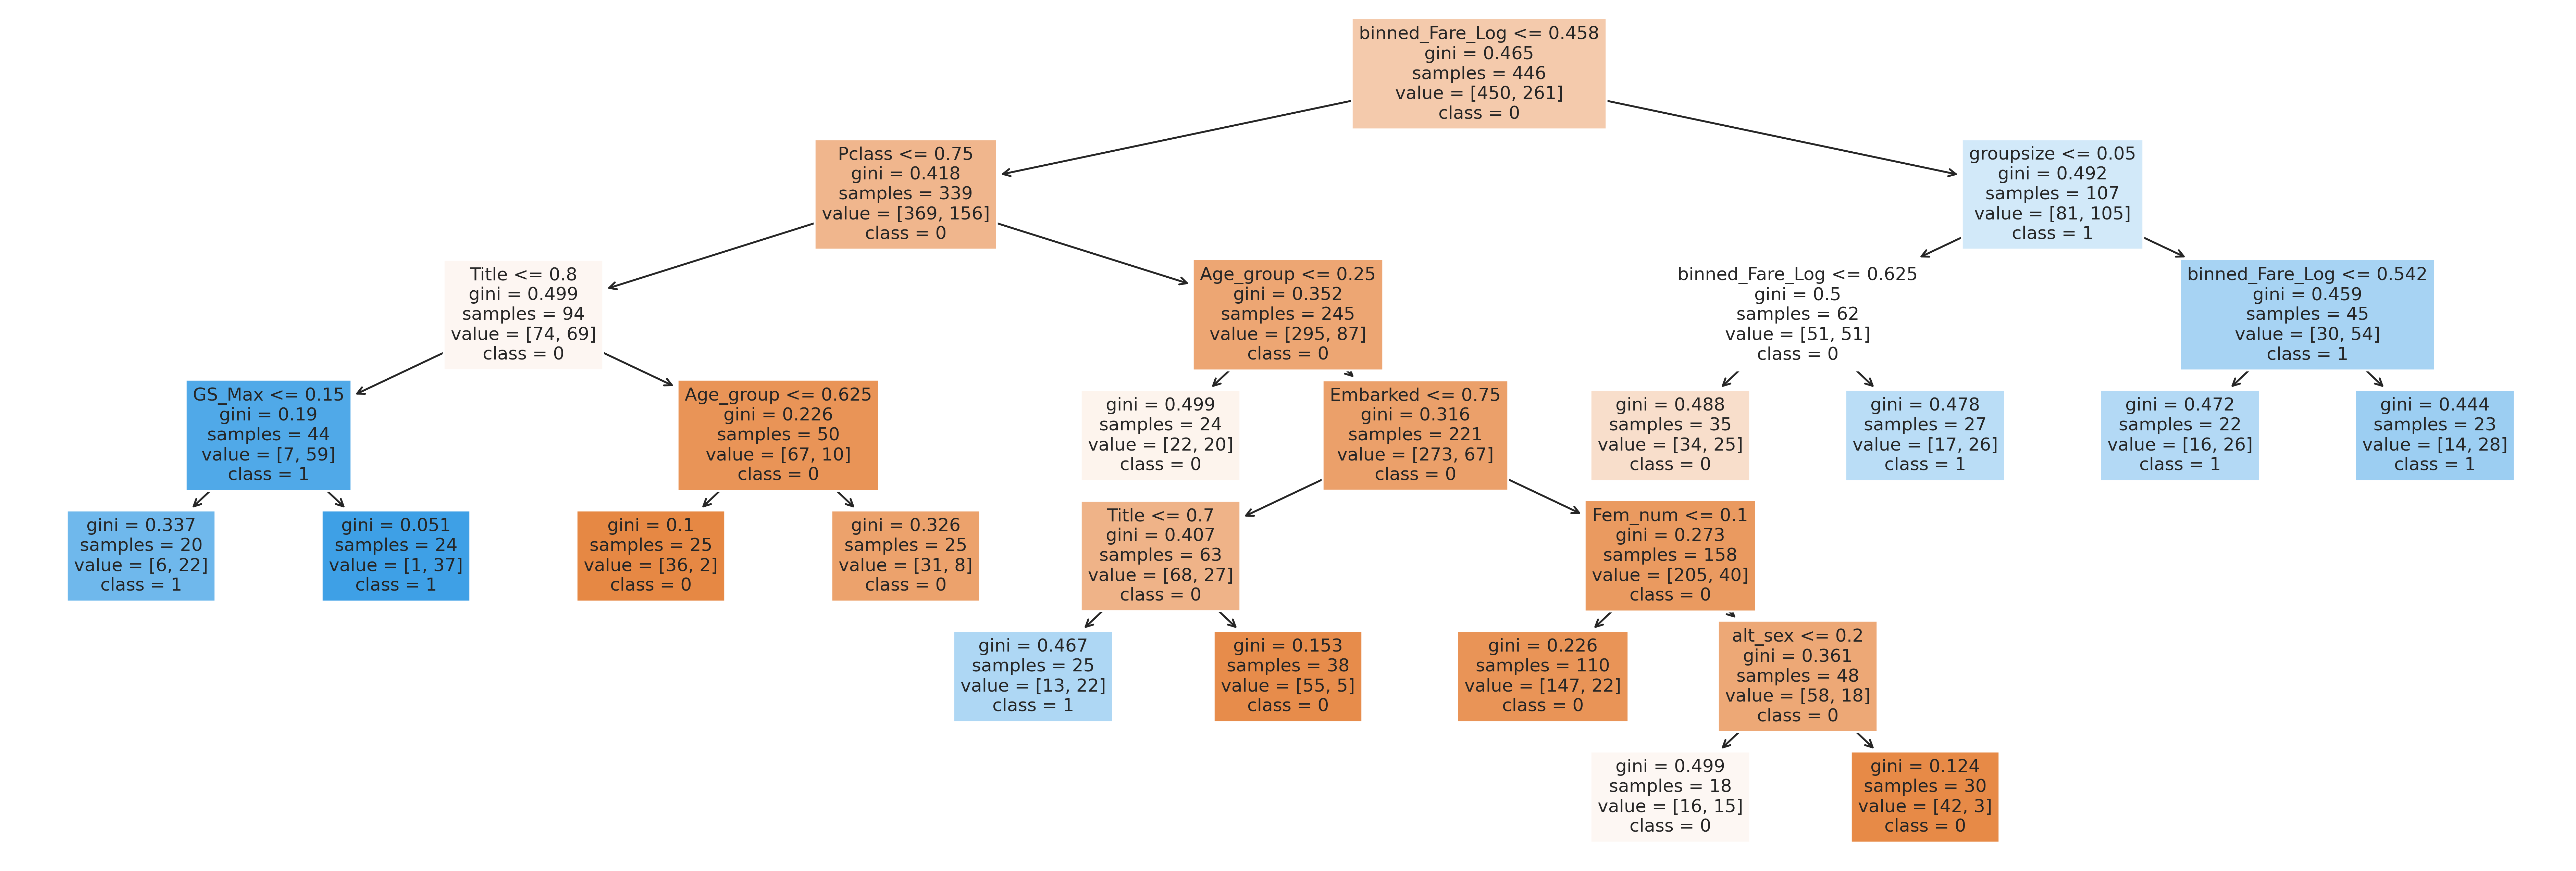

In [198]:
fig = plt.figure(figsize=(24,8), dpi=400)
_ = tree.plot_tree(my_tuned_rfcv2.best_estimator_.named_steps["randomforestclassifier"][1], 
                   feature_names=best_rfc_features,  
                   class_names=['0','1'],
                   filled=True)
fig.savefig('rf_individualtree.png')

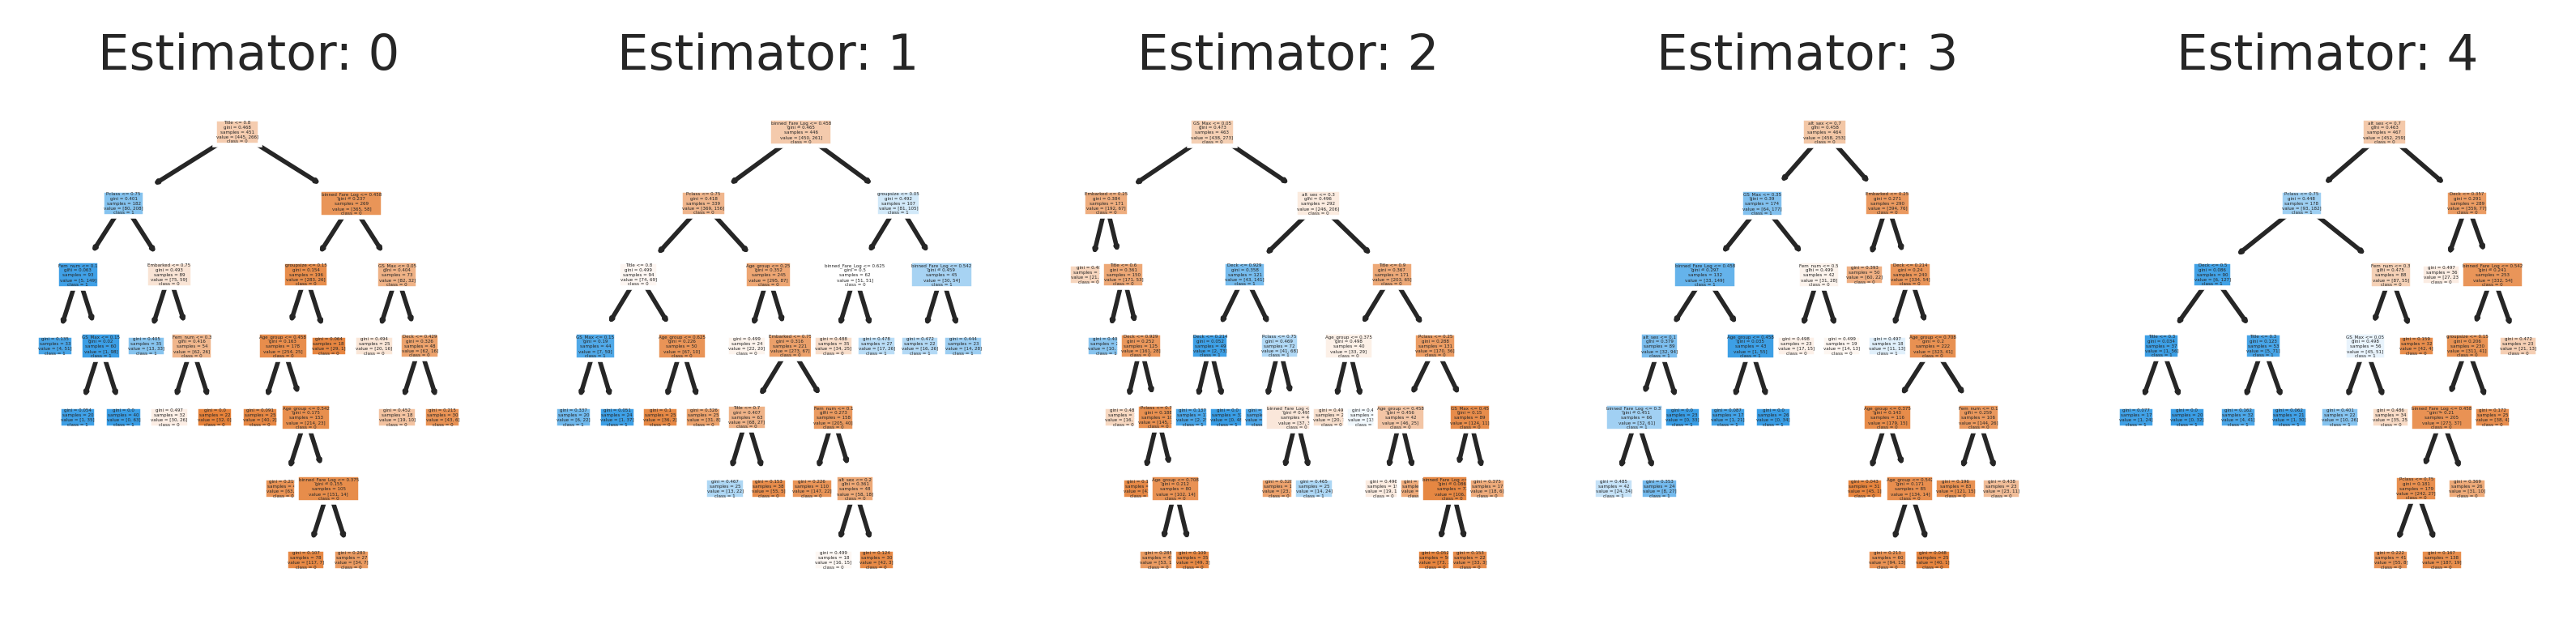

In [199]:
fn=best_rfc_features
cn=['0','1']
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=400)
for index in range(0, 5):
    tree.plot_tree(my_tuned_rfcv2.best_estimator_.named_steps["randomforestclassifier"][index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

Text(0.5, 0, 'Relative Importance')

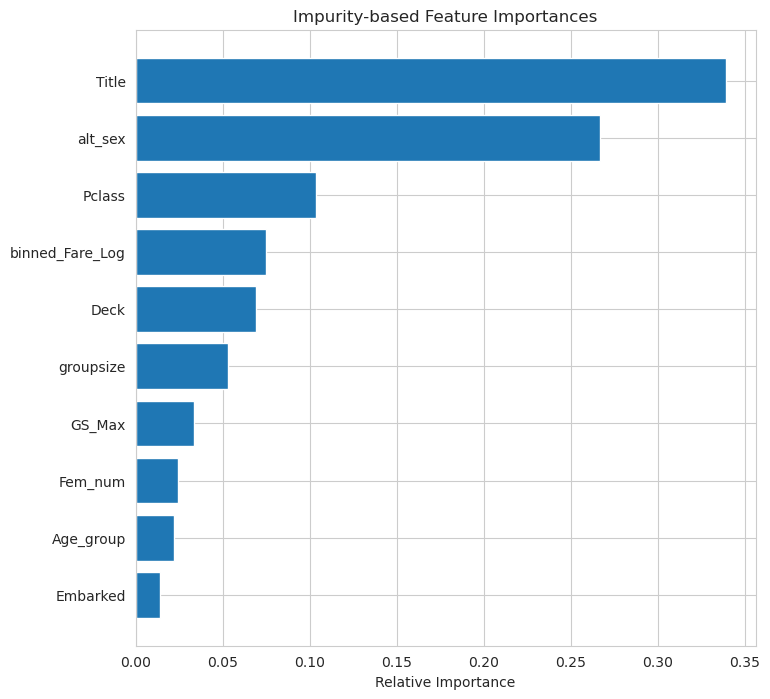

In [200]:
features=np.array(best_rfc_features)
importances = my_tuned_rfcv2.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
indices = np.argsort(importances)

plt.figure(1,figsize=(8,8))
plt.title('Impurity-based Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [201]:
print('Feature importance based on feature permutation:')
r_rfc = permutation_importance(my_tuned_rfcv2, X_train_whole[best_rfc_features], y_train_whole.values.ravel(),
                           n_repeats=30,
                           random_state=0)
rfc_features={}
rfc_features['Model']='rfc'
for i in r_rfc.importances_mean.argsort()[::-1]:
    if r_rfc.importances_mean[i]>0.0009:
        print(f"{X_train_whole[best_rfc_features].columns[i]:<25}: {r_rfc.importances_mean[i]:.3f} , +/- {r_rfc.importances_std[i]:.3f}")
        rfc_features[X_train_whole[best_rfc_features].columns[i]]=r_rfc.importances_mean[i]
ImportantFeatures=ImportantFeatures.append(rfc_features,ignore_index=True, sort=False)
None

Feature importance based on feature permutation:
Title                    : 0.116 , +/- 0.009
alt_sex                  : 0.053 , +/- 0.009
Pclass                   : 0.018 , +/- 0.004
groupsize                : 0.014 , +/- 0.005
Fem_num                  : 0.010 , +/- 0.002
binned_Fare_Log          : 0.006 , +/- 0.002
Age_group                : 0.005 , +/- 0.002
Deck                     : 0.004 , +/- 0.002
Embarked                 : 0.003 , +/- 0.003
GS_Max                   : 0.002 , +/- 0.002


Accuracy: 0.8055229142185665
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       111
           1       0.82      0.71      0.76        69

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

Confusion Matrix


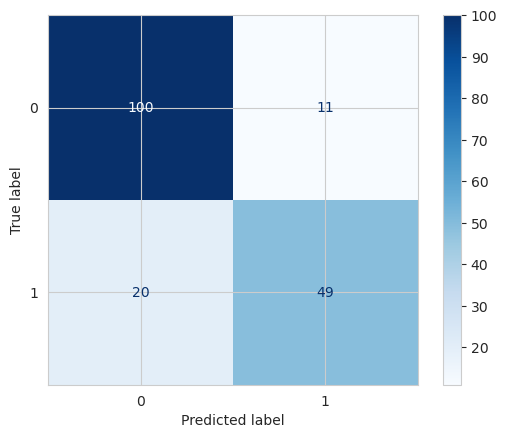

In [202]:
# Make a set of predictions for the testation data
y_pred_rfc = my_tuned_rfcv2.predict(Xt_test)

# Print performance details
accuracy = balanced_accuracy_score(y_test, y_pred_rfc) 
model_test_accuracy_comparisons["tuned_rfc"] = accuracy
print("Accuracy: " +  str(accuracy))
print(classification_report(y_test, y_pred_rfc))

# Print confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfc, cmap = 'Blues')
None

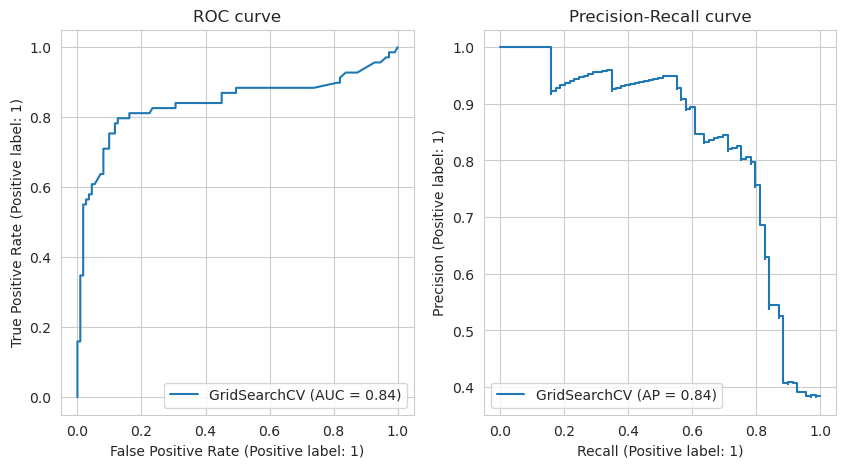

In [203]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

roc_display_rfc = RocCurveDisplay.from_estimator(my_tuned_rfcv2, Xt_test, y_test,ax=ax1)
pr_display_rfc = PrecisionRecallDisplay.from_estimator(my_tuned_rfcv2, Xt_test, y_test,ax=ax2)
roc_display_rfc.ax_.set_title("ROC curve")
pr_display_rfc.ax_.set_title("Precision-Recall curve")

plt.show()

# Support Vector classifier

In [204]:
my_svc_pipe = make_pipeline(ColumnSelector(cols=best_svc_features),
                          SVC(probability=True,verbose = 0, random_state=0))


my_svc_pipe.fit(X_train_whole, y_train_whole.values.ravel())

svc_cv_results = cross_validate(my_rfc_pipe, X_train_whole, y_train_whole.values.ravel(), 
                                    cv=cv_folds, scoring=metrics_to_check,n_jobs = -1)
print_cv(svc_cv_results)

     Balanced_Accuracy: 0.81257,     std: 0.04171 
     F1               : 0.76860,     std: 0.05379 
     Recall           : 0.73566,     std: 0.07005 


0.7900509204857031

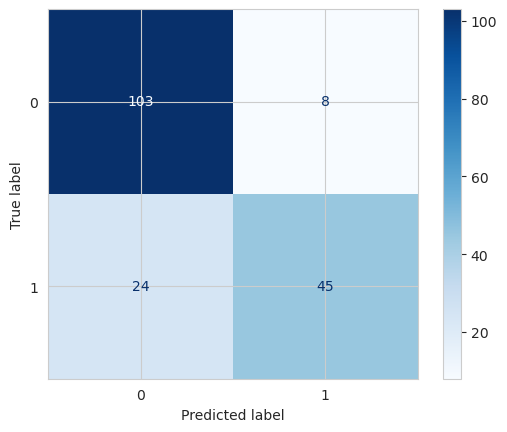

In [205]:
y_test_svc=my_svc_pipe.predict(Xt_test)
display(balanced_accuracy_score(y_test, y_test_svc))
ConfusionMatrixDisplay.from_predictions(y_test,y_test_svc, cmap = 'Blues')

In [206]:
t1 = time.time()

In [207]:
svc=SVC(probability=True,verbose = 0,random_state = 0 )

efs_forward_svc = EFS(estimator=svc,
                  min_features=len(best_svc_features)-3,
                  max_features=len(best_svc_features),
                  fixed_features=fixed_svm_features,
                  print_progress=False,
                  clone_estimator=False,
                  scoring=scoring,
                  cv=cv_folds_efs, 
                  n_jobs = -1)


svc_efs_pipe=make_pipeline(efs_forward_svc,svc)

param_grid_SVC = [
 {
    'exhaustivefeatureselector__estimator__kernel': ['rbf'],
     'exhaustivefeatureselector__estimator__C': list(np.logspace(-3, 2, 6)),
    'exhaustivefeatureselector__estimator__random_state':[0]}
]

my_tuned_svc = GridSearchCV(estimator=svc_efs_pipe,
                                                    param_grid=param_grid_SVC, refit=True,
                                                    cv=cv_folds_efs, verbose = 0, n_jobs = -1, scoring=scoring)
my_tuned_svc.fit(X_train_whole[best_svc_features], y_train_whole.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('exhaustivefeatureselector',
                                        ExhaustiveFeatureSelector(clone_estimator=False,
                                                                  cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                                                                  estimator=SVC(probability=True,
                                                                                random_state=0,
                                                                                verbose=0),
                                                                  fixed_features=['Pclass',
                                                                                  'Embarked',
                                                                                  'Deck',
                                                                                  'Title',
                                                                                  'groupsi...
                                                                  n_jobs=-1,
                                                                  print_progress=False,
                                                                  scoring='balanced_accuracy')),
                                       ('svc',
                                        SVC(probability=True, random_state=0,
                                            verbose=0))]),
             n_jobs=-1,
             param_grid=[{'exhaustivefeatureselector__estimator__C': [0.001,
                                                                      0.01, 0.1,
                                                                      1.0, 10.0,
                                                                      100.0],
                          'exhaustivefeatureselector__estimator__kernel': ['rbf'],
                          'exhaustivefeatureselector__estimator__random_state': [0]}],
             scoring='balanced_accuracy')

In [208]:
print("Time:", int(time.time()-t1))

Time: 5


In [209]:
print('Best features:', my_tuned_svc.best_estimator_.steps[0][1].best_feature_names_)

Best features: ('Pclass', 'Embarked', 'Deck', 'Title', 'groupsize', 'GS_Max', 'Mal_num', 'Age', 'Fare_Log')


In [210]:
print(my_tuned_svc.best_params_)
print(f"Score:{my_tuned_svc.best_score_}, std:{my_tuned_svc.cv_results_['std_test_score'][my_tuned_svc.best_index_]}")

{'exhaustivefeatureselector__estimator__C': 0.1, 'exhaustivefeatureselector__estimator__kernel': 'rbf', 'exhaustivefeatureselector__estimator__random_state': 0}
Score:0.8057720887031232, std:0.014374670706564369


In [211]:
best_svc_features=list(my_tuned_svc.best_estimator_.steps[0][1].best_feature_names_)
print('Best subset (corresponding names):', best_svc_features, 
      'number of selected features are ', len(best_svc_features) ,' out of ', len(X_train_whole.columns))
print(f"Features not selected are:{[x for x in feature_groups if x not in best_svc_features]}")
None

Best subset (corresponding names): ['Pclass', 'Embarked', 'Deck', 'Title', 'groupsize', 'GS_Max', 'Mal_num', 'Age', 'Fare_Log'] number of selected features are  9  out of  15
Features not selected are:['alt_sex', 'C_total', 'Fem_num', 'Age_group', 'binned_Fare_Log', 'Sex']


In [212]:
param_grid_svc1 = [
 {
    'svc__kernel': ['rbf'],
    'svc__C': [0.001, 0.01,  0.1, 1,10,100,1000],
     'svc__gamma':[0.001, 0.01, 0.1, 1],
    'svc__random_state':[0],
     'svc__tol': list(np.logspace(-4, -3, 2))}
]

my_svc_pipe = make_pipeline(ColumnSelector(cols=best_svc_features),
                          SVC(probability=True,verbose = 0))

# Perform the search
my_tuned_svc = GridSearchCV(my_svc_pipe, param_grid=param_grid_svc1,
                            cv=cv_folds, verbose = 0, n_jobs = -1, scoring=metrics_to_check, refit="BAccuracy")
my_tuned_svc.fit(X_train_whole, y_train_whole.values.ravel())
print_gridsearchcv(my_tuned_svc)

\Best parameters set found on development set:
{'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__random_state': 0, 'svc__tol': 0.0001}
     Balanced_Accuracy: 0.80759,     std: 0.04852 
     F1               : 0.76126,     std: 0.06347 
     Recall           : 0.72614,     std: 0.08556 


<Figure size 640x480 with 0 Axes>

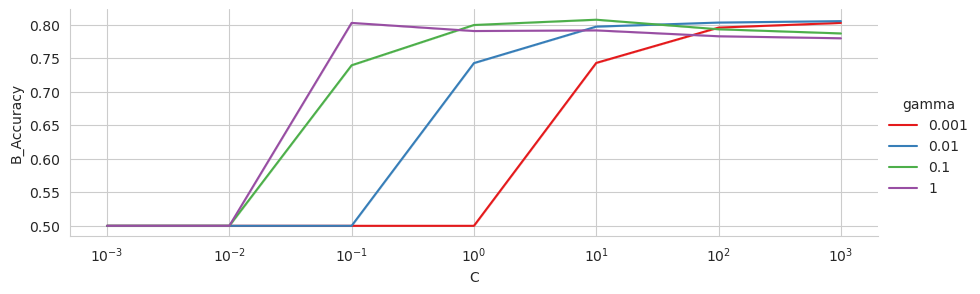

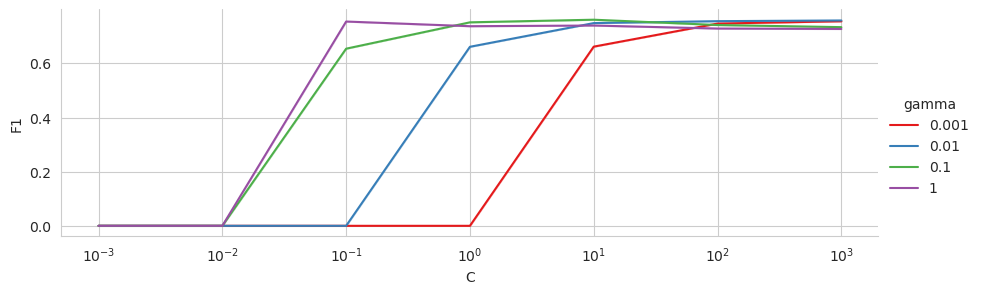

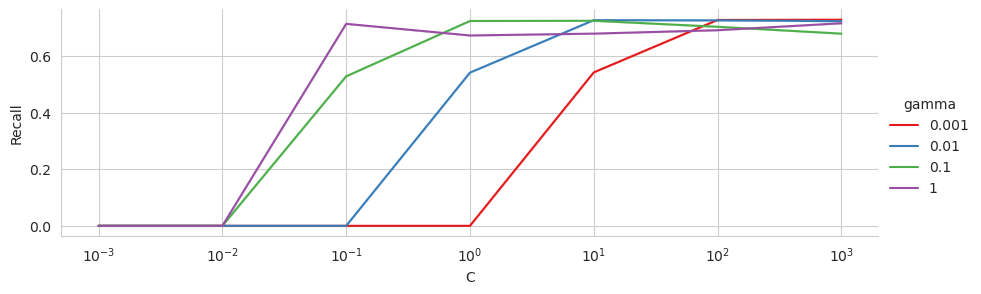

In [213]:
df_grid_results=pd.DataFrame({'C':np.array(my_tuned_svc.cv_results_['param_svc__C']),
                              'gamma':np.array(my_tuned_svc.cv_results_['param_svc__gamma']),
                             'B_Accuracy':np.array(my_tuned_svc.cv_results_['mean_test_BAccuracy']),
                             'F1':np.array(my_tuned_svc.cv_results_['mean_test_F1']),
                             'Recall':np.array(my_tuned_svc.cv_results_['mean_test_Recall'])})
plt.figure()
sns.relplot(data=df_grid_results, x='C', y='B_Accuracy', hue='gamma',palette='Set1',
kind="line", height=3, aspect=3).set(xticks=[0.001, 0.01,  0.1, 1,10,100,1000],xscale="log")
sns.relplot(data=df_grid_results, x='C', y='F1', hue='gamma',palette='Set1',
kind="line",height=3, aspect=3).set(xticks=[0.001, 0.01,  0.1, 1,10,100,1000],xscale="log")
sns.relplot(data=df_grid_results, x='C', y='Recall', hue='gamma',palette='Set1',
kind="line",height=3, aspect=3).set(xticks=[0.001, 0.01,  0.1, 1,10,100,1000],xscale="log")
plt.show()

In [214]:
param_grid_svc1 = [
 {
    'svc__kernel': ['rbf'],
    'svc__C': [10,20,30],
     'svc__gamma':[0.1,0.2,0.3],
    'svc__random_state':[0],
     'svc__tol':[0.0001]}
]

my_svc_pipe = make_pipeline(ColumnSelector(cols=best_svc_features),
                          SVC(probability=True,verbose = 0))

# Perform the search
my_tuned_svc = GridSearchCV(my_svc_pipe, param_grid=param_grid_svc1,
                            cv=cv_folds, verbose = 0, n_jobs = -1,scoring=metrics_to_check, refit="BAccuracy")
my_tuned_svc.fit(X_train_whole, y_train_whole.values.ravel())
print_gridsearchcv(my_tuned_svc)

\Best parameters set found on development set:
{'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__random_state': 0, 'svc__tol': 0.0001}
     Balanced_Accuracy: 0.80759,     std: 0.04852 
     F1               : 0.76126,     std: 0.06347 
     Recall           : 0.72614,     std: 0.08556 


<Figure size 640x480 with 0 Axes>

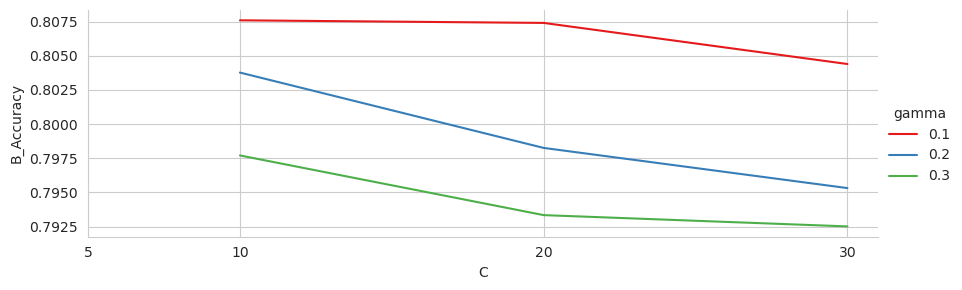

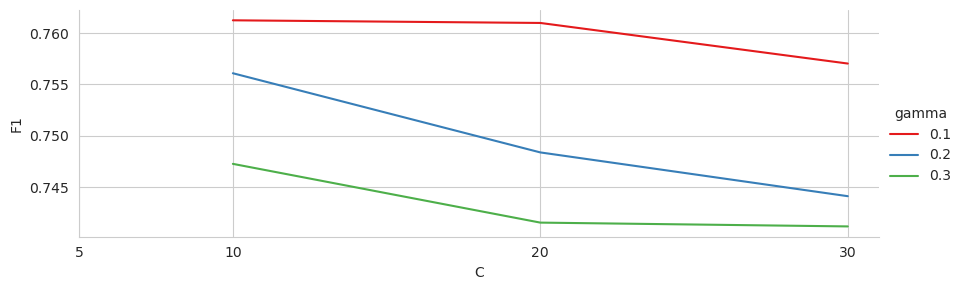

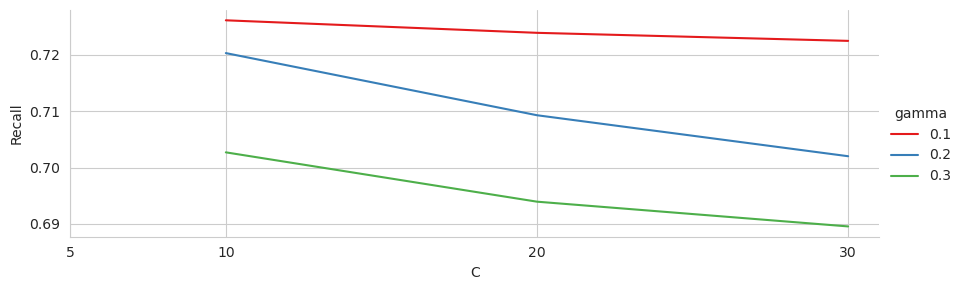

In [215]:
df_grid_results=pd.DataFrame({'C':np.array(my_tuned_svc.cv_results_['param_svc__C']),
                              'gamma':np.array(my_tuned_svc.cv_results_['param_svc__gamma']),
                             'B_Accuracy':np.array(my_tuned_svc.cv_results_['mean_test_BAccuracy']),
                             'F1':np.array(my_tuned_svc.cv_results_['mean_test_F1']),
                             'Recall':np.array(my_tuned_svc.cv_results_['mean_test_Recall'])})
plt.figure()
sns.relplot(data=df_grid_results, x='C', y='B_Accuracy', hue='gamma',palette='Set1',
kind="line", height=3, aspect=3).set(xticks=[5,10,20,30])
sns.relplot(data=df_grid_results, x='C', y='F1', hue='gamma',palette='Set1',
kind="line",height=3, aspect=3).set(xticks=[5,10,20,30])
sns.relplot(data=df_grid_results, x='C', y='Recall', hue='gamma',palette='Set1',
kind="line",height=3, aspect=3).set(xticks=[5,10,20,30])
plt.show()

In [216]:
print('Feature importance based on feature permutation:')
r_svc = permutation_importance(my_tuned_svc, X_train_whole[best_svc_features], y_train_whole.values.ravel(),
                           n_repeats=30,
                           random_state=0)
svc_features={}
svc_features['Model']='svc'
for i in r_svc.importances_mean.argsort()[::-1]:
    if r_svc.importances_mean[i]>0.0009:
        print(f"{X_train_whole[best_svc_features].columns[i]:<25}: {r_svc.importances_mean[i]:.3f} , +/- {r_svc.importances_std[i]:.3f}")
        svc_features[X_train_whole[best_svc_features].columns[i]]=r_svc.importances_mean[i]
ImportantFeatures=ImportantFeatures.append(svc_features,ignore_index=True, sort=False)
None

Feature importance based on feature permutation:
Title                    : 0.298 , +/- 0.016
groupsize                : 0.026 , +/- 0.007
Pclass                   : 0.013 , +/- 0.004
Age                      : 0.006 , +/- 0.004
Embarked                 : 0.003 , +/- 0.003
GS_Max                   : 0.001 , +/- 0.001


Accuracy: 0.8055229142185665
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       111
           1       0.82      0.71      0.76        69

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

Confusion Matrix


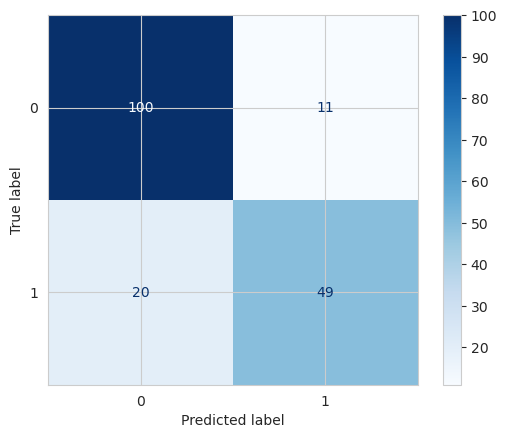

In [217]:
# Make a set of predictions for the testation data
y_pred_svc = my_tuned_svc.predict(Xt_test)

# Print performance details
accuracy = balanced_accuracy_score(y_test, y_pred_svc) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["tuned_svc"] = accuracy
print("Accuracy: " +  str(accuracy))
print(classification_report(y_test, y_pred_svc))

# Print confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, cmap = 'Blues')
None

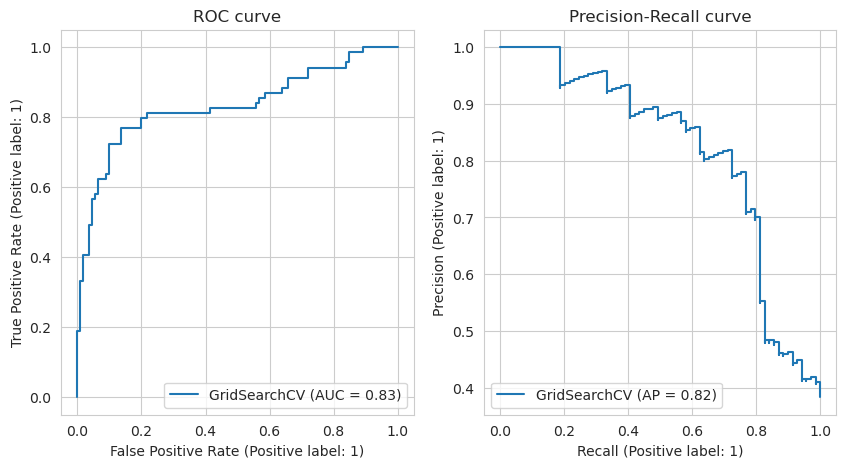

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

roc_display_svc = RocCurveDisplay.from_estimator(my_tuned_svc, Xt_test, y_test,ax=ax1)
pr_display_svc = PrecisionRecallDisplay.from_estimator(my_tuned_svc, Xt_test, y_test,ax=ax2)
roc_display_svc.ax_.set_title("ROC curve")
pr_display_svc.ax_.set_title("Precision-Recall curve")

plt.show()

# XGBoost Classifier

In [219]:
my_xgb_pipe = make_pipeline(ColumnSelector(cols=best_xgb_features),
                           XGBClassifier(random_state=0,verbosity=0,objective='binary:logistic'))


my_xgb_pipe.fit(X_train_whole, y_train_whole.values.ravel())

xgb_cv_results = cross_validate(my_xgb_pipe, X_train_whole, y_train_whole.values.ravel(),
                                                        cv=cv_folds,scoring=metrics_to_check,n_jobs = -1)

print_cv(svc_cv_results)

     Balanced_Accuracy: 0.81257,     std: 0.04171 
     F1               : 0.76860,     std: 0.05379 
     Recall           : 0.73566,     std: 0.07005 


0.7927927927927928

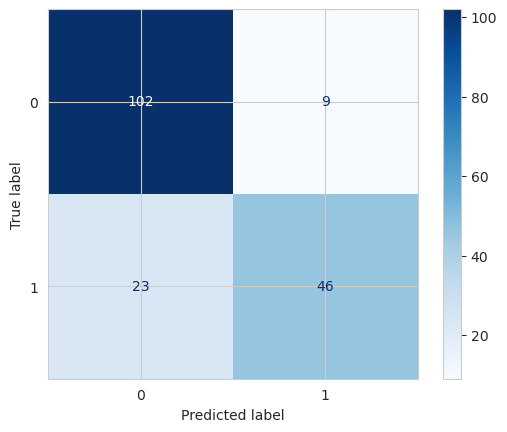

In [220]:
y_test_xgb=my_xgb_pipe.predict(Xt_test)
display(balanced_accuracy_score(y_test, y_test_xgb))
ConfusionMatrixDisplay.from_predictions(y_test,y_test_xgb, cmap = 'Blues')

In [221]:
data_dmatrix = xgb.DMatrix(data=X_train_whole[best_xgb_features],label=y_train_whole.values.ravel())
label = data_dmatrix.get_label()

xgb_params= {      
     'learning_rate': 0.005,
     'max_depth': 4, 
     'min_child_weight':1,
     'gamma':0,
     'subsample':0.8,
     'colsample_bytree':0.8,
     'objective':'binary:logistic',
     'nthread':-1,
     'seed':0}

xgb_cv_results = xgb.cv(dtrain=data_dmatrix,params=xgb_params, num_boost_round=2000, 
                        folds=list(cv_folds.split(X_train_whole[best_xgb_features],y_train_whole.values.ravel())),
                        seed=0, callbacks=[xgb.callback.EvaluationMonitor(show_stdv=False),
                                    xgb.callback.EarlyStopping(50)],
                                       metrics={'auc'})
print(xgb_cv_results )
n_estimators=xgb_cv_results.shape[0]

[0]	train-auc:0.89563	test-auc:0.87733
[1]	train-auc:0.89924	test-auc:0.88062
[2]	train-auc:0.90120	test-auc:0.88479
[3]	train-auc:0.90204	test-auc:0.88620
[4]	train-auc:0.90271	test-auc:0.88531
[5]	train-auc:0.90319	test-auc:0.88652
[6]	train-auc:0.90367	test-auc:0.88675
[7]	train-auc:0.90375	test-auc:0.88803
[8]	train-auc:0.90395	test-auc:0.88773
[9]	train-auc:0.90408	test-auc:0.88761
[10]	train-auc:0.90419	test-auc:0.88737
[11]	train-auc:0.90427	test-auc:0.88782
[12]	train-auc:0.90441	test-auc:0.88790
[13]	train-auc:0.90452	test-auc:0.88805
[14]	train-auc:0.90461	test-auc:0.88812
[15]	train-auc:0.90468	test-auc:0.88833
[16]	train-auc:0.90475	test-auc:0.88811
[17]	train-auc:0.90489	test-auc:0.88834
[18]	train-auc:0.90492	test-auc:0.88848
[19]	train-auc:0.90497	test-auc:0.88819
[20]	train-auc:0.90501	test-auc:0.88816
[21]	train-auc:0.90506	test-auc:0.88797
[22]	train-auc:0.90510	test-auc:0.88781
[23]	train-auc:0.90508	test-auc:0.88817
[24]	train-auc:0.90508	test-auc:0.88842
[25]	train

In [222]:
t1=time.time()

In [223]:
xgbc=XGBClassifier(verbosity=0,random_state = 0 )

efs_forward_xgb = EFS(estimator=xgbc,
                  min_features=len(best_xgb_features)-1,
                  max_features=len(best_xgb_features),
                 fixed_features=fixed_tree_features,
                  print_progress=False,
                  clone_estimator=False,
                  scoring=scoring,
                  cv=cv_folds_efs, 
                  n_jobs = -1)


xgb_efs_pipe=make_pipeline(efs_forward_xgb,xgbc)

param_grid_XG = [
 {  
      'exhaustivefeatureselector__estimator__subsample':[i/10.0 for i in range(5,9)],
     'exhaustivefeatureselector__estimator__colsample_bytree':[i/10.0 for i in range(5,9)],
    'exhaustivefeatureselector__estimator__learning_rate': [0.005],
    'exhaustivefeatureselector__estimator__n_estimators':  [n_estimators],
    'exhaustivefeatureselector__estimator__max_depth': [3,4,5], 
    'exhaustivefeatureselector__estimator__objective':['binary:logistic'],  
    'exhaustivefeatureselector__estimator__random_state':[0],
     'exhaustivefeatureselector__estimator__min_child_weight':[x for x in range(1,6,2)],
    'exhaustivefeatureselector__estimator__gamma':[0,0.2,0.4,0.6],
 }
]

my_tuned_xgb = GridSearchCV(estimator=xgb_efs_pipe,
                            param_grid=param_grid_XG, refit=True,
                            cv=cv_folds_efs, verbose = 0, n_jobs = -1, scoring=scoring)
my_tuned_xgb.fit(X_train_whole[best_xgb_features], y_train_whole.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('exhaustivefeatureselector',
                                        ExhaustiveFeatureSelector(clone_estimator=False,
                                                                  cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                                                                  estimator=XGBClassifier(base_score=None,
                                                                                          booster=None,
                                                                                          callbacks=None,
                                                                                          colsample_bylevel=None,
                                                                                          colsample_bynode=None,
                                                                                          col...
                                                                              5],
                          'exhaustivefeatureselector__estimator__min_child_weight': [1,
                                                                                     3,
                                                                                     5],
                          'exhaustivefeatureselector__estimator__n_estimators': [44],
                          'exhaustivefeatureselector__estimator__objective': ['binary:logistic'],
                          'exhaustivefeatureselector__estimator__random_state': [0],
                          'exhaustivefeatureselector__estimator__subsample': [0.5,
                                                                              0.6,
                                                                              0.7,
                                                                              0.8]}],
             scoring='balanced_accuracy')

In [224]:
print("Time:", int(time.time()-t1))

Time: 111


In [225]:
print('Best features:', my_tuned_xgb.best_estimator_.steps[0][1].best_feature_names_)

Best features: ('Pclass', 'Embarked', 'Deck', 'alt_sex', 'Title', 'groupsize', 'C_total', 'GS_Max', 'Fem_num', 'Age_group', 'binned_Fare_Log', 'Sex')


In [226]:
print(my_tuned_xgb.best_params_)
print(f"Score:{my_tuned_xgb.best_score_}, std:{my_tuned_xgb.cv_results_['std_test_score'][my_tuned_xgb.best_index_]}")

{'exhaustivefeatureselector__estimator__colsample_bytree': 0.5, 'exhaustivefeatureselector__estimator__gamma': 0, 'exhaustivefeatureselector__estimator__learning_rate': 0.005, 'exhaustivefeatureselector__estimator__max_depth': 5, 'exhaustivefeatureselector__estimator__min_child_weight': 1, 'exhaustivefeatureselector__estimator__n_estimators': 44, 'exhaustivefeatureselector__estimator__objective': 'binary:logistic', 'exhaustivefeatureselector__estimator__random_state': 0, 'exhaustivefeatureselector__estimator__subsample': 0.7}
Score:0.816094856612098, std:0.012367633588314454


In [227]:
best_xgb_features=list(my_tuned_xgb.best_estimator_.steps[0][1].best_feature_names_)
print('Best subset (corresponding names):', best_xgb_features,
      'number of selected features are ', len(best_xgb_features),' out of ', len(X_train_whole.columns))
print(f"Features not selected are:{[x for x in feature_groups if x not in best_xgb_features]}")
None

Best subset (corresponding names): ['Pclass', 'Embarked', 'Deck', 'alt_sex', 'Title', 'groupsize', 'C_total', 'GS_Max', 'Fem_num', 'Age_group', 'binned_Fare_Log', 'Sex'] number of selected features are  12  out of  15
Features not selected are:['Fare_Log', 'Mal_num', 'Age']


In [228]:
xgb_params= {      
     'learning_rate': 0.005,
     'max_depth': 5, 
     'min_child_weight':1,
     'gamma':0,
     'subsample':0.7,
     'colsample_bytree':0.5,
     'objective':'binary:logistic',
     'nthread':-1,
     'seed':0}

xgb_cv_results = xgb.cv(dtrain=data_dmatrix,params=xgb_params, num_boost_round=2000,
                folds=list(cv_folds.split(X_train_whole[best_xgb_features],y_train_whole.values.ravel())),
             metrics={'auc'}, seed=0,
             callbacks=[xgb.callback.EvaluationMonitor(show_stdv=False),
                        xgb.callback.EarlyStopping(50)])
print(xgb_cv_results )
n_estimators=xgb_cv_results.shape[0]

[0]	train-auc:0.88344	test-auc:0.86688
[1]	train-auc:0.89284	test-auc:0.87092
[2]	train-auc:0.89737	test-auc:0.87591
[3]	train-auc:0.89917	test-auc:0.87559
[4]	train-auc:0.90015	test-auc:0.87597
[5]	train-auc:0.90107	test-auc:0.87805
[6]	train-auc:0.90162	test-auc:0.87927
[7]	train-auc:0.90186	test-auc:0.88005
[8]	train-auc:0.90254	test-auc:0.87892
[9]	train-auc:0.90322	test-auc:0.88017
[10]	train-auc:0.90365	test-auc:0.87937
[11]	train-auc:0.90378	test-auc:0.88059
[12]	train-auc:0.90419	test-auc:0.88083
[13]	train-auc:0.90438	test-auc:0.88090
[14]	train-auc:0.90468	test-auc:0.88055
[15]	train-auc:0.90510	test-auc:0.88053
[16]	train-auc:0.90545	test-auc:0.88077
[17]	train-auc:0.90547	test-auc:0.88041
[18]	train-auc:0.90589	test-auc:0.88047
[19]	train-auc:0.90604	test-auc:0.88059
[20]	train-auc:0.90620	test-auc:0.88070
[21]	train-auc:0.90636	test-auc:0.88070
[22]	train-auc:0.90635	test-auc:0.88068
[23]	train-auc:0.90658	test-auc:0.88097
[24]	train-auc:0.90660	test-auc:0.88170
[25]	train

In [229]:
# Set up the parameter grid to search
param_grid_XG = [
 {  
      'xgbclassifier__subsample':[0.7],
     'xgbclassifier__colsample_bytree':[0.5],
    'xgbclassifier__learning_rate': [0.005],
    'xgbclassifier__n_estimators':  [n_estimators],
    'xgbclassifier__max_depth': [5], 
    'xgbclassifier__objective':['binary:logistic'],  
    'xgbclassifier__random_state':[0],
     'xgbclassifier__min_child_weight':[1],
    'xgbclassifier__gamma':[0,0.1],
 }
]

my_xgb_pipe = make_pipeline(ColumnSelector(cols=best_xgb_features),
                           XGBClassifier(verbosity=0))

Xt_valid_xgb=my_xgb_pipe['columnselector'].transform(Xt_valid)

# Perform the search
my_tuned_xgboost = GridSearchCV(my_xgb_pipe, param_grid=param_grid_XG, 
                                cv=cv_folds, n_jobs = -1,scoring=metrics_to_check, refit="BAccuracy")
my_tuned_xgboost.fit(X_train_whole, y_train_whole.values.ravel(),xgbclassifier__verbose=False)
print_gridsearchcv(my_tuned_xgboost)

\Best parameters set found on development set:
{'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.005, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 115, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__random_state': 0, 'xgbclassifier__subsample': 0.7}
     Balanced_Accuracy: 0.81183,     std: 0.04294 
     F1               : 0.76680,     std: 0.05669 
     Recall           : 0.71590,     std: 0.08089 


In [230]:
# Set up the parameter grid to search
param_grid_XG = [
 {  
      'xgbclassifier__subsample':[0.7],
     'xgbclassifier__colsample_bytree':[i/10.0 for i in range(1,6)],
    'xgbclassifier__learning_rate': [0.005],
    'xgbclassifier__n_estimators':  [n_estimators],
    'xgbclassifier__max_depth': [5], 
    'xgbclassifier__objective':['binary:logistic'],  
    'xgbclassifier__random_state':[0],
     'xgbclassifier__min_child_weight':[1],
    'xgbclassifier__gamma':[0],
 }
]

my_xgb_pipe = make_pipeline(ColumnSelector(cols=best_xgb_features),
                           XGBClassifier(verbosity=0))

Xt_valid_xgb=my_xgb_pipe['columnselector'].transform(Xt_valid)

# Perform the search
my_tuned_xgboost = GridSearchCV(my_xgb_pipe, param_grid=param_grid_XG, 
                                cv=cv_folds, n_jobs = -1,scoring=metrics_to_check, refit="BAccuracy")
my_tuned_xgboost.fit(X_train_whole, y_train_whole.values.ravel(),xgbclassifier__verbose=False)
print_gridsearchcv(my_tuned_xgboost)

\Best parameters set found on development set:
{'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.005, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 115, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__random_state': 0, 'xgbclassifier__subsample': 0.7}
     Balanced_Accuracy: 0.81183,     std: 0.04294 
     F1               : 0.76680,     std: 0.05669 
     Recall           : 0.71590,     std: 0.08089 


In [231]:
# Set up the parameter grid to search
param_grid_XG = [
 {  
      'xgbclassifier__subsample':[x/100 for x in range(75,86,1)],
     'xgbclassifier__colsample_bytree':[x/100 for x in range(45,56,1)],
    'xgbclassifier__learning_rate': [0.005],
    'xgbclassifier__n_estimators':  [n_estimators],
    'xgbclassifier__max_depth': [5], 
    'xgbclassifier__objective':['binary:logistic'],  
    'xgbclassifier__random_state':[0],
     'xgbclassifier__min_child_weight':[1],
    'xgbclassifier__gamma':[0],
 }
]

my_xgb_pipe = make_pipeline(ColumnSelector(cols=best_xgb_features),
                           XGBClassifier(verbosity=0))

Xt_valid_xgb=my_xgb_pipe['columnselector'].transform(Xt_valid)

# Perform the search
my_tuned_xgboost = GridSearchCV(my_xgb_pipe, param_grid=param_grid_XG, 
                                    cv=cv_folds, n_jobs = -1,scoring=metrics_to_check, refit="BAccuracy")
my_tuned_xgboost.fit(X_train_whole, y_train_whole.values.ravel(),xgbclassifier__verbose=False)
print_gridsearchcv(my_tuned_xgboost)

\Best parameters set found on development set:
{'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.005, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 115, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__random_state': 0, 'xgbclassifier__subsample': 0.85}
     Balanced_Accuracy: 0.81299,     std: 0.04278 
     F1               : 0.76824,     std: 0.05631 
     Recall           : 0.71958,     std: 0.08089 


In [232]:
# Set up the parameter grid to search
param_grid_XG = [
 {  
      'xgbclassifier__subsample':[0.85],
     'xgbclassifier__colsample_bytree':[0.5],
    'xgbclassifier__learning_rate': [0.005],
    'xgbclassifier__n_estimators':  [n_estimators],
    'xgbclassifier__max_depth': [5], 
    'xgbclassifier__objective':['binary:logistic'],  
    'xgbclassifier__random_state':[0],
     'xgbclassifier__min_child_weight':[1],
    'xgbclassifier__gamma':[0],
     'xgbclassifier__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 }
]

my_xgb_pipe = make_pipeline(ColumnSelector(cols=best_xgb_features),
                           XGBClassifier(verbosity=0))

Xt_valid_xgb=my_xgb_pipe['columnselector'].transform(Xt_valid)

# Perform the search
my_tuned_xgboost = GridSearchCV(my_xgb_pipe, param_grid=param_grid_XG, 
                                 cv=cv_folds, n_jobs = -1,scoring=metrics_to_check, refit="BAccuracy")
my_tuned_xgboost.fit(X_train_whole, y_train_whole.values.ravel(),xgbclassifier__verbose=False)
print_gridsearchcv(my_tuned_xgboost)

\Best parameters set found on development set:
{'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.005, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 115, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__random_state': 0, 'xgbclassifier__reg_alpha': 1, 'xgbclassifier__subsample': 0.85}
     Balanced_Accuracy: 0.81330,     std: 0.04492 
     F1               : 0.76874,     std: 0.05873 
     Recall           : 0.71884,     std: 0.08287 


In [233]:
# Set up the parameter grid to search
param_grid_XG = [
 {  
      'xgbclassifier__subsample':[0.85],
     'xgbclassifier__colsample_bytree':[0.5],
    'xgbclassifier__learning_rate': [0.005],
    'xgbclassifier__n_estimators':  [n_estimators],
    'xgbclassifier__max_depth': [5], 
    'xgbclassifier__objective':['binary:logistic'],  
    'xgbclassifier__random_state':[0],
     'xgbclassifier__min_child_weight':[1],
    'xgbclassifier__gamma':[0],
     'xgbclassifier__reg_alpha':[x/10 for x in range(5,30,1)],
 }
]

my_xgb_pipe = make_pipeline(ColumnSelector(cols=best_xgb_features),
                           XGBClassifier(verbosity=0))

Xt_valid_xgb=my_xgb_pipe['columnselector'].transform(Xt_valid)

# Perform the search
my_tuned_xgboost = GridSearchCV(my_xgb_pipe, param_grid=param_grid_XG, 
                                 cv=cv_folds, n_jobs = -1,scoring=metrics_to_check, refit="BAccuracy")
my_tuned_xgboost.fit(X_train_whole, y_train_whole.values.ravel(),xgbclassifier__verbose=False)
print_gridsearchcv(my_tuned_xgboost)

\Best parameters set found on development set:
{'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.005, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 115, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__random_state': 0, 'xgbclassifier__reg_alpha': 1.4, 'xgbclassifier__subsample': 0.85}
     Balanced_Accuracy: 0.81537,     std: 0.04598 
     F1               : 0.77145,     std: 0.06011 
     Recall           : 0.72251,     std: 0.08340 


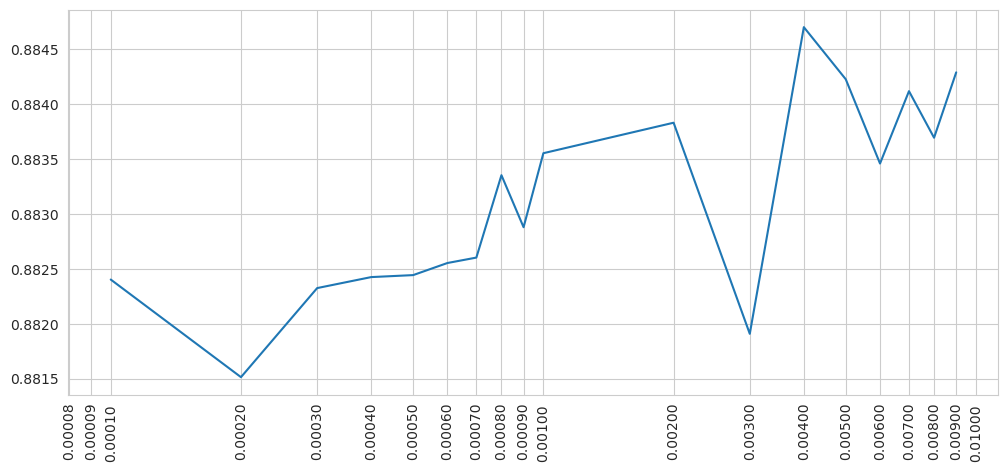

In [234]:
lr_vs_auc={}
for i in [x/10000 for x in range(1,10,1)]+[x/1000 for x in range(1,10,1)]:
    xgb_params= { 
        'seed':0,
     'learning_rate': i,
     'max_depth': 5, 
     'min_child_weight':1,
     'gamma':0,
     'subsample':0.85,
     'colsample_bytree':0.5,
     'objective':'binary:logistic',
     'nthread':-1,
     'reg_alpha': 1.4}
    xgb_cv_results = xgb.cv(dtrain=data_dmatrix,params=xgb_params, num_boost_round=2000,
                folds=list(cv_folds.split(X_train_whole[best_xgb_features],y_train_whole.values.ravel())),
             metrics={'auc'}, seed=0,
             callbacks=[#xgb.callback.EvaluationMonitor(show_stdv=False),
                        xgb.callback.EarlyStopping(50)])
    lr_vs_auc[i]=xgb_cv_results.tail(1)['test-auc-mean'].values[0]
x_ticks, y_ticks = zip(*sorted(lr_vs_auc.items()))
fig, ax = plt.subplots(figsize=(12,5)) 
plt.plot(x_ticks, y_ticks)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:1.5f}'))
ax.xaxis.set_minor_formatter(StrMethodFormatter('{x:1.5f}'))

plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.grid(True, which='minor')
plt.show()

In [235]:
xgb_params= {   
    'seed':0,
     'learning_rate': 0.004,
     'max_depth': 5, 
     'min_child_weight':1,
     'gamma':0,
     'subsample':0.85,
     'colsample_bytree':0.5,
     'objective':'binary:logistic',
     'nthread':-1,
    #'scale_pos_weight':ratio,
     'reg_alpha': 1.4}

data_dmatrix = xgb.DMatrix(data=X_train_whole[best_xgb_features],label=y_train_whole.values.ravel())
xgb_cv_results = xgb.cv(dtrain=data_dmatrix,params=xgb_params, num_boost_round=2000,
                folds=list(cv_folds.split(X_train_whole[best_xgb_features],y_train_whole.values.ravel())),
             metrics={'auc'}, seed=0,
             callbacks=[xgb.callback.EvaluationMonitor(show_stdv=False),
                        xgb.callback.EarlyStopping(50)])
n_estimators=xgb_cv_results.shape[0]
print(xgb_cv_results.tail(1))

[0]	train-auc:0.81053	test-auc:0.79848
[1]	train-auc:0.87234	test-auc:0.85684
[2]	train-auc:0.88498	test-auc:0.87352
[3]	train-auc:0.88951	test-auc:0.87722
[4]	train-auc:0.89236	test-auc:0.87847
[5]	train-auc:0.89358	test-auc:0.87867
[6]	train-auc:0.89451	test-auc:0.87887
[7]	train-auc:0.89535	test-auc:0.87827
[8]	train-auc:0.89565	test-auc:0.87912
[9]	train-auc:0.89634	test-auc:0.87908
[10]	train-auc:0.89685	test-auc:0.87940
[11]	train-auc:0.89722	test-auc:0.87913
[12]	train-auc:0.89749	test-auc:0.87912
[13]	train-auc:0.89756	test-auc:0.87962
[14]	train-auc:0.89786	test-auc:0.87958
[15]	train-auc:0.89781	test-auc:0.87908
[16]	train-auc:0.89793	test-auc:0.87904
[17]	train-auc:0.89815	test-auc:0.87910
[18]	train-auc:0.89832	test-auc:0.87976
[19]	train-auc:0.89849	test-auc:0.87993
[20]	train-auc:0.89863	test-auc:0.88005
[21]	train-auc:0.89869	test-auc:0.88015
[22]	train-auc:0.89867	test-auc:0.88005
[23]	train-auc:0.89889	test-auc:0.87958
[24]	train-auc:0.89904	test-auc:0.87961
[25]	train

[203]	train-auc:0.90436	test-auc:0.88280
[204]	train-auc:0.90436	test-auc:0.88287
[205]	train-auc:0.90440	test-auc:0.88293
[206]	train-auc:0.90442	test-auc:0.88300
[207]	train-auc:0.90446	test-auc:0.88300
[208]	train-auc:0.90448	test-auc:0.88285
[209]	train-auc:0.90450	test-auc:0.88283
[210]	train-auc:0.90450	test-auc:0.88295
[211]	train-auc:0.90452	test-auc:0.88298
[212]	train-auc:0.90454	test-auc:0.88300
[213]	train-auc:0.90458	test-auc:0.88303
[214]	train-auc:0.90460	test-auc:0.88300
[215]	train-auc:0.90462	test-auc:0.88290
[216]	train-auc:0.90466	test-auc:0.88297
[217]	train-auc:0.90469	test-auc:0.88282
[218]	train-auc:0.90471	test-auc:0.88277
[219]	train-auc:0.90472	test-auc:0.88280
[220]	train-auc:0.90475	test-auc:0.88265
[221]	train-auc:0.90480	test-auc:0.88274
[222]	train-auc:0.90480	test-auc:0.88279
[223]	train-auc:0.90482	test-auc:0.88272
[224]	train-auc:0.90484	test-auc:0.88267
[225]	train-auc:0.90484	test-auc:0.88261
[226]	train-auc:0.90485	test-auc:0.88268
[227]	train-auc:

In [236]:
# Set up the parameter grid to search
param_grid_XG = [
 {  
      'xgbclassifier__subsample':[0.85],
     'xgbclassifier__colsample_bytree':[0.5],
    'xgbclassifier__learning_rate': [0.004],
    'xgbclassifier__n_estimators':  [n_estimators],
    'xgbclassifier__max_depth': [5], 
    'xgbclassifier__objective':['binary:logistic'],  
    'xgbclassifier__random_state':[0],
     'xgbclassifier__min_child_weight':[1],
    'xgbclassifier__gamma':[0],
     'xgbclassifier__reg_alpha':[1.4],
 }
]

my_xgb_pipe = make_pipeline(ColumnSelector(cols=best_xgb_features),
                           XGBClassifier(verbosity=0))

Xt_valid_xgb=my_xgb_pipe['columnselector'].transform(Xt_valid)

# Perform the search
my_tuned_xgboostv2 = GridSearchCV(my_xgb_pipe, param_grid=param_grid_XG, 
                                  cv=cv_folds, n_jobs = -1,scoring=metrics_to_check, refit="BAccuracy")
my_tuned_xgboostv2.fit(X_train_whole, y_train_whole.values.ravel(),xgbclassifier__verbose=False)
print_gridsearchcv(my_tuned_xgboostv2)

\Best parameters set found on development set:
{'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.004, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 197, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__random_state': 0, 'xgbclassifier__reg_alpha': 1.4, 'xgbclassifier__subsample': 0.85}
     Balanced_Accuracy: 0.81197,     std: 0.04316 
     F1               : 0.76698,     std: 0.05683 
     Recall           : 0.71661,     std: 0.08040 


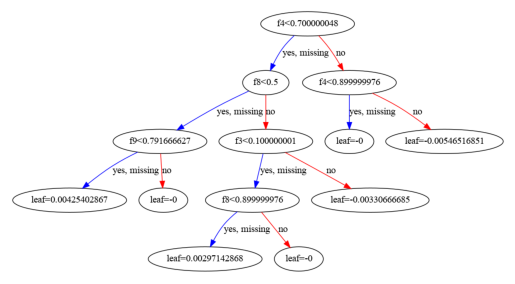

In [237]:
plot_tree(my_tuned_xgboostv2.best_estimator_['xgbclassifier'],num_trees=0); plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

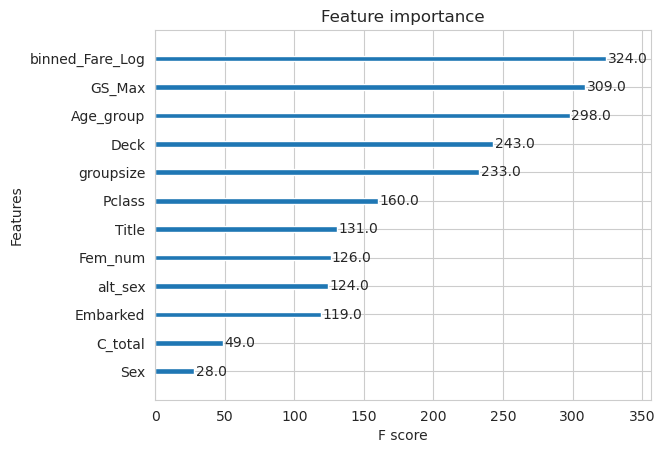

In [238]:
my_tuned_xgboostv2.best_estimator_["xgbclassifier"].get_booster().feature_names =list(best_xgb_features)
xgb.plot_importance(my_tuned_xgboostv2.best_estimator_["xgbclassifier"])

In [239]:
r_xboost = permutation_importance(my_tuned_xgboostv2, X_train_whole[best_xgb_features], y_train_whole.values.ravel(),
                           n_repeats=30,
                           random_state=0)

xboost_features={}
xboost_features['Model']='xboost'
for i in r_xboost.importances_mean.argsort()[::-1]:
    if r_xboost.importances_mean[i]>0.0009:
        print(f"{Xt_train[best_xgb_features].columns[i]:<25}: {r_xboost.importances_mean[i]:.3f} , +/- {r_xboost.importances_std[i]:.3f}")
        xboost_features[Xt_train[best_xgb_features].columns[i]]=r_xboost.importances_mean[i]
ImportantFeatures=ImportantFeatures.append(xboost_features,ignore_index=True, sort=False)
None

Title                    : 0.070 , +/- 0.008
alt_sex                  : 0.037 , +/- 0.008
Pclass                   : 0.021 , +/- 0.004
groupsize                : 0.015 , +/- 0.005
Fem_num                  : 0.009 , +/- 0.002
binned_Fare_Log          : 0.006 , +/- 0.003
Age_group                : 0.002 , +/- 0.002
Embarked                 : 0.001 , +/- 0.002


Accuracy: 0.8172737955346652
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       111
           1       0.83      0.72      0.78        69

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.82       180
weighted avg       0.84      0.84      0.84       180

Confusion Matrix


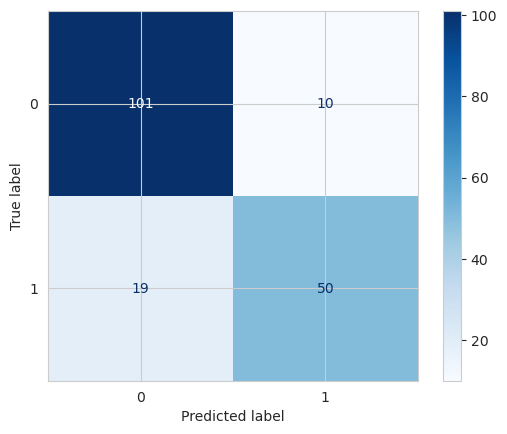

In [240]:
# Make a set of predictions for the testation data
y_pred_xg = my_tuned_xgboostv2.predict(Xt_test)

# Print performance details
accuracy = balanced_accuracy_score(y_test, y_pred_xg) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["tuned_xgboost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(classification_report(y_test, y_pred_xg))

# Print confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xg, cmap = 'Blues')

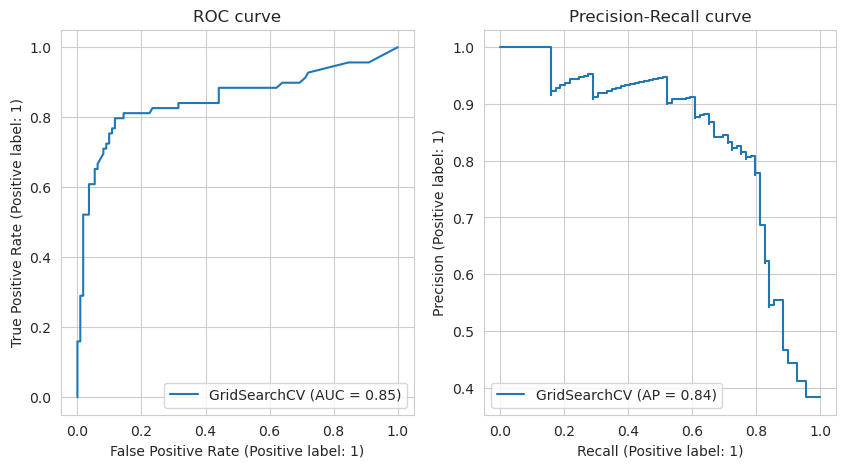

In [241]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

roc_display_xgb = RocCurveDisplay.from_estimator(my_tuned_xgboostv2, Xt_test, y_test,ax=ax1)
pr_display_xgb = PrecisionRecallDisplay.from_estimator(my_tuned_xgboostv2, Xt_test, y_test,ax=ax2)
roc_display_xgb.ax_.set_title("ROC curve")
pr_display_xgb.ax_.set_title("Precision-Recall curve")

plt.show()

# Comparing models

### Comparing feature importance

In [242]:
ImportantFeatures=ImportantFeatures.fillna(0)
ImportantFeatures['Sum']=ImportantFeatures.sum(axis=1)
ImportantFeatures.loc['Total']=ImportantFeatures.sum()

In [243]:
print('Feature importance based on feature permutation across all models:')
print(ImportantFeatures.T)

Feature importance based on feature permutation across all models:
                        0         1         2         Total
Model                 rfc       svc    xboost  rfcsvcxboost
Pclass           0.017725   0.01281  0.021304      0.051839
Embarked         0.002904  0.002611  0.001019      0.006535
Deck             0.003862       0.0       0.0      0.003862
alt_sex          0.052912       0.0  0.037033      0.089945
Fare_Log                0         0         0             0
Title            0.116051  0.298256  0.069917      0.484225
groupsize        0.013542  0.025846  0.014818      0.054206
C_total                 0         0         0             0
GS_Max           0.001792  0.001369       0.0      0.003161
Fem_num          0.010342       0.0  0.009357      0.019699
Mal_num                 0         0         0             0
Age_group        0.004512       0.0  0.002028       0.00654
binned_Fare_Log  0.006146       0.0  0.005907      0.012052
Sex                     0        

### Comparing Accuracy on hold-out

In [244]:
display(model_test_accuracy_comparisons)

{'tuned_rfc': 0.8055229142185665,
 'tuned_svc': 0.8055229142185665,
 'tuned_xgboost': 0.8172737955346652}

### Comparing correlation in between models's predictions

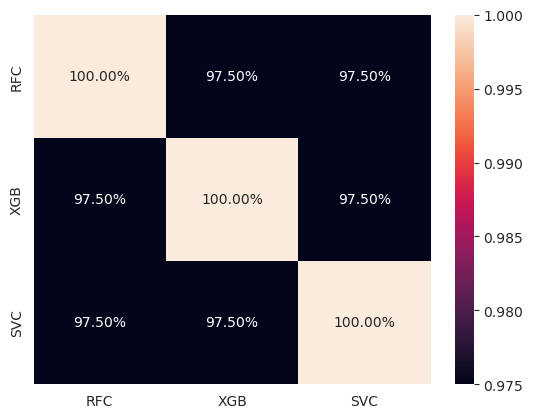

In [245]:
# Concatenate all classifier results
model_results = pd.concat([pd.Series(y_pred_rfc, name="RFC"),
                           pd.Series(y_pred_xg, name="XGB"),
                           pd.Series(y_pred_svc, name="SVC")],axis=1)
heatmap= sns.heatmap(model_results.corr(),annot=True,fmt=".2%")
None

# Stacking

In [246]:
tuned_rfc=make_pipeline(ColumnSelector(cols=best_rfc_features),
RandomForestClassifier(**my_tuned_rfcv2.best_estimator_.named_steps["randomforestclassifier"].get_params()))

In [247]:
tuned_xgb=make_pipeline(ColumnSelector(cols=best_xgb_features),
                    XGBClassifier(**my_tuned_xgboostv2.best_estimator_.named_steps["xgbclassifier"].get_params()))

In [248]:
tuned_svc=make_pipeline(ColumnSelector(cols=best_svc_features),
                          SVC(**my_tuned_svc.best_estimator_.named_steps["svc"].get_params()))

Accuracy: 0.8100274187230709
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       111
           1       0.83      0.71      0.77        69

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

Confusion Matrix


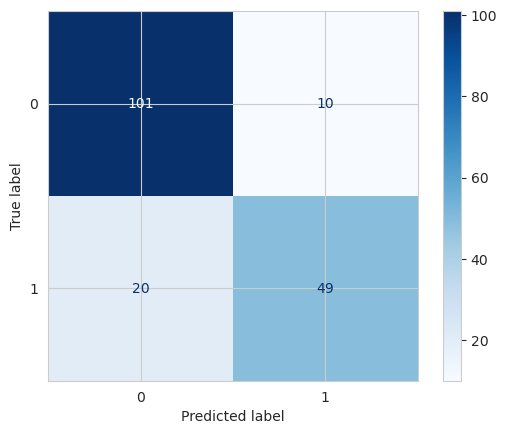

In [249]:
lr = LogisticRegression()
vc = StackingClassifier(classifiers=[tuned_rfc, tuned_xgb, tuned_svc],
                             meta_classifier=lr)
vc.fit(X_train_whole, y_train_whole.values.ravel())
y_pred = vc.predict(Xt_test)

# Print performance details
accuracy = balanced_accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Stacking_Classifier"] = accuracy
print("Accuracy: " +  str(accuracy))
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues')

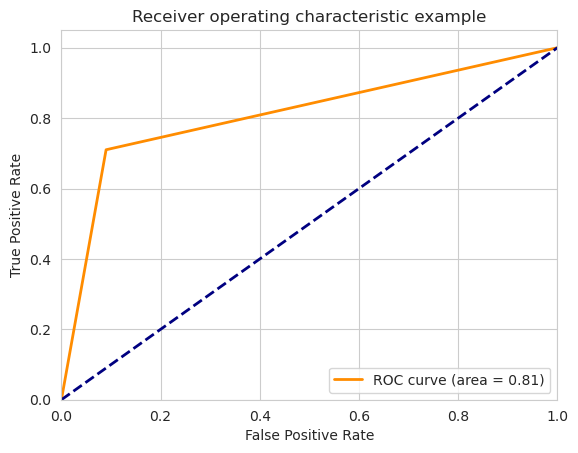

In [250]:
n_classes = y_test.shape[1]
y_score = vc.predict(Xt_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [251]:
display(model_test_accuracy_comparisons)
None

{'tuned_rfc': 0.8055229142185665,
 'tuned_svc': 0.8055229142185665,
 'tuned_xgboost': 0.8172737955346652,
 'Stacking_Classifier': 0.8100274187230709}

#### Checking wrongly classfied results

In [252]:
corrects = y_pred != y_test.values.ravel()
Miss_classified1=pd.DataFrame(data=None)
for i in range(X_test.shape[0]):
    if corrects[i]:
        in_correct=X_test.iloc[i].to_frame().T
        Miss_classified1=Miss_classified1.append(dfv01_unencoded.iloc[in_correct.index[0]].T)
Miss_classified1

Survived  Pclass    Age_group Embarked Deck          alt_sex  C_total  \
49          0       3    late_teen        S    U           female      0.0   
474         0       3  young adult        S    U           female      0.0   
854         0       2       adult2        S    U           female      0.0   
449         1       1       adult3        S    C             male      0.0   
224         1       1       adult2        S    C             male      0.0   
828         1       3       adult1        Q    U             male      0.0   
447         1       1       adult1        S    U             male      0.0   
762         1       3  young adult        C    U             male      0.0   
415         0       3       adult2        S    U           female      0.0   
587         1       1       senior        C    B             male      0.0   
744         1       3       adult1        S    U             male      0.0   
622         1       3  young adult        C    U         male_w_c      1.0   
107         1       3       adult1        S    U             male      0.0   
209         1       1       adult2        C    A             male      0.0   
267         1       3  young adult        S    U             male      0.0   
484         1       1  young adult        C    B             male      0.0   
404         0       3  young adult        S    U           female      0.0   
553         1       3  young adult        C    U             male      0.0   
579         1       3       adult1        S    U             male      0.0   
767         0       3       adult1        Q    U           female      0.0   
570         1       2      elderly        S    U             male      0.0   
297         0       1       infant        S    C  children_female      2.0   
97          1       1  young adult        C    D             male      0.0   
293         0       3  young adult        S    U           female      0.0   
569         1       3       adult1        S    U             male      0.0   
501         0       3  young adult        Q    U           female      0.0   
391         1       3  young adult        S    U             male      0.0   
338         1       3       adult3        S    U             male      0.0   
8           1       3  young adult        S    U       female_w_c      2.0   
254         0       3       adult2        S    U       female_w_c      1.0   

     groupsize     Title  Fare_Log  GS_Max  Fem_num  Mal_num     Sex  \
49           2       Mrs  2.186051       2      1.0      1.0  female   
474          1      Miss  2.286202       1      0.0      0.0  female   
854          2       Mrs  2.564949       6      3.0      3.0  female   
449          1  NobleMan  3.417727       1      0.0      0.0    male   
224          2        Mr  3.806662       3      1.0      2.0    male   
828          1        Mr  2.047693       1      0.0      0.0    male   
447          1        Mr  3.279030       1      0.0      0.0    male   
762          1        Mr  1.978128       1      0.0      0.0    male   
415          1       Mrs  2.085672       1      0.0      0.0  female   
587          3        Mr  3.273364       3      1.0      1.0    male   
744          1        Mr  2.070022       1      0.0      0.0    male   
622          3        Mr  1.657701       3      1.0      1.0    male   
107          1        Mr  2.050913       1      0.0      0.0    male   
209          1        Mr  3.433987       1      0.0      0.0    male   
267          2        Mr  1.357766       2      0.0      0.0    male   
484          2        Mr  3.818582       2      1.0      1.0    male   
404          1      Miss  2.159003       3      2.0      1.0  female   
553          1        Mr  1.977547       1      0.0      0.0    male   
579          1        Mr  2.070022       3      2.0      1.0    male   
767          1      Miss  2.047693       1      0.0      0.0  female   
570          1        Mr  2.351375       4      1.0      3.0    male   
29

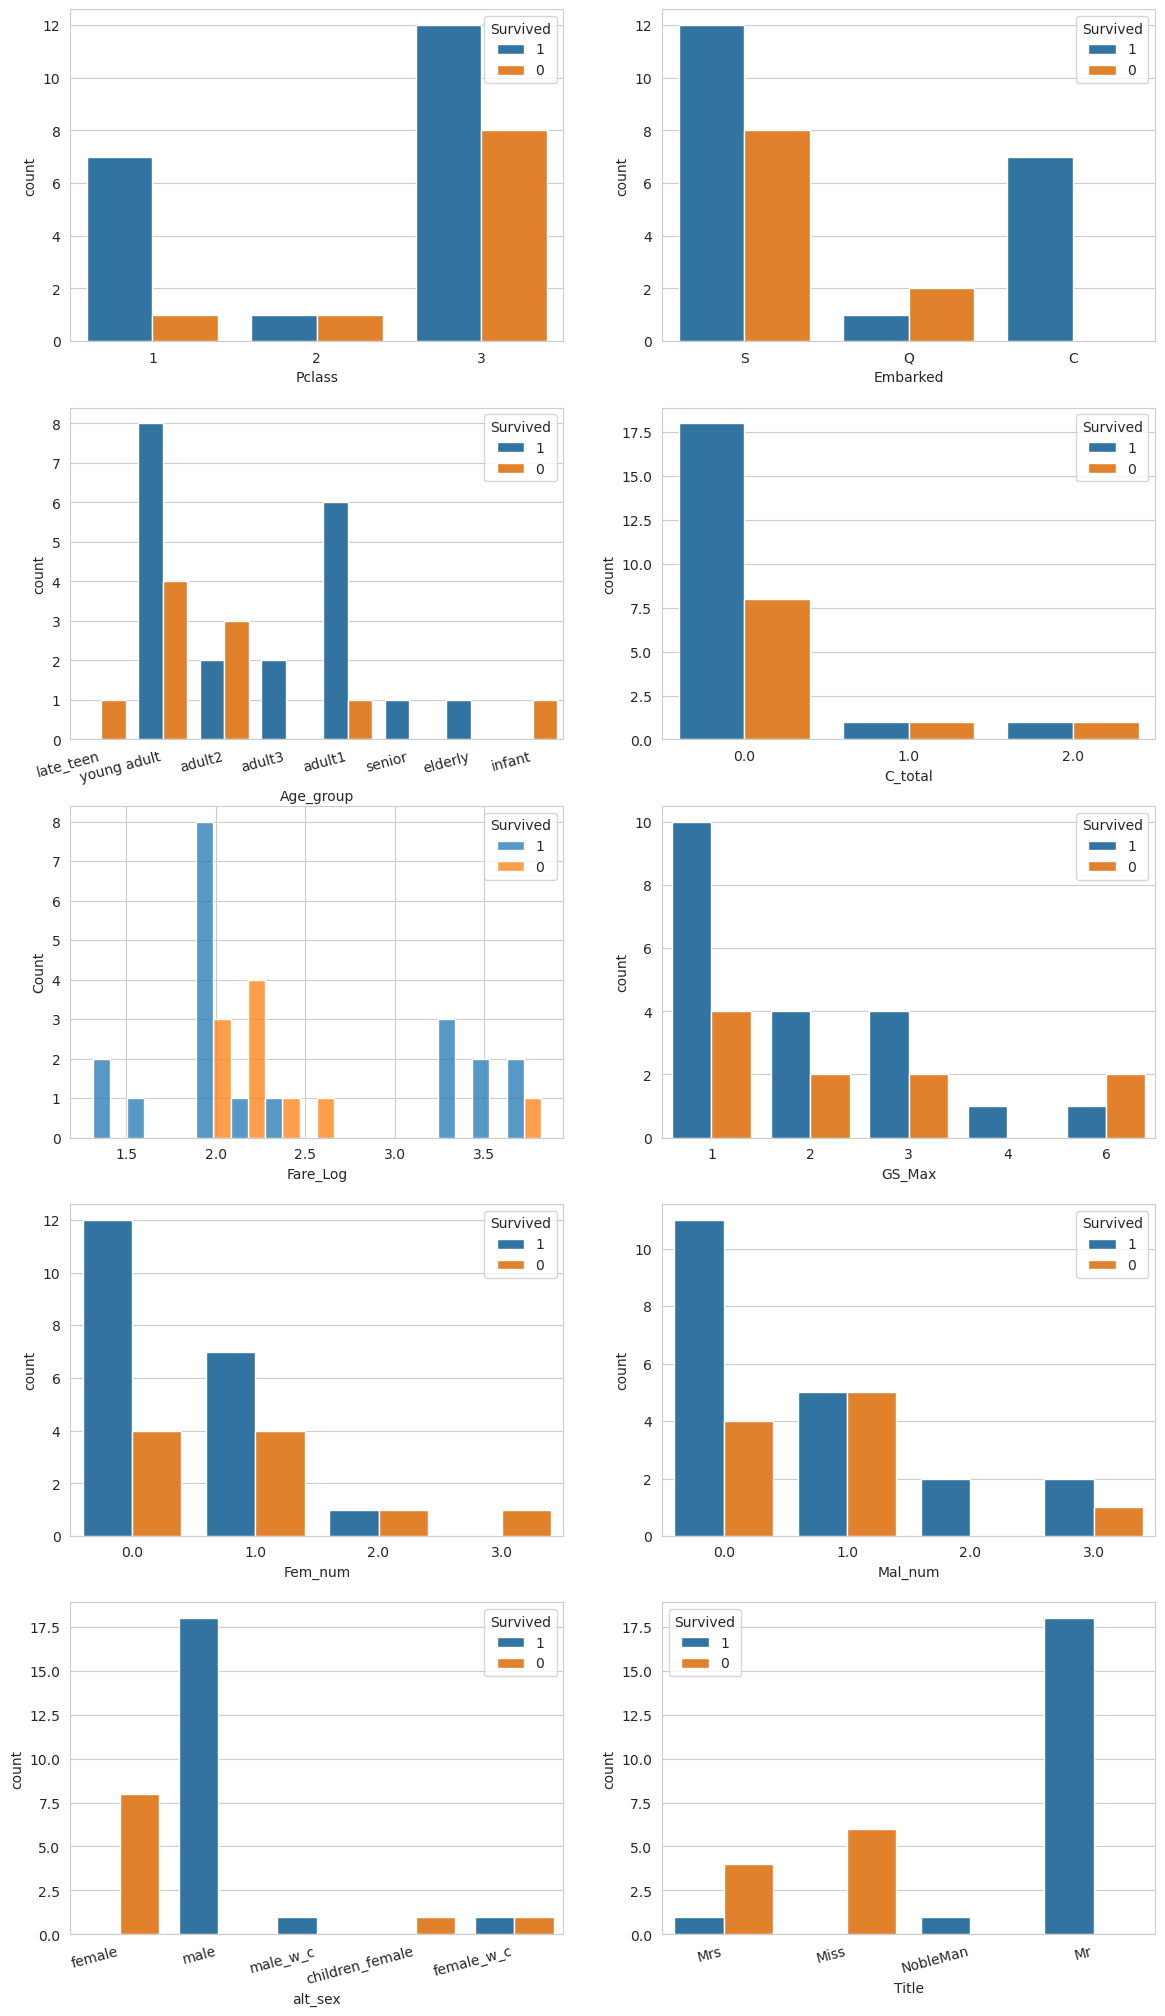

In [253]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14,25))
sns.countplot(data=Miss_classified1,x='Pclass',  hue='Survived', hue_order= [1, 0], ax=axes[0,0])
sns.countplot(data=Miss_classified1,x='Embarked',  hue='Survived',hue_order= [1, 0], ax=axes[0,1])
sns.countplot(data=Miss_classified1,x='alt_sex',  hue='Survived',hue_order= [1, 0],ax=axes[4,0])
sns.countplot(data=Miss_classified1,x='C_total',  hue='Survived',hue_order= [1, 0],ax=axes[1,1])
sns.countplot(data=Miss_classified1,x='Title',  hue='Survived',hue_order= [1, 0], ax=axes[4,1])
sns.countplot(data=Miss_classified1,x='GS_Max',  hue='Survived',hue_order= [1, 0], ax=axes[2,1])
sns.countplot(data=Miss_classified1,x='Fem_num',  hue='Survived',hue_order= [1, 0], ax=axes[3,0])
sns.countplot(data=Miss_classified1,x='Mal_num',  hue='Survived',hue_order= [1, 0], ax=axes[3,1])
sns.countplot(data=Miss_classified1,x='Age_group', hue='Survived',hue_order=  [1, 0],ax=axes[1,0])
sns.histplot(data=Miss_classified1,x='Fare_Log',multiple='dodge', hue='Survived',hue_order= [1, 0], 
             ax=axes[2,0], bins=13)
axes[4,0].set_xticklabels(axes[4,0].get_xticklabels(), 
                          rotation=15, 
                          horizontalalignment='right')
axes[4,1].set_xticklabels(axes[4,1].get_xticklabels(), 
                          rotation=15, 
                          horizontalalignment='right')
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), 
                          rotation=15, 
                          horizontalalignment='right')
None

# Submission

## Re-training with whole train dataset

#### Applying transformations made after splits to unsplitted dataset

In [254]:
X = pd.DataFrame(scaler_fitted.transform(X), columns = X.columns)
X=X[feature_groups]

In [255]:
vc_full = StackingClassifier(classifiers=[tuned_rfc, tuned_xgb, tuned_svc],
                             meta_classifier=lr)
display(vc_full.get_params())

{'average_probas': False,
 'classifiers': [Pipeline(steps=[('columnselector',
                   ColumnSelector(cols=['Pclass', 'Embarked', 'Deck', 'alt_sex',
                                        'Title', 'groupsize', 'GS_Max', 'Fem_num',
                                        'Age_group', 'binned_Fare_Log'])),
                  ('randomforestclassifier',
                   RandomForestClassifier(max_depth=6, min_samples_leaf=17,
                                          min_samples_split=8, n_estimators=300,
                                          random_state=0))]),
  Pipeline(steps=[('columnselector',
                   ColumnSelector(cols=['Pclass', 'Embarked', 'Deck', 'alt_sex',
                                        'Title', 'groupsize', 'C_total', 'GS_Max',
                                        'Fem_num', 'Age_group', 'binned_Fare_Log',
                                        'Sex'])),
                  ('xgbclassifier',
                   XGBClassifier(base_score=None,

In [256]:
vc_full.fit(X, y.values.ravel())

StackingClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                 ColumnSelector(cols=['Pclass',
                                                                      'Embarked',
                                                                      'Deck',
                                                                      'alt_sex',
                                                                      'Title',
                                                                      'groupsize',
                                                                      'GS_Max',
                                                                      'Fem_num',
                                                                      'Age_group',
                                                                      'binned_Fare_Log'])),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(max_depth=6,
                                                                        min_samples_leaf=17,
                                                                        min_samples_split=8,
                                                                        n_estimators=300,
                                                                        random_state=0))]),
                                Pipeline(steps=[(...
                                                               n_estimators=197,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=0, ...))]),
                                Pipeline(steps=[('columnselector',
                                                 ColumnSelector(cols=['Pclass',
                                                                      'Embarked',
                                                                      'Deck',
                                                                      'Title',
                                                                      'groupsize',
                                                                      'GS_Max',
                                                                      'Mal_num',
                                                                      'Age',
                                                                      'Fare_Log'])),
                                                ('svc',
                                                 SVC(C=10, gamma=0.1,
                                                     probability=True,
                                                     random_state=0, tol=0.0001,
                                                     verbose=0))])],
                   meta_classifier=LogisticRegression())

In [257]:
vc_full.score(X, y.values.ravel())

0.8484848484848485

### Reading test-set and pre-processing

In [258]:
df_test=pd.read_csv('test.csv')

In [259]:
display(df_test.info())
display(df_test.head(2))
display(df_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

PassengerId  Pclass                              Name     Sex   Age  SibSp  \
0          892       3                  Kelly, Mr. James    male  34.5      0   
1          893       3  Wilkes, Mrs. James (Ellen Needs)  female  47.0      1   

   Parch  Ticket    Fare Cabin Embarked  
0      0  330911  7.8292   NaN        Q  
1      0  363272  7.0000   NaN        S

(418, 11)

In [260]:
"""Converting features into appropriate data types """
df_test['PassengerId'] = df_test['PassengerId'].astype('object')
df_test['Sex'] = df_test['Sex'].astype('category')
df_test['Embarked'] = df_test['Embarked'].astype('category')

In [261]:
X_df_test=new_features(df_test,Ticket_dict,df_stable)

In [262]:
X_df_test = X_df_test[df_full_features]

In [263]:
display(X_df_test.info())
display(X_df_test.head(2))
display(X_df_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pclass     418 non-null    int64   
 1   Age_group  418 non-null    category
 2   Embarked   418 non-null    category
 3   Deck       418 non-null    category
 4   alt_sex    418 non-null    category
 5   C_total    418 non-null    float64 
 6   groupsize  418 non-null    int64   
 7   Title      418 non-null    category
 8   Fare_Log   418 non-null    float64 
 9   GS_Max     418 non-null    int64   
 10  Fem_num    418 non-null    float64 
 11  Mal_num    418 non-null    float64 
 12  Sex        418 non-null    category
 13  Age        418 non-null    float64 
dtypes: category(6), float64(5), int64(3)
memory usage: 30.4 KB


None

Pclass Age_group Embarked Deck alt_sex  C_total  groupsize Title  Fare_Log  \
0       3    adult1        Q    U    male      0.0          1    Mr  2.057860   
1       3    adult3        S    U  female      0.0          2   Mrs  1.252763   

   GS_Max  Fem_num  Mal_num     Sex   Age  
0       5      3.0      2.0    male  34.5  
1       2      0.0      0.0  female  47.0

(418, 14)

In [264]:
X_df_test=encoder.encode(X_df_test)

In [265]:
#X_df_test=bin_maker.bin(X_df_test)
X_df_test=bin_maker_fare.bin_quantile(X_df_test)

In [266]:
display(X_df_test.info())
display(X_df_test.head(2))
display(X_df_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pclass           418 non-null    int64  
 1   Age_group        418 non-null    int8   
 2   Embarked         418 non-null    int8   
 3   Deck             418 non-null    int8   
 4   alt_sex          418 non-null    int8   
 5   C_total          418 non-null    float64
 6   groupsize        418 non-null    int64  
 7   Title            418 non-null    int8   
 8   Fare_Log         418 non-null    float64
 9   GS_Max           418 non-null    int64  
 10  Fem_num          418 non-null    float64
 11  Mal_num          418 non-null    float64
 12  Sex              418 non-null    int8   
 13  Age              418 non-null    float64
 14  binned_Fare_Log  418 non-null    float64
dtypes: float64(6), int64(3), int8(6)
memory usage: 32.0 KB


None

Pclass  Age_group  Embarked  Deck  alt_sex  C_total  groupsize  Title  \
0       3          9         1     7        4      0.0          1      5   
1       3          5         2     7        0      0.0          2      1   

   Fare_Log  GS_Max  Fem_num  Mal_num  Sex   Age  binned_Fare_Log  
0  2.057860       5      3.0      2.0    1  34.5              4.0  
1  1.252763       2      0.0      0.0    0  47.0              2.0

(418, 15)

In [267]:
X_df_test = X_df_test[features_f]

In [268]:
X_df_test = pd.DataFrame(scaler_fitted.transform(X_df_test), columns = X_df_test.columns)

In [269]:
X_df_test=X_df_test[feature_groups]

In [270]:
predictions =tuned_svc.fit(X, y.values.ravel()).predict(X_df_test) 
#22.06.2023 11.52 0.79186

In [275]:
#predictions =tuned_xgb.fit(X, y.values.ravel()).predict(X_df_test) 
#22.06.2023 11.52 0.78229

In [272]:
#predictions =tuned_rfc.fit(X, y.values.ravel()).predict(X_df_test)
#23.06.2023 11:34 0.78229 (only changed rfc)

In [273]:
#predictions = vc_full.predict(X_df_test)  
#23.06.2023 11:34 0.78229 (only changed rfc)

In [276]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
None

Your submission was successfully saved!
